# SVI downloader
- Soruce: Mapillary
- Period 2019-2024 (day time)
- label = hotspot/control

In [154]:
import os
import requests
import mercantile
import json
# from vt2geojson.tools import vt_bytes_to_geojson
import datetime
import random
import pandas as pd
import geopandas as gpd
from itertools import cycle
from shapely.geometry import Point

In [ ]:
# --- CONFIG ---------------------------------------------------------------
GROUND_TRUTH_PATH = "roadnetwork/lixels_with_aadt_2019_2024_mean_final.geojson"

# Mapillary tokens (rotate to ease rate limits)
TOKENS = [
# "MLY|YOUR_MAPILLARY_TOKEN_1",
]
assert TOKENS, "⚠️ Please add at least one Mapillary token to TOKENS."

# TOKENS = MAPILLARY_TOKENS

# Time window (UTC)
DATE_START = "2019-01-01"
DATE_END   = "2024-12-31"

# Sampling & matching
SAMPLE_EVERY_M   = None   # None = midpoint per lixel (recommended for 100 m lixels)
SEARCH_RADIUS_M  = 100    # candidate search radius around each sample point (meters)
BEARING_TOL_DEG  = 30     # prefer compass within ±30°
TOPK_PER_LIXEL   = 5      # number of candidates per lixel before Graph filtering

# Vector tiles
ZLEVEL      = 15          # 15 or 16 work well
MAX_TILES   = 800         # cap total tiles this run (None to disable)
PRINT_EVERY = 50          # progress logging while fetching tiles

# Output
OUT_DIR            = "./svi_out_new"
CANDIDATES_PARQUET = f"{OUT_DIR}/mly_tile_points.parquet"
CHOSEN_CSV         = f"{OUT_DIR}/mapillary_chosen.csv"
CHOSEN_GEOJSON     = f"{OUT_DIR}/mapillary_chosen.geojson"
IMAGES_DIR         = f"{OUT_DIR}/images"

# Download
DRY_RUN            = True   # set False to download thumbnails
DOWNLOAD_RESOLVE_N = 100    # how many selected images to actually download (for a test)

# -------------------------------------------------------------------------
import os, math, time, random, re, json, glob, requests, mercantile
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
from vt2geojson.tools import vt_bytes_to_geojson
from itertools import cycle

os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(IMAGES_DIR, exist_ok=True)

TOK = cycle(TOKENS)
start_ms = int(pd.Timestamp(DATE_START, tz="UTC").timestamp()*1000)
end_ms   = int(pd.Timestamp(DATE_END,   tz="UTC").timestamp()*1000)
print("Config OK")


Config OK


### Helpers

In [158]:
def http_get(url, headers=None, params=None, stream=False, retries=4, backoff=1.7, timeout=25):
    """GET with naive retry/backoff (handles 429/5xx)."""
    last_err = None
    for i in range(retries):
        try:
            r = requests.get(url, headers=headers, params=params, stream=stream, timeout=timeout)
            if r.status_code in (200, 206):
                return r
            if r.status_code in (429, 500, 502, 503, 504):
                time.sleep((backoff**i) + random.random())
                continue
            r.raise_for_status()
            return r
        except Exception as e:
            last_err = e
            time.sleep((backoff**i) + random.random())
    raise last_err

def id_to_str(x):
    if x is None or (isinstance(x, float) and np.isnan(x)): return None
    if isinstance(x, (int, np.integer)): return str(int(x))
    if isinstance(x, float): return format(x, ".0f")
    s = str(x).strip()
    if s.endswith(".0") and s[:-2].isdigit(): return s[:-2]
    return s

def line_midpoint(line: LineString):
    return line.interpolate(0.5, normalized=True)

def densify_points(line: LineString, spacing_m: float|None):
    if not spacing_m or spacing_m <= 0: return [line_midpoint(line)]
    n = max(1, int(math.ceil(line.length / spacing_m)))
    return [line.interpolate(d/n, normalized=True) for d in range(1, n+1)]

def line_bearing(line: LineString, frac=0.5):
    # 0° = north; we convert to compass-like bearing
    L = line.length
    if L == 0: return np.nan
    d = min(5.0, 0.05*L)
    p0 = line.interpolate(max(0, frac*L - d))
    p1 = line.interpolate(min(L, frac*L + d))
    dx, dy = (p1.x-p0.x), (p1.y-p0.y)
    # mathematical to compass bearing
    return (90 - math.degrees(math.atan2(dy, dx))) % 360

def bearing_diff(a, b):
    if a is None or b is None or (isinstance(a, float) and np.isnan(a)) or (isinstance(b, float) and np.isnan(b)):
        return 999.0
    return abs((a - b + 180) % 360 - 180)


In [159]:
# Load & filter ground-truth lixels (LineString), keep hotspot/control only
gt = gpd.read_file(GROUND_TRUTH_PATH)
gt = gt[gt["label"].isin(["hotspot", "control"])].copy().to_crs(3857).reset_index(drop=True)
assert isinstance(gt.geometry.iloc[0], LineString), "Expected LineString geometries."

gt["lixel_id"] = gt.index

# one (or many) sample points per lixel
rows = []
for _, r in gt.iterrows():
    pts = densify_points(r.geometry, SAMPLE_EVERY_M)
    b   = line_bearing(r.geometry, 0.5)
    for j, p in enumerate(pts):
        rows.append({"lixel_id": r["lixel_id"], "pt_id": f"{r['lixel_id']}_{j}",
                     "label": r["label"], "bearing": b, "geometry": p})
samples = gpd.GeoDataFrame(rows, crs=3857)
print(f"Lixels: {len(gt):,} | Sample points: {len(samples):,}")


Lixels: 28,756 | Sample points: 28,756


### Locations of lixels (samples: mid of lixels)

<Axes: >

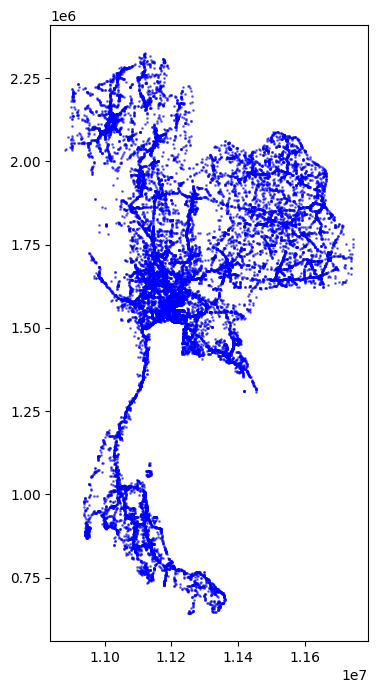

In [160]:
samples.plot(figsize=(8,8), color='blue', markersize=1,alpha=0.5)

In [161]:
s4326  = samples.to_crs(4326)
bufdeg = SEARCH_RADIUS_M / 111_000.0  # crude degree buffer; fine for small radii
tiles = set()
for x, y in zip(s4326.geometry.x, s4326.geometry.y):
    for t in mercantile.tiles(x - bufdeg, y - bufdeg, x + bufdeg, y + bufdeg, ZLEVEL):
        tiles.add((t.z, t.x, t.y))
tiles = list(tiles)

print(f"Candidate tiles: {len(tiles):,}")
if MAX_TILES and len(tiles) > MAX_TILES:
    tiles = tiles[:MAX_TILES]
    print(f"⚠️  Capped tiles to: {len(tiles)} (z={ZLEVEL})")


Candidate tiles: 19,033
⚠️  Capped tiles to: 800 (z=15)


### Test

In [162]:
# --- PROBE: decode one tile around the first sample to confirm features exist
import mercantile, numpy as np, geopandas as gpd
from shapely.geometry import Point
from vt2geojson.tools import vt_bytes_to_geojson

ZTEST = 14  # more forgiving than z=15
bufdeg = (SEARCH_RADIUS_M / 111_000.0)

samp4326 = samples.to_crs(4326)
pt0 = samp4326.geometry.iloc[0]
x, y = pt0.x, pt0.y
tlist = list(mercantile.tiles(x-bufdeg, y-bufdeg, x+bufdeg, y+bufdeg, ZTEST))
print("test tiles:", len(tlist), "at z", ZTEST)
assert tlist, "No tiles near first sample — check CRS/radius."

t = tlist[0]
test_url = f"https://tiles.mapillary.com/maps/vtp/mly1_public/2/{t.z}/{t.x}/{t.y}"
hdrs = {
    "Accept": "application/vnd.mapbox-vector-tile",
    "User-Agent": "svi-lixel/1.0"
}
r = http_get(test_url, headers=hdrs, params={"access_token": next(TOK)}, stream=False)

# Try robust layer detection
layers_to_try = ["image", "images"]  # Mapillary tiles use "image"; keep a fallback
features_count = 0
for lyr in layers_to_try:
    try:
        gj = vt_bytes_to_geojson(r.content, t.x, t.y, t.z, layer=lyr)
        features_count = len(gj.get("features", []))
        print(f"Layer '{lyr}' => {features_count} features")
        if features_count > 0:
            # Show a few properties
            for f in gj["features"][:3]:
                p = f["properties"]
                print({"id": p.get("id"), "captured_at": p.get("captured_at"),
                       "compass": p.get("compass_angle"), "is_pano": p.get("is_pano")})
            break
    except Exception as e:
        print(f"Layer '{lyr}' decode error:", e)

assert features_count >= 0, "Tile decode failed (MVT). If always 0, try another area or token."


test tiles: 1 at z 14
Layer 'image' => 191 features
{'id': 547350309566415, 'captured_at': 1433159688920, 'compass': 167.29099491799, 'is_pano': False}
{'id': 364281714993287, 'captured_at': 1433159557935, 'compass': 177.27144027908, 'is_pano': False}
{'id': 591895455031125, 'captured_at': 1433159643294, 'compass': 217.66230652767, 'is_pano': False}


### Get all info (id, captured_at, compass, is_pano )

In [ ]:
# from collections import Counter
# from shapely.strtree import STRtree
# from shapely.geometry import Point
# import geopandas as gpd

# ZLEVEL = 14                    # fewer, richer tiles than z=15
# BATCH_SIZE = 600
# PRINT_EVERY = 50
# layers_to_try = ["image", "images"]

# # Build & rank tiles by how many sample buffers they intersect
# s4326  = samples.to_crs(4326)
# bufdeg = SEARCH_RADIUS_M / 111_000.0
# tile_hits = Counter()

# for x, y in zip(s4326.geometry.x, s4326.geometry.y):
#     for t in mercantile.tiles(x-bufdeg, y-bufdeg, x+bufdeg, y+bufdeg, ZLEVEL):
#         tile_hits[(t.z, t.x, t.y)] += 1

# tiles_ranked = [t for t, _ in tile_hits.most_common()]
# print(f"Unique tiles (z={ZLEVEL}): {len(tiles_ranked):,}")

# # Early-stop coverage objectives
# TOPK_PER_LIXEL   = 3           # candidates per lixel is plenty
# EARLY_STOP_GOAL  = "one"       # "one" or "topk"

# needed = {lid: 0 for lid in samples["lixel_id"].unique()}

# def coverage_reached():
#     if EARLY_STOP_GOAL == "one":
#         return sum(v >= 1 for v in needed.values()) >= len(needed)
#     else:
#         return sum(v >= TOPK_PER_LIXEL for v in needed.values()) >= len(needed)

# # spatial index for samples (EPSG:3857)
# samps = samples.copy()
# samps_tree = STRtree(list(samps.geometry))
# geom_to_row = {geom: i for i, geom in enumerate(samps.geometry)}

# features = []
# hdrs = {"Accept": "application/vnd.mapbox-vector-tile", "User-Agent": "svi-lixel/1.0"}

# for bstart in range(0, len(tiles_ranked), BATCH_SIZE):
#     bend  = min(bstart + BATCH_SIZE, len(tiles_ranked))
#     batch = tiles_ranked[bstart:bend]
#     print(f"\nFetching tiles {bstart+1:,}..{bend:,} of {len(tiles_ranked):,}")

#     for k, (z, x, y) in enumerate(batch, 1):
#         if k % PRINT_EVERY == 0 or k == 1:
#             print(f"  tile {k}/{len(batch)} …")
#         url = f"https://tiles.mapillary.com/maps/vtp/mly1_public/2/{z}/{x}/{y}"
#         r   = http_get(url, headers=hdrs, params={"access_token": next(TOK)}, stream=False)

#         # decode with robust layer fallback
#         gj = None
#         for lyr in layers_to_try:
#             try:
#                 gj = vt_bytes_to_geojson(r.content, x, y, z, layer=lyr)
#                 break
#             except Exception:
#                 gj = None
#         if not gj:
#             continue

#         for f in gj.get("features", []):
#             p = f["properties"]
#             img_id = id_to_str(p.get("id"))
#             if not img_id:
#                 continue
#             lon, lat = f["geometry"]["coordinates"]
#             features.append((img_id, p.get("compass_angle"), p.get("captured_at"), lon, lat))

#         # quick approximate early-stop every ~50 tiles
#         if k % 50 == 0 and features:
#             # only index the latest chunk for speed
#             last = features[-5000:] if len(features) > 5000 else features
#             gdf = gpd.GeoDataFrame({
#                 "image_id":[f[0] for f in last],
#                 "compass":[f[1] for f in last],
#                 "captured_ms":[f[2] for f in last],
#                 "geometry":[Point(f[3], f[4]) for f in last],
#             }, crs=4326).to_crs(3857)

#             for _, row in gdf.iterrows():
#                 near = samps_tree.query(row.geometry.buffer(SEARCH_RADIUS_M))
#                 for geom in near:
#                     sid = geom_to_row.get(geom)
#                     if sid is None: 
#                         continue
#                     lid = int(samps.iloc[sid]["lixel_id"])
#                     if needed[lid] < TOPK_PER_LIXEL:
#                         needed[lid] += 1

#             if coverage_reached():
#                 print("✅ Early stop: candidate coverage goal reached.")
#                 break

#     if coverage_reached():
#         break

# # finalize candidate GDF
# if not features:
#     raise RuntimeError("No Mapillary image points from ranked tiles at z=14. Try a larger SEARCH_RADIUS_M (e.g., 125–150 m) or verify tokens.")
# mly = gpd.GeoDataFrame({
#     "image_id":[f[0] for f in features],
#     "compass": [f[1] for f in features],
#     "captured_ms":[f[2] for f in features],
#     "geometry":[Point(f[3], f[4]) for f in features],
# }, crs=4326).to_crs(3857).drop_duplicates(subset=["image_id"]).reset_index(drop=True)

# print(f"Collected Mapillary points: {len(mly):,}")


Unique tiles (z=14): 12,587

Fetching tiles 1..600 of 12,587
  tile 1/600 …
  tile 50/600 …
  tile 100/600 …
  tile 150/600 …
  tile 200/600 …
  tile 250/600 …
  tile 300/600 …
  tile 350/600 …
  tile 400/600 …
  tile 450/600 …
  tile 500/600 …
  tile 550/600 …
  tile 600/600 …

Fetching tiles 601..1,200 of 12,587
  tile 1/600 …
  tile 50/600 …
  tile 100/600 …
  tile 150/600 …
  tile 200/600 …
  tile 250/600 …
  tile 300/600 …
  tile 350/600 …
  tile 400/600 …
  tile 450/600 …
  tile 500/600 …
  tile 550/600 …
  tile 600/600 …

Fetching tiles 1,201..1,800 of 12,587
  tile 1/600 …
  tile 50/600 …
  tile 100/600 …
  tile 150/600 …
  tile 200/600 …
  tile 250/600 …
  tile 300/600 …
  tile 350/600 …
  tile 400/600 …
  tile 450/600 …
  tile 500/600 …
  tile 550/600 …
  tile 600/600 …

Fetching tiles 1,801..2,400 of 12,587
  tile 1/600 …
  tile 50/600 …
  tile 100/600 …
  tile 150/600 …
  tile 200/600 …
  tile 250/600 …
  tile 300/600 …
  tile 350/600 …
  tile 400/600 …
  tile 450/600 …
  t

In [163]:
from collections import Counter
from shapely.strtree import STRtree
from shapely.geometry import Point
import geopandas as gpd

ZLEVEL = 14                    # fewer, richer tiles than z=15
BATCH_SIZE = 600
PRINT_EVERY = 50
layers_to_try = ["image", "images"]

# Build & rank tiles by how many sample buffers they intersect
s4326  = samples.to_crs(4326)
bufdeg = SEARCH_RADIUS_M / 111_000.0
tile_hits = Counter()

for x, y in zip(s4326.geometry.x, s4326.geometry.y):
    for t in mercantile.tiles(x-bufdeg, y-bufdeg, x+bufdeg, y+bufdeg, ZLEVEL):
        tile_hits[(t.z, t.x, t.y)] += 1

tiles_ranked = [t for t, _ in tile_hits.most_common()]
print(f"Unique tiles (z={ZLEVEL}): {len(tiles_ranked):,}")

# Early-stop coverage objectives
TOPK_PER_LIXEL   = 3           # candidates per lixel is plenty
EARLY_STOP_GOAL  = "one"       # "one" or "topk"

needed = {lid: 0 for lid in samples["lixel_id"].unique()}

def coverage_reached():
    if EARLY_STOP_GOAL == "one":
        return sum(v >= 1 for v in needed.values()) >= len(needed)
    else:
        return sum(v >= TOPK_PER_LIXEL for v in needed.values()) >= len(needed)

# spatial index for samples (EPSG:3857)
samps = samples.copy()
samps_tree = STRtree(list(samps.geometry))
geom_to_row = {geom: i for i, geom in enumerate(samps.geometry)}

features = []
hdrs = {"Accept": "application/vnd.mapbox-vector-tile", "User-Agent": "svi-lixel/1.0"}

for bstart in range(0, len(tiles_ranked), BATCH_SIZE):
    bend  = min(bstart + BATCH_SIZE, len(tiles_ranked))
    batch = tiles_ranked[bstart:bend]
    print(f"\nFetching tiles {bstart+1:,}..{bend:,} of {len(tiles_ranked):,}")

    for k, (z, x, y) in enumerate(batch, 1):
        if k % PRINT_EVERY == 0 or k == 1:
            print(f"  tile {k}/{len(batch)} …")
        url = f"https://tiles.mapillary.com/maps/vtp/mly1_public/2/{z}/{x}/{y}"
        r   = http_get(url, headers=hdrs, params={"access_token": next(TOK)}, stream=False)

        # decode with robust layer fallback
        gj = None
        for lyr in layers_to_try:
            try:
                gj = vt_bytes_to_geojson(r.content, x, y, z, layer=lyr)
                break
            except Exception:
                gj = None
        if not gj:
            continue

        for f in gj.get("features", []):
            p = f["properties"]
            img_id = id_to_str(p.get("id"))
            if not img_id:
                continue
            lon, lat = f["geometry"]["coordinates"]

            # robust pano flag: prefer 'is_pano'; fallback to camera_type if present
            pano = p.get("is_pano")
            if pano is None:
                pano = (p.get("camera_type") in ("spherical", "pano", "panorama"))

            features.append((
                img_id,
                p.get("compass_angle"),
                p.get("captured_at"),
                lon,
                lat,
                bool(pano),
            ))

        # quick approximate early-stop every ~50 tiles
        if k % 50 == 0 and features:
            # only index the latest chunk for speed
            last = features[-5000:] if len(features) > 5000 else features
            gdf = gpd.GeoDataFrame({
                "image_id":[f[0] for f in last],
                "compass":[f[1] for f in last],
                "captured_ms":[f[2] for f in last],
                "geometry":[Point(f[3], f[4]) for f in last],
                # is_pano not needed for coverage, so omitted here on purpose
            }, crs=4326).to_crs(3857)

            for _, row in gdf.iterrows():
                near = samps_tree.query(row.geometry.buffer(SEARCH_RADIUS_M))
                for geom in near:
                    sid = geom_to_row.get(geom)
                    if sid is None: 
                        continue
                    lid = int(samps.iloc[sid]["lixel_id"])
                    if needed[lid] < TOPK_PER_LIXEL:
                        needed[lid] += 1

            if coverage_reached():
                print("✅ Early stop: candidate coverage goal reached.")
                break

    if coverage_reached():
        break

# finalize candidate GDF
if not features:
    raise RuntimeError("No Mapillary image points from ranked tiles at z=14. Try a larger SEARCH_RADIUS_M (e.g., 125–150 m) or verify tokens.")
mly = gpd.GeoDataFrame({
    "image_id":[f[0] for f in features],
    "compass": [f[1] for f in features],
    "captured_ms":[f[2] for f in features],
    "is_pano":[f[5] for f in features],  # <- new column
    "geometry":[Point(f[3], f[4]) for f in features],
}, crs=4326).to_crs(3857).drop_duplicates(subset=["image_id"]).reset_index(drop=True)

print(f"Collected Mapillary points: {len(mly):,}")


Unique tiles (z=14): 12,587

Fetching tiles 1..600 of 12,587
  tile 1/600 …
  tile 50/600 …
  tile 100/600 …
  tile 150/600 …
  tile 200/600 …
  tile 250/600 …
  tile 300/600 …
  tile 350/600 …
  tile 400/600 …
  tile 450/600 …
  tile 500/600 …
  tile 550/600 …
  tile 600/600 …

Fetching tiles 601..1,200 of 12,587
  tile 1/600 …
  tile 50/600 …
  tile 100/600 …
  tile 150/600 …
  tile 200/600 …
  tile 250/600 …
  tile 300/600 …
  tile 350/600 …
  tile 400/600 …
  tile 450/600 …
  tile 500/600 …
  tile 550/600 …
  tile 600/600 …

Fetching tiles 1,201..1,800 of 12,587
  tile 1/600 …
  tile 50/600 …
  tile 100/600 …
  tile 150/600 …
  tile 200/600 …
  tile 250/600 …
  tile 300/600 …
  tile 350/600 …
  tile 400/600 …
  tile 450/600 …
  tile 500/600 …
  tile 550/600 …
  tile 600/600 …

Fetching tiles 1,801..2,400 of 12,587
  tile 1/600 …
  tile 50/600 …
  tile 100/600 …
  tile 150/600 …
  tile 200/600 …
  tile 250/600 …
  tile 300/600 …
  tile 350/600 …
  tile 400/600 …
  tile 450/600 …
  t

In [164]:
import os
from datetime import datetime

# === define output paths ===
STAMP = datetime.now().strftime("%Y%m%d_%H%M")
OUT_DIR = "outputs/mly_cache"
os.makedirs(OUT_DIR, exist_ok=True)

FINAL_PQ = f"{OUT_DIR}/mly_candidates_{STAMP}.parquet"
FINAL_GPKG = f"{OUT_DIR}/mly_candidates_{STAMP}.gpkg"

# === filter optional: 2019–2024 only ===
import pandas as pd
START_MS = int(pd.Timestamp("2019-01-01", tz="UTC").timestamp() * 1000)
END_MS   = int(pd.Timestamp("2024-12-31 23:59:59", tz="UTC").timestamp() * 1000)

if "captured_ms" in mly.columns:
    mly = mly[mly["captured_ms"].notna() & mly["captured_ms"].between(START_MS, END_MS)]
    print(f"Filtered Mapillary points (2019–2024): {len(mly):,}")
else:
    print("⚠️ No 'captured_ms' column found — skipping date filter")

# === drop duplicates and save ===
mly = mly.drop_duplicates(subset=["image_id"]).reset_index(drop=True)

mly.to_parquet(FINAL_PQ, index=False)
print(f"✅ Saved GeoParquet: {FINAL_PQ}")

try:
    mly.to_file(FINAL_GPKG, driver="GPKG")
    print(f"✅ Saved GeoPackage: {FINAL_GPKG}")
except Exception as e:
    print(f"⚠️ Could not save GeoPackage: {e}")


Filtered Mapillary points (2019–2024): 11,086,370
✅ Saved GeoParquet: outputs/mly_cache/mly_candidates_20251110_0133.parquet
✅ Saved GeoPackage: outputs/mly_cache/mly_candidates_20251110_0133.gpkg


<Axes: >

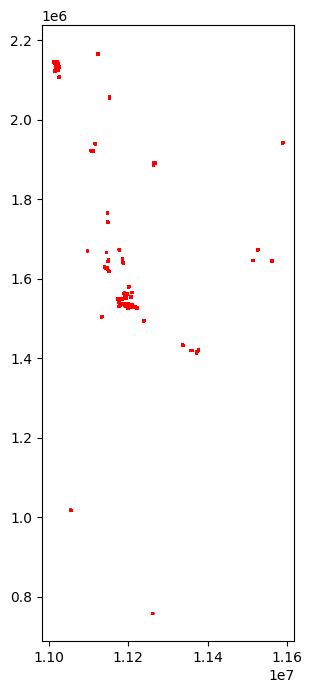

In [165]:
mly[1:500000].plot(figsize=(8,8), color='red', markersize=.5,alpha=0.5)

In [166]:
mly.head()

,image_id,compass,captured_ms,is_pano,geometry
0,3944142602359537,352.776480,1548515654000,False,POINT (11192215.430 1533928.132)
1,758823844825130,356.314080,1548515678000,False,POINT (11192181.391 1534420.195)
2,411804649930253,346.113280,1624195281000,False,POINT (11191951.483 1535453.887)
3,288785939394742,158.565680,1548497542000,False,POINT (11192269.772 1533749.580)
4,765697050795214,165.272832,1548497460000,False,POINT (11191964.023 1535465.233)


### Build per-lixel candidate images (nearest + aligned)
This step takes the Mapillary point catalogue (mly) and, for each sampling point on a lixel (samples), finds up to TOPK_PER_LIXEL nearby images that are both close and directionally aligned with the road.

In [ ]:
# sindex = mly.sindex
# cands = []
# for i, s in samples.iterrows():
#     pt = s.geometry
#     # cheap prefilter by bbox, then true distance
#     idxs = list(sindex.query(pt.buffer(SEARCH_RADIUS_M).envelope))
#     if not idxs: 
#         continue
#     loc = mly.iloc[idxs].copy()
#     loc["dist_m"] = loc.geometry.distance(pt)
#     loc = loc[loc["dist_m"] <= SEARCH_RADIUS_M]
#     if loc.empty:
#         continue
#     loc["bdiff"] = loc["compass"].apply(lambda c: bearing_diff(s["bearing"], c))
#     loc = (loc.sort_values(["bdiff","dist_m"], ascending=[True, True])
#               .head(TOPK_PER_LIXEL)
#               .assign(lixel_id=s["lixel_id"], pt_id=s["pt_id"], label=s["label"]))
#     cands.append(loc[["lixel_id","pt_id","label","image_id","dist_m","bdiff"]])

# cands = (pd.concat(cands, ignore_index=True)
#          if cands else pd.DataFrame(columns=["lixel_id","pt_id","label","image_id","dist_m","bdiff"]))
# print(f"Top-{TOPK_PER_LIXEL} candidate rows: {len(cands):,}; unique lixels covered: {cands['lixel_id'].nunique():,}")


Top-3 candidate rows: 40,998; unique lixels covered: 13,720


In [168]:
# Use only non-pano images when forming candidates
sindex = mly.sindex
cands = []

for i, s in samples.iterrows():
    pt = s.geometry

    # cheap prefilter by bbox, then true distance
    idxs = list(sindex.query(pt.buffer(SEARCH_RADIUS_M).envelope))
    if not idxs:
        continue

    loc = mly.iloc[idxs].copy()

    # filter out panoramas (require is_pano == False only)
    if "is_pano" in loc.columns:
        loc = loc[~loc["is_pano"].astype(bool)]
        if loc.empty:
            continue

    loc["dist_m"] = loc.geometry.distance(pt)
    loc = loc[loc["dist_m"] <= SEARCH_RADIUS_M]
    if loc.empty:
        continue

    loc["bdiff"] = loc["compass"].apply(lambda c: bearing_diff(s["bearing"], c))
    loc = (
        loc.sort_values(["bdiff", "dist_m"], ascending=[True, True])
           .head(TOPK_PER_LIXEL)
           .assign(lixel_id=s["lixel_id"], pt_id=s["pt_id"], label=s["label"])
    )

    # keep only needed columns downstream
    cands.append(loc[["lixel_id", "pt_id", "label", "image_id", "dist_m", "bdiff"]])

cands = (
    pd.concat(cands, ignore_index=True)
    if cands else pd.DataFrame(columns=["lixel_id", "pt_id", "label", "image_id", "dist_m", "bdiff"])
)

print(
    f"Top-{TOPK_PER_LIXEL} candidate rows: {len(cands):,}; "
    f"unique lixels covered: {cands['lixel_id'].nunique():,}"
)


Top-3 candidate rows: 39,099; unique lixels covered: 13,087


### Selecting representative Mapillary images for each lixel
This step links each 100 m road segment (lixel) to one representative Mapillary image for Vision–Language Model (VLM) analysis.
From the previous step, we already have a set of candidate images near each lixel (cands), each within a given search radius (e.g. 100 m) and directionally aligned with the road bearing.
However, not all candidate images are suitable — some may be too old, too far away, or lack a usable thumbnail.
This cell filters and finalises those associations.

Process overview

1. Fetch image metadata from the Mapillary Graph API.
For each candidate image, we query
https://graph.mapillary.com/{image_id}

to retrieve:

- the capture timestamp (captured_at), and

- a thumbnail URL (thumb_2048_url or thumb_1024_url).
The function fetch_detail() handles this process and keeps a small cache (detail_cache) so repeated requests for the same image are skipped.

2. Iterate through lixels.
For each lixel_id, candidate images are ranked by directional alignment (bdiff) and distance (dist_m).
The loop tests each candidate in order until it finds one taken within the desired time window (e.g. 2019–2024).

3. Filter by date and select the best image.
Only images whose capture date falls between start_ms and end_ms (the study period) are accepted.
Once a valid image is found, the search for that lixel stops — ensuring only one best‐matched, time‐appropriate image per lixel.

4. Store and format the results.
The chosen images are stored in a new DataFrame (one) containing:

- lixel_id — road segment ID

- image_id — Mapillary image identifier

- thumb_url — direct download link

- dist_m, bdiff — spatial alignment metrics

- captured_ms, captured_dt — timestamp (raw and formatted)

### Output summary

At the end, the script prints how many lixels were successfully matched with at least one image within the specified time window:

In [ ]:
# detail_cache = {}

# def fetch_detail(image_id):
#     """Graph API → (captured_ms, best_thumb_url) with small cache."""
#     if image_id in detail_cache:
#         return detail_cache[image_id]
#     token = next(TOK)
#     url   = f"https://graph.mapillary.com/{image_id}"
#     params= {"fields": "id,captured_at,thumb_2048_url,thumb_1024_url", "access_token": token}
#     j     = http_get(url, params=params).json()
#     cap   = j.get("captured_at")
#     # normalize to ms
#     cap_ms = None
#     if cap is not None:
#         try:
#             cap_ms = int(cap)
#         except Exception:
#             try:
#                 cap_ms = int(pd.Timestamp(cap, tz="UTC").timestamp()*1000)
#             except Exception:
#                 cap_ms = None
#     thumb = j.get("thumb_2048_url") or j.get("thumb_1024_url")
#     detail_cache[image_id] = (cap_ms, thumb)
#     return detail_cache[image_id]

# chosen = []
# for lid, grp in cands.sort_values(["lixel_id","bdiff","dist_m"]).groupby("lixel_id"):
#     row_pick = None
#     for _, r in grp.iterrows():
#         cap_ms, thumb = fetch_detail(r["image_id"])
#         if (cap_ms is not None) and (start_ms <= cap_ms <= end_ms):
#             row_pick = {
#                 "lixel_id": lid,
#                 "image_id": r["image_id"],
#                 "thumb_url": thumb,
#                 "dist_m": float(r["dist_m"]),
#                 "bdiff": float(r["bdiff"]),
#                 "captured_ms": int(cap_ms),
#             }
#             break
#     if row_pick:
#         chosen.append(row_pick)

# one = pd.DataFrame(chosen)
# one["captured_dt"] = pd.to_datetime(one["captured_ms"], unit="ms", utc=True)
# print(f"Picked in-window images: {len(one):,} / {cands['lixel_id'].nunique():,} lixels with candidates")


Picked in-window images: 13,720 / 13,720 lixels with candidates


In [211]:
# detail_cache = {}

# def fetch_detail(image_id):
#     """Graph API → (captured_ms, best_thumb_url, is_pano_bool) with small cache."""
#     if image_id in detail_cache:
#         return detail_cache[image_id]

#     token  = next(TOK)
#     url    = f"https://graph.mapillary.com/{image_id}"
#     params = {
#         "fields": "id,captured_at,thumb_2048_url,thumb_1024_url,is_pano,camera_type",
#         "access_token": token,
#     }
#     j = http_get(url, params=params).json()

#     # captured_at → milliseconds
#     cap   = j.get("captured_at")
#     cap_ms = None
#     if cap is not None:
#         try:
#             cap_ms = int(cap)  # already ms
#         except Exception:
#             try:
#                 cap_ms = int(pd.Timestamp(cap, tz="UTC").timestamp() * 1000)
#             except Exception:
#                 cap_ms = None

#     # best available thumbnail
#     thumb = j.get("thumb_2048_url") or j.get("thumb_1024_url")

#     # robust pano detection (default False if not provided)
#     pano = j.get("is_pano")
#     if pano is None:
#         pano = (j.get("camera_type") in ("spherical", "pano", "panorama"))
#     pano = bool(pano)

#     detail_cache[image_id] = (cap_ms, thumb, pano)
#     return detail_cache[image_id]

# chosen = []
# # Ensure non-pano only: prefer cands['is_pano'] when present; also double-check via Graph API.
# grouped = cands.sort_values(["lixel_id", "bdiff", "dist_m"]).groupby("lixel_id")
# for lid, grp in grouped:
#     # If the candidates already have an is_pano column, filter it here first.
#     if "is_pano" in grp.columns:
#         grp_iter = grp.loc[~grp["is_pano"].astype(bool)]
#     else:
#         grp_iter = grp

#     row_pick = None
#     for _, r in grp_iter.iterrows():
#         cap_ms, thumb, pano = fetch_detail(r["image_id"])

#         # Enforce NON-pano strictly using Graph detail as the source of truth.
#         if pano:
#             continue

#         if (cap_ms is not None) and (start_ms <= cap_ms <= end_ms):
#             row_pick = {
#                 "lixel_id":    lid,
#                 "image_id":    r["image_id"],
#                 "thumb_url":   thumb,
#                 "dist_m":      float(r["dist_m"]),
#                 "bdiff":       float(r["bdiff"]),
#                 "captured_ms": int(cap_ms),
#             }
#             break

#     if row_pick:
#         chosen.append(row_pick)

# one = pd.DataFrame(chosen)
# one["captured_dt"] = pd.to_datetime(one["captured_ms"], unit="ms", utc=True)
# print(f"Picked in-window images: {len(one):,} / {cands['lixel_id'].nunique():,} lixels with candidates")


In [170]:
# 1) Fast path: use tile-derived metadata to pre-filter BEFORE any Graph calls
#    - keep only non-pano
#    - keep only images inside the time window
#    - rank by bdiff, dist_m, then take the first per lixel

# Merge cands with mly to get captured_ms and is_pano (already computed from tiles)
meta_cols = ["image_id", "captured_ms", "is_pano"]
if not set(meta_cols).issubset(mly.columns):
    raise RuntimeError("mly must contain 'image_id', 'captured_ms', and 'is_pano' columns.")

cands_meta = (
    cands.merge(mly[meta_cols], on="image_id", how="left", validate="m:1")
)

# Enforce non-pano + in-window using tile metadata
cm = cands_meta.copy()
cm["is_pano"] = cm["is_pano"].fillna(False).astype(bool)  # treat missing as non-pano=False
cm = cm[~cm["is_pano"]]                                   # only non-pano
cm = cm[cm["captured_ms"].notna()]                        # need a timestamp to filter
cm = cm[(cm["captured_ms"] >= start_ms) & (cm["captured_ms"] <= end_ms)]

# If nothing remains (rare), fall back to your original per-candidate loop
if cm.empty:
    print("No in-window, non-pano candidates from tile metadata; falling back to Graph detail loop…")
    detail_cache = {}
    chosen = []
    grouped = cands.sort_values(["lixel_id", "bdiff", "dist_m"]).groupby("lixel_id")
    for lid, grp in grouped:
        row_pick = None
        for _, r in grp.iterrows():
            cap_ms, thumb, pano = fetch_detail(r["image_id"])
            if pano:
                continue
            if (cap_ms is not None) and (start_ms <= cap_ms <= end_ms):
                row_pick = {
                    "lixel_id":    lid,
                    "image_id":    r["image_id"],
                    "thumb_url":   thumb,
                    "dist_m":      float(r["dist_m"]),
                    "bdiff":       float(r["bdiff"]),
                    "captured_ms": int(cap_ms),
                }
                break
        if row_pick:
            chosen.append(row_pick)
else:
    # 2) Rank and take best per lixel WITHOUT any Graph calls
    cm = cm.sort_values(["lixel_id", "bdiff", "dist_m"], ascending=[True, True, True])

    # first per-lixel pick using tile metadata
    first_idx = cm.groupby("lixel_id", as_index=False).head(1).index
    picks = cm.loc[first_idx, ["lixel_id", "image_id", "dist_m", "bdiff", "captured_ms"]].copy()

    # 3) Fetch thumbnails (and double-check non-pano) ONLY for the picked rows
    chosen = []
    for _, r in picks.iterrows():
        cap_ms, thumb, pano = fetch_detail(r["image_id"])

        # Hard-enforce non-pano = False with Graph detail as source of truth
        if pano:
            continue

        # If Graph returned a better timestamp, keep it; otherwise keep tile one
        use_ms = int(cap_ms) if cap_ms is not None else int(r["captured_ms"])

        # Re-check time window (in case Graph timestamp differs from tile)
        if (use_ms is not None) and (start_ms <= use_ms <= end_ms):
            chosen.append({
                "lixel_id":    int(r["lixel_id"]),
                "image_id":    r["image_id"],
                "thumb_url":   thumb,
                "dist_m":      float(r["dist_m"]),
                "bdiff":       float(r["bdiff"]),
                "captured_ms": use_ms,
            })

# 4) Final frame
one = pd.DataFrame(chosen)
if not one.empty:
    one["captured_dt"] = pd.to_datetime(one["captured_ms"], unit="ms", utc=True)

print(
    f"Picked in-window images: {len(one):,} / {cands['lixel_id'].nunique():,} lixels with candidates"
)


Picked in-window images: 13,087 / 13,087 lixels with candidates


In [171]:
one

,lixel_id,image_id,thumb_url,dist_m,bdiff,captured_ms,captured_dt
0,6,2112948935523246,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,96.210660,0.502860,1640912525495,2021-12-31 01:02:05.495000+00:00
1,7,313315203723196,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,87.980704,0.016862,1561624933454,2019-06-27 08:42:13.454000+00:00
2,8,523484282192422,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,31.794624,34.057894,1642830387299,2022-01-22 05:46:27.299000+00:00
3,9,3526462137454913,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,9.001881,0.021117,1574910329692,2019-11-28 03:05:29.692000+00:00
4,10,2626794384286060,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,96.978416,0.013082,1574910385621,2019-11-28 03:06:25.621000+00:00
...,...,...,...,...,...,...,...
13082,28743,411145704308975,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,2.457734,82.877994,1654142120000,2022-06-02 03:55:20+00:00
13083,28745,419041199856206,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,38.715133,0.133559,1634359391224,2021-10-16 04:43:11.224000+00:00
13084,28747,164769642260133,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,25.036491,85.995841,1552754040200,2019-03-16 16:34:00.200000+00:00
13085,28748,833176024211194,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,93.896055,79.443797,1555835378000,2019-04-21 08:29:38+00:00


In [173]:
# Attach labels (hotspot/control) or anything else you need from gt
mini = gt[["lixel_id","label","all_label","motorcycle_label","density_bw200","ref"]].copy().drop_duplicates()
one  = one.merge(mini, on="lixel_id", how="left")

# Save
one.to_csv(CHOSEN_CSV, index=False)
gpd.GeoDataFrame(one.merge(
    mly[["image_id","geometry"]].drop_duplicates("image_id"),
    on="image_id", how="left"),
    crs=3857
).to_crs(4326).to_file(CHOSEN_GEOJSON, driver="GeoJSON")

print("Wrote:", CHOSEN_CSV, "and", CHOSEN_GEOJSON)


Wrote: ./svi_out_new/mapillary_chosen.csv and ./svi_out_new/mapillary_chosen.geojson


In [174]:
one = one.merge(gt[['lixel_id', 'geometry']], on='lixel_id', how='left')

In [175]:
one

,lixel_id,image_id,thumb_url,dist_m,bdiff,captured_ms,captured_dt,label,all_label,motorcycle_label,density_bw200,ref,geometry
0,6,2112948935523246,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,96.210660,0.502860,1640912525495,2021-12-31 01:02:05.495000+00:00,control,med,low,0.000000e+00,126,"LINESTRING (11170011.406 1903148.977, 11169907..."
1,7,313315203723196,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,87.980704,0.016862,1561624933454,2019-06-27 08:42:13.454000+00:00,control,low,lowest,0.000000e+00,11,"LINESTRING (11023736.163 2128573.963, 11023750..."
2,8,523484282192422,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,31.794624,34.057894,1642830387299,2022-01-22 05:46:27.299000+00:00,hotspot,low,med,3.375198e-04,1366,"LINESTRING (11018631.270 2133441.172, 11018615..."
3,9,3526462137454913,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,9.001881,0.021117,1574910329692,2019-11-28 03:05:29.692000+00:00,control,med,high,4.687489e-05,1006,"LINESTRING (11032691.396 2125639.624, 11032643..."
4,10,2626794384286060,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,96.978416,0.013082,1574910385621,2019-11-28 03:06:25.621000+00:00,hotspot,med,high,2.203131e-04,1006,"LINESTRING (11031996.524 2125951.741, 11031937..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13082,28743,411145704308975,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,2.457734,82.877994,1654142120000,2022-06-02 03:55:20+00:00,control,None,None,0.000000e+00,None,"LINESTRING (11688912.227 1716784.520, 11688944..."
13083,28745,419041199856206,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,38.715133,0.133559,1634359391224,2021-10-16 04:43:11.224000+00:00,control,None,None,3.517550e-07,None,"LINESTRING (11025862.673 2110279.516, 11025859..."
13084,28747,164769642260133,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,25.036491,85.995841,1552754040200,2019-03-16 16:34:00.200000+00:00,hotspot,None,None,1.715478e-04,None,"LINESTRING (11249562.930 1535156.351, 11249655..."
13085,28748,833176024211194,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,93.896055,79.443797,1555835378000,2019-04-21 08:29:38+00:00,hotspot,None,None,1.718028e-04,None,"LINESTRING (11181522.487 1549045.776, 11181523..."


In [177]:
one['label'].value_counts()

label
hotspot    7041
control    6046
Name: count, dtype: int64

In [22]:
if not DRY_RUN:
    dl = one.head(DOWNLOAD_RESOLVE_N).copy()
    saved = 0
    for _, r in dl.iterrows():
        u = r["thumb_url"]
        if not u: 
            continue
        path = os.path.join(IMAGES_DIR, f"{r['image_id']}.jpg")
        if os.path.exists(path):
            continue
        try:
            resp = http_get(u, stream=True)
            with open(path, "wb") as fh:
                for chunk in resp.iter_content(chunk_size=1<<16):
                    if chunk: fh.write(chunk)
            saved += 1
        except Exception as e:
            print("Download error:", r["image_id"], e)
    print(f"Downloaded {saved} images → {IMAGES_DIR}")
else:
    print("DRY_RUN=True — skipping downloads")


DRY_RUN=True — skipping downloads


In [178]:
# one_test = one['all_label'] not NA
one_test = one[one['all_label'].notna()]
one_test.shape

(10644, 13)

In [214]:
one_test['hotspot_control'].value_counts()

hotspot_control
hotspot    5742
control    4902
Name: count, dtype: int64

In [181]:
# get province name from province shapefile
prov = gpd.read_file(
    "/Users/stupong/Desktop/ThaiRAP/osm/tha_adm_rtsd_itos_20210121_shp/tha_admbnda_adm1_rtsd_20220121.shp"
).to_crs(gt.crs)

In [182]:
import geopandas as gpd

# 1) Make sure both are GeoDataFrames and geometry is set
if not isinstance(one_test, gpd.GeoDataFrame):
    one_test = gpd.GeoDataFrame(one_test, geometry='geometry')

if not isinstance(prov, gpd.GeoDataFrame):
    prov = gpd.GeoDataFrame(prov, geometry='geometry')

# 2) Align CRS
if one_test.crs != prov.crs:
    one_test = one_test.to_crs(prov.crs)

# 3) Spatial join: points within provinces
joined = gpd.sjoin(
    one_test,
    prov[['ADM1_EN', 'geometry']],
    how='left',
    predicate='within'  # or 'intersects' if you want boundary-touching too
)

# 4) Bring the province name back to your original frame
one_test['province'] = joined['ADM1_EN']


In [183]:
# rename one_test['label_x'] to one_test['hotspot_control']
one_test = one_test.rename(columns={'label': 'hotspot_control'})

In [184]:
# change point to lat lon columns and remove ['point'] change to wgs84
one_test = one_test.to_crs("EPSG:4326")
one_test['point'] = one_test.geometry.centroid
one_test['lat'] = one_test['point'].y
one_test['lon'] = one_test['point'].x
one_test = one_test.drop(columns=['point'])


/var/folders/08/36_394xj1plgkpr172kjs8mr0000gn/T/ipykernel_26478/3252477196.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  one_test['point'] = one_test.geometry.centroid


In [185]:
one_test

,lixel_id,image_id,thumb_url,dist_m,bdiff,captured_ms,captured_dt,hotspot_control,all_label,motorcycle_label,density_bw200,ref,geometry,province,lat,lon
0,6,2112948935523246,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,96.210660,0.502860,1640912525495,2021-12-31 01:02:05.495000+00:00,control,med,low,0.000000,126,"LINESTRING (100.34192 16.84809, 100.34099 16.8...",Phitsanulok,16.848243,100.341454
1,7,313315203723196,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,87.980704,0.016862,1561624933454,2019-06-27 08:42:13.454000+00:00,control,low,lowest,0.000000,11,"LINESTRING (99.02791 18.77594, 99.02803 18.77502)",Chiang Mai,18.775478,99.027970
2,8,523484282192422,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,31.794624,34.057894,1642830387299,2022-01-22 05:46:27.299000+00:00,hotspot,low,med,0.000338,1366,"LINESTRING (98.98205 18.81733, 98.98191 18.81727)",Chiang Mai,18.817301,98.981978
3,9,3526462137454913,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,9.001881,0.021117,1574910329692,2019-11-28 03:05:29.692000+00:00,control,med,high,0.000047,1006,"LINESTRING (99.10835 18.75098, 99.10792 18.751...",Chiang Mai,18.751186,99.107915
4,10,2626794384286060,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,96.978416,0.013082,1574910385621,2019-11-28 03:06:25.621000+00:00,hotspot,med,high,0.000220,1006,"LINESTRING (99.10211 18.75363, 99.10158 18.753...",Chiang Mai,18.753827,99.101666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11057,25387,1102523713571306,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,24.961432,0.044695,1562564899500,2019-07-08 05:48:19.500000+00:00,hotspot,low,low,0.000226,323,"LINESTRING (99.49120 14.06384, 99.49188 14.06408)",Kanchanaburi,14.063964,99.491541
11058,25399,489030755765164,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,3.621976,17.407772,1565279803000,2019-08-08 15:56:43+00:00,hotspot,lowest,lowest,0.000158,214,"LINESTRING (103.40819 14.63158, 103.40804 14.6...",Surin,14.631791,103.408116
11059,25400,998673464231068,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,13.426301,0.003763,1627548960466,2021-07-29 08:56:00.466000+00:00,hotspot,highest,high,0.000241,34,"LINESTRING (101.00036 13.42433, 100.99969 13.4...",Chon Buri,13.423966,101.000023
11060,25401,1196103267876523,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,4.395777,90.246895,1653963952500,2022-05-31 02:25:52.500000+00:00,control,low,low,0.000000,24,"LINESTRING (104.41154 14.68629, 104.41098 14.6...",Si Sa Ket,14.686293,104.411021


In [ ]:
# save one_test to geopackage
one_test.to_file("result/hotspot_control_new.gpkg", driver="GPKG")
print(f"✅ Saved GeoPackage with provinces: result/hotspot_control_new.gpkg")

✅ Saved GeoPackage with provinces: result/hotspot_control.gpkg


In [207]:
# Ensure output folder exists and save as CSV (to_file uses Fiona/drivers and causes FionaCPLError for CSV)
os.makedirs("result", exist_ok=True)
one_test.to_csv("result/hotspot_control_new.csv", index=False)
print("Saved CSV: result/hotspot_control_new.csv")

Saved CSV: result/hotspot_control_new.csv


# V-RoAst
This part will use V-RoAst framwork with Gemini-2.5-flash https://deepmind.google/models/gemini/flash/

https://ai.google.dev/pricing
### Free of charge*
### Rate Limits**
- 15 RPM (requests per minute)
- 1 million TPM (tokens per minute)
- 1,500 RPD (requests per day)

### Price (input)
- Free of charge

### Context caching
- Free of charge, up to 1 million tokens of storage per hour

### Price (output)
- Free of charge

### Prompts/responses used to improve our products
- Yes

In [2]:
import os
import pandas as pd
import PIL.Image
import json
import google.generativeai as genai
from io import StringIO
from dotenv import load_dotenv
from google.auth.transport.requests import Request
from google.oauth2 import service_account
import random
import typing_extensions as typing
import tqdm

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [187]:
import geopandas as gpd

# Read geopackage — use read_file and ensure gpd is available if this cell is run independently
one_test = gpd.read_file("result/hotspot_control_new.gpkg")
# one = pd.read_csv("result/hotspot_control.csv")

In [215]:
one_test['thumb_url']

0        https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...
1        https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...
2        https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...
3        https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...
4        https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...
                               ...                        
10639    https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...
10640    https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...
10641    https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...
10642    https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...
10643    https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...
Name: thumb_url, Length: 10644, dtype: object

In [496]:
load_dotenv('google_key.env')

# Access the keys
api_keys = [
    os.getenv('GOOGLE_API_KEY_18'),
    os.getenv('GOOGLE_API_KEY_17'),
    os.getenv('GOOGLE_API_KEY_14'),
    os.getenv('GOOGLE_API_KEY_12'),
    os.getenv('GOOGLE_API_KEY_11'),
    os.getenv('GOOGLE_API_KEY_10'),
    os.getenv('GOOGLE_API_KEY_9'),
    os.getenv('GOOGLE_API_KEY_8'),
    os.getenv('GOOGLE_API_KEY_7'),
    os.getenv('GOOGLE_API_KEY_6'),
    os.getenv('GOOGLE_API_KEY_5'),
    os.getenv('GOOGLE_API_KEY_4'),
    os.getenv('GOOGLE_API_KEY_3'),
    # os.getenv('GOOGLE_API_KEY_2'),
    os.getenv('GOOGLE_API_KEY_1'),
    # os.getenv('GOOGLE_API_KEY_13'),
    os.getenv('GOOGLE_API_KEY_15'),
    # os.getenv('GOOGLE_API_KEY_16'),
]

### Check if all keys are working

In [504]:
import google.generativeai as genai

def test_api_key(key, model_name="gemini-2.5-flash"):
    """Return True if the key works, False otherwise."""
    try:
        genai.configure(api_key=key)
        model = genai.GenerativeModel(model_name)
        response = model.generate_content("ping")
        if response and hasattr(response, "text"):
            print(f"✅  Key OK: {key[:12]}... — {model_name}")
            return True
        else:
            print(f"⚠️  Key {key[:12]}... returned no text.")
            return False
    except Exception as e:
        print(f"❌  Key {key[:12]}... failed: {e}")
        return False

# --- run the check for all keys ---
valid_keys = []
for key in api_keys:
    if key:
        if test_api_key(key):
            valid_keys.append(key)
    else:
        print("⚠️  Missing key in .env file.")

print(f"\nSummary: {len(valid_keys)} / {len(api_keys)} keys working.")


E0000 00:00:1763290695.636141 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  Key OK: AIzaSyBpfhEI... — gemini-2.5-flash


E0000 00:00:1763290697.313887 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  Key OK: AIzaSyB2z4dA... — gemini-2.5-flash


E0000 00:00:1763290698.533246 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  Key OK: AIzaSyBeptl_... — gemini-2.5-flash


E0000 00:00:1763290699.909448 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  Key OK: AIzaSyC6t8dE... — gemini-2.5-flash


E0000 00:00:1763290701.061440 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  Key OK: AIzaSyDhWff5... — gemini-2.5-flash


E0000 00:00:1763290702.596676 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  Key OK: AIzaSyCOciZT... — gemini-2.5-flash


E0000 00:00:1763290704.166919 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  Key OK: AIzaSyCVOx04... — gemini-2.5-flash


E0000 00:00:1763290705.540980 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  Key OK: AIzaSyC-MD5_... — gemini-2.5-flash


E0000 00:00:1763290706.945874 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  Key OK: AIzaSyAEWCHM... — gemini-2.5-flash


E0000 00:00:1763290708.261331 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  Key OK: AIzaSyBBmody... — gemini-2.5-flash


E0000 00:00:1763290709.545588 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  Key OK: AIzaSyB_BBN_... — gemini-2.5-flash


E0000 00:00:1763290710.733586 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  Key OK: AIzaSyAvoNH4... — gemini-2.5-flash


E0000 00:00:1763290712.086703 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  Key OK: AIzaSyAeCpGn... — gemini-2.5-flash


E0000 00:00:1763290713.397521 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  Key OK: AIzaSyAyjYIc... — gemini-2.5-flash


E0000 00:00:1763290714.776288 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  Key OK: AIzaSyDMlAhD... — gemini-2.5-flash

Summary: 15 / 15 keys working.


## Instruction (text input)
You can experiment with 'local_context' and change 'country'

In [7]:
fields = [
    "image_id",
    # "Carriageway",
    # "Upgrade cost",
    # "Motorcycle observed flow",
    # "Bicycle observed flow",
    # "Pedestrian observed flow across the road",
    # "Pedestrian observed flow along the road driver-side",
    # "Pedestrian observed flow along the road passenger-side",
    # "Land use - driver-side",
    # "Land use - passenger-side",
    # "Area type",
    # "Speed limit",
    # "Motorcycle speed limit",
    # "Truck speed limit",
    "Differential speed limits",
    "Median type",
    "Centreline rumble strips",
    "Roadside severity - driver-side distance",
    "Roadside severity - driver-side object",
    "Roadside severity - passenger-side distance",
    "Roadside severity - passenger-side object",
    "Shoulder rumble strips",
    "Paved shoulder - driver-side",
    "Paved shoulder - passenger-side",
    "Intersection type",
    "Intersection channelisation",
    # "Intersecting road volume",
    "Intersection quality",
    "Property access points",
    "Number of lanes",
    "Lane width",
    "Curvature",
    "Quality of curve",
    "Grade",
    "Road condition",
    "Skid resistance / grip",
    "Delineation",
    "Street lighting",
    # "Pedestrian crossing facilities - inspected road",
    # "Pedestrian crossing quality",
    # "Pedestrian crossing facilities - intersecting road",
    # "Pedestrian fencing",
    "Speed management / traffic calming",
    # "Vehicle parking",
    # "Sidewalk - driver-side",
    # "Sidewalk - passenger-side",
    "Service road",
    "Facilities for motorised two wheelers",
    # "Facilities for bicycles",
    # "Roadworks",
    "Sight distance",
    # "School zone warning",
    # "School zone crossing supervisor"
]

In [8]:
# Add the local context to the input data
country = "//country//"
local_context = "//local_context//"

# country and local_context that we used in the experiment
country = "Thailand"
# local_context = "Speed limits in " + country + " are a set of maximum speeds that apply to all roads in the country. For <Attribute> = 'Speed limit', the maximum limits are as follows: 80 km/h within built-up areas and in Bangkok, 90 km/h outside built-up areas, and 120 km/h on motorways.\nFor the <Attribute> = 'Motorcycle speed limit', the limits are 80 km/h in Bangkok and other provinces' built-up areas, and 90 km/h on other highways (motorcycles are not allowed on motorways). For the <Attribute> = 'Truck speed limit', the limits are 60 km/h in Bangkok and other provinces' built-up areas, 80 km/h on highways, and 100 km/h on motorways. <Attribute>: Carriageway answer should be Divided carriageway= 'Carriageway A of a divided road'.\nFor highways in Thailand <Attribute> 'Lane width' is 'Wide \u22653.25m'. Moreover, <Attribute>: 'Area type' in Bangkok and Phatum thani should be 'Urban'; therefore, <Attribute>: 'Upgrade cost' should be 'High' and <Attribute>: 'Street lighting' should be 'Present' in Bangkok and Phatum thani area.\nThe common <Attribute>: Roadside severity - driver-side object are 'Safety barrier - concrete' and 'Safety barrier - metal' that should carefully look at the image. The common <Attribute>: Roadside severity - passenger-side object are 'Safety barrier - concrete', 'Safety barrier - metal', 'Rigid sign, post or pole \u226510cm' and 'Unprotected safety barrier end' that should carefully look at the image. In Thailand highway, there should not be 'No object' for <Attribute>: Roadside severity - passenger-side object and <Attribute>: Roadside severity - driver-side object."

local_context = (
    "DRIVING SIDE: Thailand drives on the LEFT. "
    "SIDE DEFINITIONS:\n"
    "• In forward-facing images (camera looking along the traffic flow), PASSENGER-SIDE is the LEFT of the image and DRIVER-SIDE is the RIGHT.\n"
    "• If the camera is clearly looking backwards, invert the sides.\n"
    "• If direction is ambiguous, assume forward-facing and do not mirror the sides.\n\n"
    "IMAGE CLARITY: If the image is night/low-light or too unclear to code reliably, return only "
    '{"image_id":"...", "unclear_image": true} and omit all attributes.\n\n'
    "SPEED LIMITS: Do NOT infer numerical speed limits from location or typical national values. "
    "Only record speed limit fields if a speed sign is clearly visible and legible in the image; otherwise leave them blank/unknown. "
    "Differential speed limits must be derived from those visible speed signs; do not assume differences without evidence.\n\n"
    "SIDE INDEPENDENCE: Driver-side and passenger-side attributes are independent; do not copy one side to the other.\n\n" 
    "For highways in Thailand <Attribute> 'Lane width' is 'Wide \u22653.25m'. Rural highways are typically 'Wide \u22653.25m' as well."
    "Rigid sign, post or pole ≥10cm and Tree ≥10cm are common for <Attribute>: Roadside severity - passenger-side object and <Attribute>: Roadside severity - driver-side object.\n\n"
    "Roadside severity - passenger-side distance are commonly 1 to <5m and Roadside severity - driver-side distance are commonly 0 to <1m.\n\n"
)


# checking again with prompts
 Model สับสน Passenger/ Driver side?
 Paved shoulder - driver-side	Paved shoulder - passenger-side ไม่จำเป็นต้องเหมือนกัน

In [ ]:
# make sure the json file is in the correct path
json_file = 'V-RoAst//text//prompts.json'

def format_attributes_to_json(json_file, image_id="image_id", keep_fields=None):
    """
    Load the attribute JSON but keep only the fields listed in `keep_fields`.
    """
    with open(json_file, "r", encoding="utf-8") as f:
        data = json.load(f)

    keep_fields = keep_fields or []  # fallback if None
    keep_set = set(keep_fields) - {"image_id"}

    formatted_data = {"image_id": image_id}

    for attribute in data["attributes"]:
        item_name = attribute.get("Item", "Unknown Item")
        if item_name not in keep_set:
            continue
        categories = [
            cat.get("Category", "Unknown Category")
            for cat in attribute.get("categories", [])
        ]
        formatted_data[item_name] = categories

    return json.dumps(formatted_data, indent=4, ensure_ascii=False)

# Use it like this:
output_json = format_attributes_to_json(json_file, keep_fields=fields)

# Prompt instruction >> need to skip images at night or unclear images (flag as 'unclear image') + no 360 images
prompt_instruction = f"""
You are a road safety assessment coder from the International Road Assessment Programme (iRAP). Your task is to analyse images of road sections taken in {country} and accurately assess 27 road safety attributes. For each attribute, follow these steps:
1. Flag Unclear Images: If the image is taken at night or is otherwise unclear, flag it as 'unclear image' and do not assess any attributes.
2. Analyse the Image: Examine the road section in the image, focusing on all relevant elements that correspond to the 27 '<Attribute>'s you need to assess.
3. Read the <Attribute Description>: For each of the 27 attributes, read the '<Attribute description>' to understand what specific aspect of the image you need to evaluate.
4. Refer to Categories: For each attribute, refer to the possible '<Category class>' options provided. If a '<Category description>' is available, read it to understand the specific criteria for each category.
5. Select the Most Matching Category: Based on your analysis of the image and understanding of the attribute and category descriptions, select the single <Category class> that best matches what you observe in the image. If multiple categories are equally relevant, choose the category that appears first in the provided list.
6. Output the Results in JSON Format: Return the results in JSON format, with each attribute associated with a single <Category class> value that you assess to be the most appropriate based on the image.

Local context:
Please use <location> to understand the local context. '<driver-side>' and '<passenger-side>' are used throughout the <Attribute> and <Attribute description>. Driver-side refers to the side of the road corresponding with the driver of a vehicle travelling in the direction of the survey, and the passenger-side is the other side. If the country drives on the left (e.g., the UK), the passenger side is on the left of the image, and the driver side is on the right of the image. {local_context}
"""

output_format = f"""
Output Format: Return the results in JSON format, where each attribute is associated with a single <Category class> value that best matches your analysis of the image. If multiple categories seem equally relevant, select the category that appears first in the provided list.

JSON structure:
{output_json}
Ensure that each attribute in the JSON output contains only one selected <Category class> that you determine to be the most appropriate based on the image.
"""

In [ ]:
# prompt_instruction = f"""
# You are a road safety assessment coder from the International Road Assessment Programme (iRAP).
# Your task is to analyse forward-facing images of road sections in Thailand and select exactly ONE
# <Category class> for each of 27 attributes. Use only visible evidence in the image.

# WORKFLOW
# 1) Flag Unclear Images:
#    If the image is night/low-light, blurry, over/under-exposed, rain/fog; OR the road is obstructed;
#    OR the view is a partial/side/rear view so that the full carriageway (both edges or median area)
#    cannot be judged reliably → return only: {{"image_id": "...", "unclear_image": true}}
#    and do NOT assess attributes.

# 2) Analyse the Image:
#    Examine all relevant road/roadside elements required by each <Attribute>.

# 3) Read and Apply Attribute Rules:
#    For each <Attribute>, read its <Attribute description> and allowed <Categories>. Follow
#    the attribute-specific rules exactly.

# 4) Select ONE Category:
#    Choose the single <Category class> that BEST matches visible evidence. If two are truly equal,
#    pick the FIRST in that attribute’s category list.

# 5) Local Context (Thailand, LEFT-hand traffic):
#    • Thailand drives on the LEFT. In a forward-facing image: PASSENGER-SIDE = LEFT, DRIVER-SIDE = RIGHT.
#    • If the camera is clearly facing backward, invert sides; if ambiguous, assume forward-facing.
#    • SIDE INDEPENDENCE: Do NOT copy passenger-side to driver-side or vice versa.

# 6) Evidence Only (No Guessing):
#    Do NOT infer features that are not visible (e.g., continuation behind vehicles, features outside frame).
#    If uncertain, choose the least-risky visible category (e.g., “_None_”, “No object”, “Not present”).

# VISUAL ESTIMATION GUIDELINES (tie-break aids, not hard priors)
# • Lane width (quick visual rule of thumb):
#   – Car fits with clear margins → “Wide ≥3.25m”
#   – Car fits but looks snug → “Medium 2.75m to <3.25m”
#   – Car looks tight/encroached → “Narrow 0m to <2.75m”
# • Median type (marking width as fraction of lane width):
#   – < ~10% → “Centre line”; ~10–30% → “Wide centre line 0.3–1m”; > ~30% → “Central hatching >1m”
#   – Any continuous raised/curbed divider → select the appropriate Physical median / Safety barrier class.
# • Paved shoulder (edge line logic):
#   – If an edge line is visible, paved shoulder is at least “Narrow 0–<1m”.
#   – Gap from edge line to paved edge: ~0–0.3 lane-width → Narrow; ~0.3–0.75 → Medium; >0.75 → Wide.
# • Roadside distance (use ~1.8 m car width as a ruler):
#   – 0–<1 m ≈ ≤0.5 car-width; 1–<5 m ≈ 0.5–2 car-widths; 5–<10 m ≈ 2–4; ≥10 m >4.
# • Roadside object choice:
#   – If multiple hazards exist, choose the one (a) closest to the lane edge OR (b) highest in iRAP risk hierarchy.

# SOFT THAI PRIORS (tie-breaks only; do NOT override evidence)
# • Highways/rural highways often have “Wide ≥3.25m” lanes.
# • Rigid posts/poles ≥10 cm and trees ≥10 cm are common roadside objects.
# • Roadside distances of 1–<5 m (passenger-side) and 0–<1 m (driver-side) are common.

# INTERNAL CONSISTENCY CHECKS (apply before output)
# • If “Median type” is any divided category (physical median or barrier), then
#   “Centreline rumble strips” must be “Not present”.
# • If “Paved shoulder = _None_” but an edge line is visible (or “Delineation = Adequate”),
#   set the paved shoulder to at least “Narrow 0m to <1m”.
# • Driver/passenger attributes must be coded independently (no mirroring).

# SPEED LIMITS
# • Do NOT infer numbers from country norms. Record speed-limit attributes ONLY when a sign is visible and legible.
# • Differential speed limits must be computed from the three visible speed-limit fields.

# Local context:
# Please use <location> to understand the local context. '<driver-side>' and '<passenger-side>' are used throughout the <Attribute> and <Attribute description>. Driver-side refers to the side of the road corresponding with the driver of a vehicle travelling in the direction of the survey, and the passenger-side is the other side. If the country drives on the left (e.g., the UK), the passenger side is on the left of the image, and the driver side is on the right of the image. {local_context}

# OUTPUT FORMAT (JSON only; one value per attribute)
# • Return valid JSON with:
#   – "image_id": "<id>"
#   – Each attribute key mapping to EXACTLY ONE selected <Category class> string.
# • No lists, confidences, markdown, or extra commentary in the JSON.
# • If unclear image: return only {{"image_id":"...", "unclear_image": true}}.
# """


In [ ]:
prompt_instruction = f"""
You are a road safety assessment coder from the International Road Assessment Programme (iRAP).
Your task is to analyse forward-facing images of road sections in Thailand and select exactly ONE
<Category class> for each of 27 attributes. Use only visible evidence in the image.

WORKFLOW

1) Analyse the Image:
   Examine all relevant road and roadside elements required by each <Attribute>.

2) Apply Attribute Rules:
   For each <Attribute>, read its <Attribute description> and allowed <Categories>. 
   Follow the attribute-specific rules exactly.

3) Select ONE Category:
   Choose the single <Category class> that BEST matches visible evidence. 
   If two are truly equal, pick the FIRST in that attribute’s category list.

4) Local Context (Thailand, LEFT-hand traffic):
   • Thailand drives on the LEFT.
   • In a forward-facing image: PASSENGER-SIDE = LEFT, DRIVER-SIDE = RIGHT.
   • If the camera is clearly facing backward, invert sides.
   • If ambiguous, assume forward-facing.
   • SIDE INDEPENDENCE: Do NOT copy passenger-side to driver-side or vice versa.

5) Evidence Only (No Guessing):
   Do NOT infer features that are not visible (e.g., continuation behind vehicles or outside frame).
   If uncertain between two valid categories, choose the more physically evident or larger-scale category.
  Do NOT default to ‘Not present’ or ‘Centre line’ unless clearly visible as such.

VISUAL ESTIMATION GUIDELINES (tie-break aids, not hard priors)
• Lane width:
  – Car fits with clear margins → “Wide ≥3.25m” (Thailand highways/rural highways often have this).
  – Car fits but looks snug → “Medium 2.75m to <3.25m” (some rural highways have this).
  – Car looks tight/encroached → “Narrow 0m to <2.75m”
• Median type:
  – <10% lane width → “Centre line”; ~10–30% → “Wide centre line 0.3–1m”; >30% → “Central hatching >1m”
  – Any continuous raised or curbed divider → choose the appropriate Physical median / Safety barrier class.
  - If any continuous physical divider, guardrail, curb, or vegetation strip separates traffic directions → choose a ‘Physical median …’ or ‘Safety barrier …’ category (not ‘Centre line’). Only use ‘Centre line’ when no physical divider is visible and opposing traffic flows share the same pavement surface.
• Paved shoulder:
  – If an edge line is visible, paved shoulder is at least “Narrow 0–<1m”.
  – Gap from edge line to paved edge: ~0–0.3 lane-width → Narrow; ~0.3–0.75 → Medium; >0.75 → Wide.
• Roadside distance (use ~1.8 m car width as a ruler):
  – 0–<1 m ≈ ≤0.5 car-width; 1–<5 m ≈ 0.5–2 car-widths; 5–<10 m ≈ 2–4; ≥10 m >4.
• Roadside object:
  – If multiple hazards exist, choose the one (a) closest to the lane edge OR (b) highest in iRAP risk hierarchy.
• Number of lanes:
  - If a median, barrier, or wide vegetated strip is visible between traffic flows, infer two or more lanes per direction even if full markings are not visible.
  - If only a single carriageway is visible with no divider, estimate total lanes using visible width or vehicle positions.
  - Do not assume every road is two lanes. Some Thai highways have 4–6 lanes, often divided by a median or barrier.

INTERNAL CONSISTENCY CHECKS (apply before output)
• If “Median type” is any divided category (physical median or barrier), then
  “Centreline rumble strips” must be “Not present”.
• If “Paved shoulder = _None_” but an edge line is visible (or “Delineation = Adequate”),
  set the paved shoulder to at least “Narrow 0m to <1m”.
• Driver/passenger attributes must be coded independently (no mirroring).

SPEED LIMITS
• Do NOT infer numbers from country norms. Record speed-limit attributes ONLY when a sign is visible and legible.
• Differential speed limits must be computed from the three visible speed-limit fields.

SIDES SUMMARY:
Driver-side refers to the side of the road corresponding with the driver of a vehicle travelling in the survey direction.
Passenger-side is the opposite side. For Thailand (LEFT-hand traffic), passenger-side = LEFT, driver-side = RIGHT.
If backward-facing, invert; if ambiguous, assume forward-facing.

EVIDENCE PRIORITY:
Choose what is visible and measurable. Do not rely on local expectations or national norms.

OUTPUT FORMAT (JSON only; one value per attribute)
• Return valid JSON with:
  – "image_id": "<id>"
  – Each attribute key mapping to EXACTLY ONE selected <Category class> string.
• No lists, confidences, markdown, or extra commentary.
• Example:
{{
  "image_id": "1497271934633484",
  "Median type": "Centre line",
  "Number of lanes": "Two",
  "Paved shoulder - driver-side": "Narrow 0m to <1m",
  ...
}}
• If unclear image: return only {{"image_id": "...", "unclear_image": true}}.
"""


In [10]:
def json2text_filtered(json_file,
                       keep_fields,
                       include_attribute_description=True,
                       include_category_description=True,
                       strict=False):
    """
    Build the instruction text for ONLY the attributes in `keep_fields`
    (order preserved). `image_id` is ignored if present in keep_fields.
    """
    keep = [f for f in keep_fields if f != "image_id"]
    keep_set = set(keep)

    with open(json_file, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # Map item name -> full attribute object from the source JSON
    attr_map = {a.get('Item', ''): a for a in data.get('attributes', []) if a.get('Item')}

    missing = [name for name in keep if name not in attr_map]
    if missing:
        msg = f"[json2text_filtered] WARNING: {len(missing)} names in `fields` not found in JSON: {missing[:5]}{' ...' if len(missing)>5 else ''}"
        print(msg)
        if strict:
            raise KeyError(msg)

    formatted = []
    idx = 0
    for name in keep:
        a = attr_map.get(name)
        if not a:
            continue  # skip missing, already warned
        idx += 1
        item = a.get('Item', 'Unknown Item')
        desc = a.get('Attribute description', 'No description available.')

        if idx > 1:
            formatted.append("")  # blank line between items

        formatted.append(f"{idx}. <Attribute>: {item}")
        if include_attribute_description:
            formatted.append(f"<Attribute description>: {desc}")

        # category list (short form)
        cats = a.get('categories', []) or []
        cat_names = [c.get('Category', 'Unknown Category') for c in cats]
        formatted.append(f"<Categories>: [{', '.join(cat_names)}]")

        # category details (optional)
        if include_category_description:
            for c in cats:
                cid = c.get('Category', 'N/A')
                cdesc = c.get('Category_description', '')
                if cdesc:
                    formatted.append(f" <Category class>: {cid}, <Category description>: {cdesc}")
                else:
                    formatted.append(f" <Category class>: {cid}")

    return "\n".join(formatted)


In [ ]:
# Read the CSV file
# df = one_test

# Function to generate a prompt for a single image
def generate_single_image_prompt(image_id, df):
    row = df[df['image_id'] == int(image_id)]
    if not row.empty:
        lat = row['lat'].values[0] # check lat lon column names
        lon = row['lon'].values[0] # check lat lon column names
        province = row['province'].values[0] # check province column name
        return f"<image_id>: {image_id}, <location>: {{{lat},{lon}}} and <province>: {province}"
    else:
        return None 

# Function to convert JSON to text prompt
# def json2text(include_attribute_description=True, include_category_description=True):
#     with open(json_file, 'r') as file:
#         data = json.load(file)
#     attributes = data["attributes"]
#     formatted_descriptions = []
    
#     for idx, attribute in enumerate(attributes, 1):
#         item = attribute.get('Item', 'Unknown Item')
#         attribute_description = attribute.get('Attribute description', 'No description available.')
        
#         if idx > 1:
#             formatted_descriptions.append("")  # Add a blank line before each new item
        
#         formatted_descriptions.append(f"{idx}. <Attribute>: {item}")
#         if include_attribute_description:
#             formatted_descriptions.append(f"<Attribute description>: {attribute_description}")
        
#         categories_details = []
        
#         for category in attribute.get('categories', []):
#             cat_id = category.get('Category', 'N/A')
#             category_name = category.get('Category', 'Unknown Category')
#             category_description = category.get('Category_description', '')
            
#             if include_category_description and category_description:
#                 categories_details.append(f" <Category class>:{cat_id}, <Category description>: {category_description}")
#             else:
#                 categories_details.append(f" <Category class>:{cat_id}")
        
#         # Format the categories list
#         formatted_descriptions.append(f"<Categories>: [{', '.join([category['Category'] for category in attribute.get('categories', [])])}]")
        
#         # Append detailed category descriptions
#         formatted_descriptions.extend(categories_details)
        
#     return "\n".join(formatted_descriptions)

def format_attributes_to_json(json_file, image_id="image_id"):
    with open(json_file, 'r') as file:
        data = json.load(file)

    formatted_data = {"image_id": image_id}
    
    for attribute in data["attributes"]:
        item_name = attribute.get('Item', 'Unknown Item')
        categories = [category.get('Category', 'Unknown Category') for category in attribute.get('categories', [])]
        formatted_data[item_name] = categories
    
    return json.dumps(formatted_data, indent=4)
output_json = format_attributes_to_json(json_file)

### Checking text prompt

In [276]:
print(f"{prompt_instruction}\n{json2text_filtered(json_file, keep_fields=fields)}\n\n{output_format}")


You are a road safety assessment coder from the International Road Assessment Programme (iRAP).
Your task is to analyse forward-facing images of road sections in Thailand and select exactly ONE
<Category class> for each of 27 attributes. Use only visible evidence in the image.

WORKFLOW

1) Analyse the Image:
   Examine all relevant road and roadside elements required by each <Attribute>.

2) Apply Attribute Rules:
   For each <Attribute>, read its <Attribute description> and allowed <Categories>. 
   Follow the attribute-specific rules exactly.

3) Select ONE Category:
   Choose the single <Category class> that BEST matches visible evidence. 
   If two are truly equal, pick the FIRST in that attribute’s category list.

4) Local Context (Thailand, LEFT-hand traffic):
   • Thailand drives on the LEFT.
   • In a forward-facing image: PASSENGER-SIDE = LEFT, DRIVER-SIDE = RIGHT.
   • If the camera is clearly facing backward, invert sides.
   • If ambiguous, assume forward-facing.
   • SID

### Now it's ready to retrive attributes

In [522]:
# CHOSEN_CSV         = f"{OUT_DIR}/mapillary_chosen.csv"

df = pd.read_csv("result/hotspot_control_filtered.csv") # all images (hotspot + control) this is the filtered one

In [ ]:
# choose one_test after image_id 159216286151348 (row)
# which row is 159216286151348
# choose the index of that row (robust to missing ids / dtype mismatches)
target_id = 159216286151348

# compare as strings to avoid int/float/type mismatches
mask = df['image_id'].astype(str) == str(target_id)

if not mask.any():
	# no matching row: avoid IndexError and set a clear sentinel
	print(f"⚠️ image_id {target_id} not found in df; start_index not set.")
	start_index = None
else:
	# pick the first matching index
	start_index = df[mask].index[0]
	print(f"start_index = {start_index} (image_id {target_id})")


start_index = 222 (image_id 159216286151348)


In [523]:
df_new = df

In [528]:
df_old = pd.read_csv('/Users/stupong/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Natchapon PhD/Upgrading/PhD/NKDE/svi_out_new/mapillary_chosen.csv')
len(df_old), len(df_new)

(13087, 7295)

In [544]:
# combine df_old and df_new and remove duplicate image_id entries
df_combined = pd.concat([df_new, df_old]).drop_duplicates(subset=['image_id']).reset_index(drop=True)
print(f"Combined rows: {len(df_combined):,}")

# keep only rows whose image_id is in choose_image_id (compare as strings for robustness)
df_final = df_combined[df_combined['image_id'].astype(str).isin([str(x) for x in choose_image_id])].reset_index(drop=True)

# optionally limit to 100 rows from the selected set
# if len(df_final) > 100:
# 	df_final = df_final.head(100)

print(f"Filtered rows: {len(df_final):,}")

Combined rows: 12,273
Filtered rows: 100


### For GT (100 labelled images) >> create a new GT > from df (I have 2 sets now)

In [617]:
GT_checked = pd.read_csv(
	'/Users/stupong/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Natchapon PhD/Upgrading/PhD/NKDE/result/manual_validate_checked_new.csv', # This is the images that I have manually labeled
	encoding='latin1'  # Try 'latin1' first; if still errors, try 'cp1252'
)

In [618]:
# GT_checked['ï»¿image_id'] to ['image_id']
GT_checked.rename(columns={'ï»¿image_id': 'image_id'}, inplace=True)
choose_image_id_GT=GT_checked['image_id'].tolist()
print(len(choose_image_id_GT))
choose_image_id = choose_image_id_GT
# choose_image_id_GT to not have .0 at the end
choose_image_id = [str(int(id)) for id in choose_image_id_GT if pd.notna(id)]
choose_image_id

100


['1497271934633484',
 '1336763570026382',
 '332104134997396',
 '939480186874608',
 '778697493113001',
 '399947812740881',
 '828653811113377',
 '309177927449775',
 '307885677627438',
 '807812239835974',
 '236066121607609',
 '149186123855133',
 '306572864291201',
 '249159073564354',
 '3157403457717986',
 '300391811570633',
 '1615728755463864',
 '162431092489919',
 '298181291783138',
 '309997740570054',
 '375717647107089',
 '1040827253178399',
 '170120251693271',
 '899591564156843',
 '472067047327240',
 '814351209477735',
 '274605754358836',
 '144213007672980',
 '277352767436983',
 '403715878262635',
 '212118473820651',
 '224053502819430',
 '208263957779453',
 '1119338215231797',
 '467897364437923',
 '3315308665362486',
 '522217395465333',
 '486809289302131',
 '130336960101686',
 '478432106695119',
 '187660839787312',
 '1696759463861905',
 '259237252558518',
 '185112734002632',
 '3086394544976030',
 '316563376708904',
 '294471605582105',
 '1039417963648404',
 '481308543074525',
 '16026890

In [625]:
GT_checked

,image_id,Differential speed limits,Median type,Centreline rumble strips,Roadside severity - driver-side distance,Roadside severity - driver-side object,Roadside severity - passenger-side distance,Roadside severity - passenger-side object,Shoulder rumble strips,Paved shoulder - driver-side,Paved shoulder - passenger-side,Intersection type,Intersection channelisation,Intersection quality,Property access points,Number of lanes,Lane width,Curvature,Quality of curve,Grade,Road condition,Skid resistance / grip,Delineation,Street lighting,Speed management / traffic calming,Service road,Facilities for motorised two wheelers,Sight distance,thumb_url,hotspot_control
0,1497271934633484,Not present,Physical median width 1 to <5m,Not present,1 to <5m,Rigid structure or building,0 to <1m,"Rigid sign, post or pole ≥10cm",Not present,Narrow 0m to <1m,Wide ≥2.4m,_None_,Not present,Not applicable,Commercial access ≥1,Two,Wide ≥3.25m,Straight or gently curving,Not applicable,0% to <7.5%,Good,Sealed - adequate,Adequate,Present,Not present,Not present,_None_,Adequate,https://scontent.fbkk29-2.fna.fbcdn.net/m1/v/t...,control
1,1336763570026382,Not present,Safety barrier - concrete,Not present,0 to <1m,Safety barrier - concrete,5 to <10m,"Rigid sign, post or pole ≥10cm",Not present,Narrow 0m to <1m,Wide ≥2.4m,_None_,Not present,Not applicable,Commercial access ≥1,Three,Wide ≥3.25m,Straight or gently curving,Not applicable,0% to <7.5%,Good,Sealed - adequate,Adequate,Present,Not present,Not present,_None_,Adequate,https://scontent.fbkk29-2.fna.fbcdn.net/m1/v/t...,control
2,332104134997396,Not present,Central hatching >1m,Not present,≥10m,"Rigid sign, post or pole ≥10cm",1 to <5m,"Rigid sign, post or pole ≥10cm",Not present,Wide ≥2.4m,Wide ≥2.4m,_None_,Not present,Not applicable,Commercial access ≥1,Two,Wide ≥3.25m,Straight or gently curving,Not applicable,0% to <7.5%,Good,Sealed - adequate,Adequate,Present,Not present,Not present,_None_,Adequate,https://scontent.fbkk29-2.fna.fbcdn.net/m1/v/t...,control
3,939480186874608,Not present,Physical median width 5 to <10m,Not present,1 to <5m,Tree ≥10cm,5 to <10m,"Rigid sign, post or pole ≥10cm",Not present,Narrow 0m to <1m,Wide ≥2.4m,_None_,Not present,Not applicable,_None_,Two,Wide ≥3.25m,Straight or gently curving,Not applicable,0% to <7.5%,Good,Sealed - adequate,Adequate,Present,Not present,Not present,_None_,Adequate,https://scontent.fbkk29-2.fna.fbcdn.net/m1/v/t...,control
4,778697493113001,Not present,Centre line,Not present,1 to <5m,"Rigid sign, post or pole ≥10cm",1 to <5m,Tree ≥10cm,Not present,Narrow 0m to <1m,Narrow 0m to <1m,_None_,Not present,Not applicable,_None_,One,Wide ≥3.25m,Moderate,Poor,0% to <7.5%,Good,Sealed - adequate,Adequate,Not present,Not present,Not present,_None_,Poor,https://scontent.fbkk29-2.fna.fbcdn.net/m1/v/t...,control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,301503648175786,Not present,Safety barrier - concrete,Not present,0 to <1m,Safety barrier - concrete,1 to <5m,Tree ≥10cm,Not present,Medium 1m to <2.4m,Wide ≥2.4m,_None_,Not present,Not applicable,_None_,Three,Wide ≥3.25m,Straight or gently curving,Not applicable,0% to <7.5%,Good,Sealed - adequate,Adequate,Present,Not present,Not present,_None_,Adequate,https://scontent.fbkk29-2.fna.fbcdn.net/m1/v/t...,control
96,500425348037564,Not present,Centre line,Not present,1 to <5m,Tree ≥10cm,0 to <1m,"Rigid sign, post or pole ≥10cm",Not present,Narrow 0m to <1m,Narrow 0m to <1m,_None_,Not present,Not applicable,_None_,One,Wide ≥3.25m,Straight or gently curving,Not applicable,0% to <7.5%,Good,Sealed - adequate,Adequate,Not present,Not present,Not present,_None_,Adequate,https://scontent.fbkk29-2.fna.fbcdn.net/m1/v/t...,control
97,143310784429404,Not present,Centre line,Not present,1 to <5m,Tree ≥10cm,1 to <5m,Tree ≥10cm,Not present,Narrow 0m to <1m,Narrow 0m to <1m,_None_,Not present,Not applicable,_None_,One,Wide ≥3.25m,Straight or gently cur

In [226]:
# # download all 100 images to local folder 'result/mapillary_images_GT_100'
# import os
# IMAGES_DIR = 'result/mapillary_images_GT_100'
# os.makedirs(IMAGES_DIR, exist_ok=True)
# saved = 0

# # make sure we compare as strings to avoid int/float mismatch
# if 'image_id' in df.columns:
#     df_image_str = df.copy()
#     df_image_str['image_id_str'] = df_image_str['image_id'].astype(str)
# else:
#     df_image_str = df.copy()
#     df_image_str['image_id_str'] = df_image_str.index.astype(str)

# for img_id in choose_image_id:
#     img_id_str = str(img_id)
#     row = df_image_str[df_image_str['image_id_str'] == img_id_str]
#     if row.empty:
#         print(f"⚠️ Skipping {img_id_str}: image_id not found in df.")
#         continue

#     # use .iat[0] safely and check for missing thumbnail
#     if 'thumb_url' not in row.columns:
#         print(f"⚠️ Skipping {img_id_str}: 'thumb_url' column missing.")
#         continue

#     u = row['thumb_url'].iat[0]
#     if not u or pd.isna(u):
#         print(f"⚠️ Skipping {img_id_str}: no thumb_url.")
#         continue

#     path = os.path.join(IMAGES_DIR, f"{img_id_str}.jpg")
#     if os.path.exists(path):
#         continue
#     try:
#         resp = http_get(u, stream=True)
#         with open(path, "wb") as fh:
#             for chunk in resp.iter_content(chunk_size=1<<16):
#                 if chunk:
#                     fh.write(chunk)
#         saved += 1
#     except Exception as e:
#         print("Download error:", img_id_str, e)

# print(f"Downloaded {saved} images → {IMAGES_DIR}")

### Download images locally (thumb_url will expire)
make sure to adjust directory and change choose_image_id

In [205]:
# download all 100 images to local folder 'result/mapillary_images_GT_100'
import os
import mimetypes
import requests
import pandas as pd
from urllib.parse import urlparse
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

IMAGES_DIR = 'result/mapillary_images_all'
os.makedirs(IMAGES_DIR, exist_ok=True)

# --- Build a resilient HTTP session (retries, timeouts, UA) ---
def make_session():
    s = requests.Session()
    retries = Retry(
        total=5,
        backoff_factor=0.5,
        status_forcelist=(429, 500, 502, 503, 504),
        allowed_methods=frozenset(["GET", "HEAD"])
    )
    s.mount("http://", HTTPAdapter(max_retries=retries))
    s.mount("https://", HTTPAdapter(max_retries=retries))
    s.headers.update({
        "User-Agent": "MapillaryDownloader/1.0 (+https://example.com)"
    })
    return s

session = make_session()

def safe_extension(resp, fallback=".jpg"):
    # Try to keep original extension; fall back to content-type; else .jpg
    # 1) from URL
    try:
        path = urlparse(resp.url).path
        ext = os.path.splitext(path)[1].lower()
        if ext:
            return ext
    except Exception:
        pass
    # 2) from Content-Type
    ct = resp.headers.get("Content-Type", "").split(";")[0].strip().lower()
    ext = mimetypes.guess_extension(ct) if ct else None
    return ext or fallback

saved = 0
skipped = 0
failed = 0

# make sure we compare as strings to avoid int/float mismatch
if 'image_id' in df.columns:
    df_image_str = df.copy()
    df_image_str['image_id_str'] = df_image_str['image_id'].astype(str)
else:
    df_image_str = df.copy()
    df_image_str['image_id_str'] = df_image_str.index.astype(str)

# If your dataframe sometimes has different thumbnail columns, list them here in priority order
THUMB_CANDIDATES = ["thumb_url", "thumb_640_url", "thumb_256_url", "thumbnail_url"]

for img_id in choose_image_id:
    img_id_str = str(img_id)
    row = df_image_str[df_image_str['image_id_str'] == img_id_str]

    if row.empty:
        print(f"⚠️ Skipping {img_id_str}: image_id not found in df.")
        skipped += 1
        continue

    # pick first existing, non-null thumb column
    thumb_col = next((c for c in THUMB_CANDIDATES if c in row.columns), None)
    if thumb_col is None:
        print(f"⚠️ Skipping {img_id_str}: no thumbnail column among {THUMB_CANDIDATES}.")
        skipped += 1
        continue

    u = row[thumb_col].iat[0]
    if not u or pd.isna(u):
        print(f"⚠️ Skipping {img_id_str}: {thumb_col} is empty/NaN.")
        skipped += 1
        continue

    # build path (decide extension later after the response)
    # temporarily use .part to avoid partial-corrupt files on failure
    temp_path = os.path.join(IMAGES_DIR, f"{img_id_str}.part")

    # if a final file already exists (any common image ext), skip
    already = False
    for ext in (".jpg", ".jpeg", ".png", ".webp"):
        if os.path.exists(os.path.join(IMAGES_DIR, f"{img_id_str}{ext}")):
            already = True
            break
    if already:
        continue

    try:
        resp = session.get(u, stream=True, timeout=(5, 30))
        resp.raise_for_status()

        ext = safe_extension(resp, fallback=".jpg")
        final_path = os.path.join(IMAGES_DIR, f"{img_id_str}{ext}")

        with open(temp_path, "wb") as fh:
            for chunk in resp.iter_content(chunk_size=1 << 16):
                if chunk:
                    fh.write(chunk)

        os.replace(temp_path, final_path)
        saved += 1
    except Exception as e:
        failed += 1
        # clean up temp file if present
        try:
            if os.path.exists(temp_path):
                os.remove(temp_path)
        except Exception:
            pass
        print(f"Download error: {img_id_str} {e}")

print(f"Saved {saved}, skipped {skipped}, failed {failed} → {IMAGES_DIR}")


⚠️ Skipping 557672412085299: thumb_url is empty/NaN.
⚠️ Skipping 4184807791635626: thumb_url is empty/NaN.
Saved 0, skipped 2, failed 0 → result/mapillary_images_all


## Filter images (blur, side-view, night-time, 360 using GlobalStreetScape model)

In [ ]:
df # run to filter out the images that we have downloaded

df_filtered = df[df['image_id'].astype(str).isin([str(id) for id in choose_image_id])]

,lixel_id,image_id,thumb_url,dist_m,bdiff,captured_ms,captured_dt,hotspot_control,all_label,motorcycle_label,density_bw200,ref,province,lat,lon,geometry
0,6,2112948935523246,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,96.210660,0.502860,1640912525495,2021-12-31T01:02:05.495000+00:00,control,med,low,0.000000,126,Phitsanulok,16.848243,100.341454,"LINESTRING (100.34192 16.84809, 100.34099 16.8..."
1,7,313315203723196,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,87.980704,0.016862,1561624933454,2019-06-27T08:42:13.454000+00:00,control,low,lowest,0.000000,11,Chiang Mai,18.775478,99.027970,"LINESTRING (99.02791 18.77594, 99.02803 18.77502)"
2,8,523484282192422,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,31.794624,34.057894,1642830387299,2022-01-22T05:46:27.299000+00:00,hotspot,low,med,0.000338,1366,Chiang Mai,18.817301,98.981978,"LINESTRING (98.98205 18.81733, 98.98191 18.81727)"
3,9,3526462137454913,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,9.001881,0.021117,1574910329692,2019-11-28T03:05:29.691999+00:00,control,med,high,0.000047,1006,Chiang Mai,18.751186,99.107915,"LINESTRING (99.10835 18.75098, 99.10792 18.751..."
4,10,2626794384286060,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,96.978416,0.013082,1574910385621,2019-11-28T03:06:25.621000+00:00,hotspot,med,high,0.000220,1006,Chiang Mai,18.753827,99.101666,"LINESTRING (99.10211 18.75363, 99.10158 18.753..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10639,25387,1102523713571306,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,24.961432,0.044695,1562564899500,2019-07-08T05:48:19.500000+00:00,hotspot,low,low,0.000226,323,Kanchanaburi,14.063964,99.491541,"LINESTRING (99.49120 14.06384, 99.49188 14.06408)"
10640,25399,489030755765164,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,3.621976,17.407772,1565279803000,2019-08-08T15:56:43+00:00,hotspot,lowest,lowest,0.000158,214,Surin,14.631791,103.408116,"LINESTRING (103.40819 14.63158, 103.40804 14.6..."
10641,25400,998673464231068,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,13.426301,0.003763,1627548960466,2021-07-29T08:56:00.466000+00:00,hotspot,highest,high,0.000241,34,Chon Buri,13.423966,101.000023,"LINESTRING (101.00036 13.42433, 100.99969 13.4..."
10642,25401,1196103267876523,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,4.395777,90.246895,1653963952500,2022-05-31T02:25:52.500000+00:00,control,low,low,0.000000,24,Si Sa Ket,14.686293,104.411021,"LINESTRING (104.41154 14.68629, 104.41098 14.6..."


In [235]:
from zensvi.cv import ClassifierPanorama
from zensvi.cv import ClassifierLighting
from zensvi.cv import ClassifierViewDirection
from zensvi.cv import ClassifierWeather
from zensvi.cv import ClassifierPlatform
from zensvi.cv import ClassifierQuality
from zensvi.cv import ClassifierGlare
from zensvi.cv import ClassifierReflection

Weights file already exists.


In [ ]:
image_input = f"result/mapillary_images_all"
labels = ['pano', 'lighting', 'view_dir', 'weather', 'platform', 'quality', 'glare', 'reflection']

In [242]:
# Classify panoramic status
label = labels[0]
print(f'Classifying {label}...')
summary_output = f'result/classification/{label}'
if not os.path.exists(summary_output):
    os.makedirs(summary_output)
classifier = ClassifierPanorama()
classifier.classify(
    image_input,
    dir_summary_output=summary_output,
    batch_size=4,
)

# Classify lighting condition
label = labels[1]
print(f'Classifying {label}...')
summary_output = f'result/classification/{label}'
if not os.path.exists(summary_output):
    os.makedirs(summary_output)
classifier = ClassifierLighting()
classifier.classify(
    image_input,
    dir_summary_output=summary_output,
    batch_size=4,
)

# Classify view direction
label = labels[2]
print(f'Classifying {label}...')
summary_output = f'result/classification/{label}'
if not os.path.exists(summary_output):
    os.makedirs(summary_output)
classifier = ClassifierViewDirection()
classifier.classify(
    image_input,
    dir_summary_output=summary_output,
    batch_size=4,
)

# # Classify weather
# label = labels[3]
# print(f'Classifying {label}...')
# summary_output = f'result/classification/{label}'
# if not os.path.exists(summary_output):
#     os.makedirs(summary_output)
# classifier = ClassifierWeather()
# classifier.classify(
#     image_input,
#     dir_summary_output=summary_output,
#     batch_size=4,
# )

# # Classify platform
# label = labels[4]
# print(f'Classifying {label}...')
# summary_output = f'result/classification/{label}'
# if not os.path.exists(summary_output):
#     os.makedirs(summary_output)
# classifier = ClassifierPlatform()
# classifier.classify(
#     image_input,
#     dir_summary_output=summary_output,
#     batch_size=4,
# )

# Classify quality
label = labels[5]
print(f'Classifying {label}...')
summary_output = f'result/classification/{label}'
if not os.path.exists(summary_output):
    os.makedirs(summary_output)
classifier = ClassifierQuality()
classifier.classify(
    image_input,
    dir_summary_output=summary_output,
    batch_size=4,
)

# Classify glare
label = labels[6]
print(f'Classifying {label}...')
summary_output = f'result/classification/{label}'
if not os.path.exists(summary_output):
    os.makedirs(summary_output)
classifier = ClassifierGlare()
classifier.classify(
    image_input,
    dir_summary_output=summary_output,
    batch_size=4,
)

# Classify reflection
label = labels[7]
print(f'Classifying {label}...')
summary_output = f'result/classification/{label}'
if not os.path.exists(summary_output):
    os.makedirs(summary_output)
classifier = ClassifierReflection()
classifier.classify(
    image_input,
    dir_summary_output=summary_output,
    batch_size=4,
)

print('Done.')

Classifying lighting...
Using CPU
Using CPU


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Classifying lighting: 100%|██████████| 2525/2525 [22:31<00:00,  1.87it/s]


Classifying view_dir...
Using CPU
Using CPU


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Classifying view_direction: 100%|██████████| 2525/2525 [21:29<00:00,  1.96it/s]


Classifying quality...
Using CPU
Using CPU


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Classifying quality: 100%|██████████| 2525/2525 [21:28<00:00,  1.96it/s]


Classifying glare...
Using CPU
Using CPU


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Classifying glare: 100%|██████████| 2525/2525 [22:56<00:00,  1.83it/s]


Classifying reflection...
Using CPU
Using CPU


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Classifying reflection: 100%|██████████| 2525/2525 [27:00<00:00,  1.56it/s] 

Done.


In [ ]:
# filter out road segments
# combine all classification results
import pandas as pd
import os
classification_results = {}
labels = ['pano', 'lighting', 'view_dir', 'quality', 'glare', 'reflection']
for label in labels:
    summary_output = f'result/classification/{label}/results.csv'
    if os.path.exists(summary_output):
        df_class = pd.read_csv(summary_output)
        # filter out road segments
        # combine all classification results
        classification_results = {}
        labels = ['pano', 'lighting', 'view_dir', 'quality', 'glare', 'reflection']
        df_combined = None

        for label in labels:
            summary_output = f'result/classification/{label}/results.csv'
            if os.path.exists(summary_output):
                df_label = pd.read_csv(summary_output)

                # ensure a filename key exists
                if 'filename_key' not in df_label.columns:
                    # try to infer a filename column
                    candidates = [c for c in df_label.columns if 'file' in c.lower() or 'name' in c.lower()]
                    if candidates:
                        df_label = df_label.rename(columns={candidates[0]: 'filename_key'})
                    else:
                        print(f"⚠️ Could not find 'filename_key' in {summary_output}; skipping.")
                        continue

                # avoid duplicate filename_key rows
                df_label = df_label.drop_duplicates(subset=['filename_key'])

                # rename non-key columns to include the label to avoid clashes when merging
                other_cols = [c for c in df_label.columns if c != 'filename_key']
                if other_cols:
                    rename_map = {c: f"{c}_{label}" if len(other_cols) > 1 else label for c in other_cols}
                    df_label = df_label.rename(columns=rename_map)

                # keep in dict for reference
                classification_results[label] = df_label.set_index('filename_key').to_dict(orient='index')

                # merge into a combined dataframe on filename_key
                if df_combined is None:
                    df_combined = df_label.copy()
                else:
                    df_combined = df_combined.merge(df_label, on='filename_key', how='outer')
            else:
                print(f"⚠️ Classification summary for {label} not found at {summary_output}.")

        # make sure df_class variable exists for downstream cells (display/inspection)
        if df_combined is None:
            df_class = pd.DataFrame(columns=['filename_key'])
        else:
            df_class = df_combined.reset_index(drop=True)
    else:
        print(f"⚠️ Classification summary for {label} not found at {summary_output}.")

In [263]:
# filter df_class >> lighting = day, view_dir = front/back, quality = good, glare = Flase, reflection = False
df_filtered_class = df_class[
    (df_class['lighting'] == 'day') &
    (df_class['view_dir']== 'front/back') &
    (df_class['quality'] == 'good') &
    (df_class['glare'] == False) # &
    # (df_class['reflection'] == False)
]
df_filtered_class

,filename_key,pano,lighting,view_dir,quality,glare,reflection
0,102295835501441,False,day,front/back,good,False,True
1,102844752745346,False,day,front/back,good,False,False
2,105711059071211,False,day,front/back,good,False,False
3,106070855928370,False,day,front/back,good,False,True
4,106306204857723,False,day,front/back,good,False,False
...,...,...,...,...,...,...,...
10091,23883697771228860,False,day,front/back,good,False,True
10092,24078877155148624,False,day,front/back,good,False,True
10093,24624437557187525,False,day,front/back,good,False,False
10094,24948980718087685,False,day,front/back,good,False,False


In [270]:
# use filename_key from df_filtered_class to filter df and save as final_dataframe for annotation
df_final = df[df['image_id'].astype(str).isin(df_filtered_class['filename_key'].astype(str))]
final_dataframe = df_final.reset_index(drop=True)
# some road segements share the same image_id, so drop duplicates
final_dataframe = final_dataframe.drop_duplicates(subset=['image_id']).reset_index(drop=True)
final_dataframe

,lixel_id,image_id,thumb_url,dist_m,bdiff,captured_ms,captured_dt,hotspot_control,all_label,motorcycle_label,density_bw200,ref,province,lat,lon,geometry
0,6,2112948935523246,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,96.210660,0.502860,1640912525495,2021-12-31T01:02:05.495000+00:00,control,med,low,0.000000,126,Phitsanulok,16.848243,100.341454,"LINESTRING (100.34192 16.84809, 100.34099 16.8..."
1,8,523484282192422,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,31.794624,34.057894,1642830387299,2022-01-22T05:46:27.299000+00:00,hotspot,low,med,0.000338,1366,Chiang Mai,18.817301,98.981978,"LINESTRING (98.98205 18.81733, 98.98191 18.81727)"
2,9,3526462137454913,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,9.001881,0.021117,1574910329692,2019-11-28T03:05:29.691999+00:00,control,med,high,0.000047,1006,Chiang Mai,18.751186,99.107915,"LINESTRING (99.10835 18.75098, 99.10792 18.751..."
3,10,2626794384286060,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,96.978416,0.013082,1574910385621,2019-11-28T03:06:25.621000+00:00,hotspot,med,high,0.000220,1006,Chiang Mai,18.753827,99.101666,"LINESTRING (99.10211 18.75363, 99.10158 18.753..."
4,11,178552441074014,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,10.010566,0.021668,1631943768351,2021-09-18T05:42:48.351002+00:00,hotspot,med,high,0.000235,1006,Chiang Mai,18.754210,99.100776,"LINESTRING (99.10122 18.75402, 99.10121 18.754..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7290,25385,475323963584919,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,35.889849,0.473784,1551193981000,2019-02-26T15:13:01+00:00,hotspot,med,low,0.000180,367,Kanchanaburi,14.040387,99.538153,"LINESTRING (99.53769 14.04043, 99.53836 14.040..."
7291,25387,1102523713571306,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,24.961432,0.044695,1562564899500,2019-07-08T05:48:19.500000+00:00,hotspot,low,low,0.000226,323,Kanchanaburi,14.063964,99.491541,"LINESTRING (99.49120 14.06384, 99.49188 14.06408)"
7292,25400,998673464231068,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,13.426301,0.003763,1627548960466,2021-07-29T08:56:00.466000+00:00,hotspot,highest,high,0.000241,34,Chon Buri,13.423966,101.000023,"LINESTRING (101.00036 13.42433, 100.99969 13.4..."
7293,25401,1196103267876523,https://scontent.fbkk5-2.fna.fbcdn.net/m1/v/t6...,4.395777,90.246895,1653963952500,2022-05-31T02:25:52.500000+00:00,control,low,low,0.000000,24,Si Sa Ket,14.686293,104.411021,"LINESTRING (104.41154 14.68629, 104.41098 14.6..."


In [272]:
final_dataframe.to_csv("result/hotspot_control_filtered.csv", index=False)

### check before running 

In [289]:
len(choose_image_id)

100

In [ ]:
# df_old = pd.read_csv("result/hotspot_control_filtered.csv")

### Run V-RoAst pipeline

In [294]:
save_path = './/result//gemini-2.5-flash_mapillary-GT111125_new.csv'

In [292]:
from google.generativeai.types import HarmCategory, HarmBlockThreshold

generation_config = {
    "temperature": 0,
    "max_output_tokens": 8192,
    "response_mime_type": "application/json",  # keep JSON-only outputs
}

SAFETY_SETTINGS = [
    {"category": HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT, "threshold": HarmBlockThreshold.BLOCK_NONE},
    {"category": HarmCategory.HARM_CATEGORY_HARASSMENT,        "threshold": HarmBlockThreshold.BLOCK_NONE},
    {"category": HarmCategory.HARM_CATEGORY_HATE_SPEECH,       "threshold": HarmBlockThreshold.BLOCK_NONE},
    # {"category": HarmCategory.HARM_CATEGORY_SEXUAL_CONTENT,    "threshold": HarmBlockThreshold.BLOCK_NONE},
    # {"category": HarmCategory.HARM_CATEGORY_SELF_HARM,         "threshold": HarmBlockThreshold.BLOCK_NONE},
]

In [ ]:
# import time
# import re
# import requests
# from itertools import cycle
# from json import JSONDecodeError

# # ---------- Helper functions ------------------------------------------------

def get_location_for_image(image_id, df):
    """Return '<image_id>...<location>...' string if we can get lat/lon; else minimal prompt."""
    row = df[df['image_id'].astype(str) == str(image_id)]
    if row.empty:
        return f"<image_id>: {image_id}"

    # Try geometry (GeoDataFrame)
    if 'geometry' in row.columns and getattr(row.iloc[0].geometry, 'geom_type', None) == 'Point':
        lat = row.iloc[0].geometry.y
        lon = row.iloc[0].geometry.x
        return f"<image_id>: {image_id} and <location>: {{{lat},{lon}}}"

    # Try common column names
    for lat_col, lon_col in [
        ('Latitude start','Longitude start'),
        ('lat','lon'),
        ('latitude','longitude'),
        ('y','x'),
    ]:
        if lat_col in row.columns and lon_col in row.columns:
            lat = row.iloc[0][lat_col]
            lon = row.iloc[0][lon_col]
            return f"<image_id>: {image_id} and <location>: {{{lat},{lon}}}"

    # Fallback
    return f"<image_id>: {image_id}"

def clean_json_text(s):
    s = s.strip()
    fence = re.search(r"```(?:json)?\s*(\{.*?\})\s*```", s, flags=re.S)
    if fence:
        return fence.group(1)
    brace = re.search(r"(\{.*\})", s, flags=re.S)
    return brace.group(1) if brace else s

def parse_json_or_none(s):
    try:
        return json.loads(clean_json_text(s))
    except Exception:
        return None

def fetch_bytes(url, timeout=30):
    r = requests.get(url, timeout=timeout)
    r.raise_for_status()
    return r.content

# ---------- Output CSV init -------------------------------------------------

if not os.path.exists(save_path):
    output_df = pd.DataFrame(columns=fields)
    output_df.to_csv(save_path, index=False)
else:
    output_df = pd.read_csv(save_path, keep_default_na=False)

done_ids = set(str(x) for x in output_df['image_id'].astype(str).tolist()) if len(output_df) else set()

# ---------- API key rotation & retries -------------------------------------

key_iter = cycle([k for k in api_keys if k])

def call_gemini_with_bytes(img_bytes, prompt_text, api_key):
    genai.configure(api_key=api_key)
    local_model = genai.GenerativeModel(
        model_name="gemini-2.5-flash",
        generation_config=generation_config,
        safety_settings=SAFETY_SETTINGS,
        system_instruction=f"{prompt_instruction}\n{json2text_filtered(json_file, keep_fields=fields)}\n\n{output_format}"
    )
    return local_model.generate_content(
        [
            prompt_text,
            {"mime_type": "image/jpeg", "data": img_bytes}
        ]
    )

# # ---------- Main loop -------------------------------------------------------

# total_images = len(choose_image_id)
# processed = len(done_ids)

# for idx, image_id in enumerate(choose_image_id, start=1):
#     image_id = str(image_id)
#     if image_id in done_ids:
#         continue

#     row = df[df['image_id'].astype(str) == image_id]
#     if row.empty:
#         print(f"⚠️  [{idx}/{total_images}] Skipping {image_id}: not found in df.")
#         continue

#     img_url = row['thumb_url'].iloc[0] if 'thumb_url' in row.columns else None
#     if not img_url or not isinstance(img_url, str):
#         print(f"⚠️  [{idx}/{total_images}] Skipping {image_id}: no thumb_url.")
#         continue

#     # assemble the per-image prompt
#     image_prompt = get_location_for_image(image_id, df)

#     # Print preview of the text input (for verification)
#     print("\n────────────────────────────────────────────")
#     print(f"🖼️  Image {idx}/{total_images} — ID: {image_id}")
#     # print(f"🔗  URL: {img_url}")
#     print(f"📍  Prompt preview:\n{image_prompt}")
#     print("────────────────────────────────────────────")

#     # fetch image bytes
#     try:
#         img_bytes = fetch_bytes(img_url)
#     except Exception as e:
#         print(f"⚠️  Skipping {image_id}: image download failed — {e}")
#         continue

#     # attempt API call
#     max_attempts = 3
#     backoff = 4
#     resp_text = None
#     resp_obj = None
#     t0 = time.time()

#     for attempt in range(1, max_attempts+1):
#         api_key = next(key_iter)
#         try:
#             resp = call_gemini_with_bytes(img_bytes, image_prompt, api_key)
#             resp_text = (resp.text or "").strip()
#             resp_obj = parse_json_or_none(resp_text)
#             if isinstance(resp_obj, dict) and len(resp_obj.keys()) == 28:
#                 break
#             if attempt < max_attempts:
#                 print(f"⚠️  JSON length={len(resp_obj) if resp_obj else 'N/A'} — retry {attempt}")
#                 time.sleep(backoff * attempt)
#         except Exception as e:
#             print(f"[{image_id}] API error (attempt {attempt}): {e}")
#             if attempt < max_attempts:
#                 time.sleep(backoff * attempt)

#     if not isinstance(resp_obj, dict) or len(resp_obj.keys()) != 28:
#         print(f"⚠️  Skipping {image_id}: could not parse JSON after {max_attempts} tries.")
#         continue

#     # build row
#     df_result = pd.DataFrame([resp_obj])
#     for c in df_result.columns:
#         df_result[c] = df_result[c].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x)
#     if 'image_id' not in df_result.columns:
#         df_result['image_id'] = image_id

#     for col in fields:
#         if col not in df_result.columns:
#             df_result[col] = None
#     df_result = df_result[fields]

#     output_df = pd.concat([output_df, df_result], ignore_index=True)
#     output_df.to_csv(save_path, index=False)

#     took = time.time() - t0
#     processed += 1
#     print(f"✅  [{idx}/{total_images}] Saved {image_id} — took {took:.1f}s (total processed: {processed})")


In [293]:
# ---------- Local image config ----------------------------------------------

IMAGES_DIR = "result/mapillary_images_GT_100"
SUPPORTED_EXTS = (".jpg", ".jpeg", ".png", ".webp", ".bmp", ".tif", ".tiff")

def find_local_image(image_id, images_dir=IMAGES_DIR, exts=SUPPORTED_EXTS):
    """Return a full path to the local image file for this image_id, or None if not found."""
    # 1) Try exact matches with common extensions
    for ext in exts:
        candidate = os.path.join(images_dir, f"{image_id}{ext}")
        if os.path.exists(candidate):
            return candidate
    # 2) Fallback: any file whose stem == image_id
    try:
        for fname in os.listdir(images_dir):
            stem, ext = os.path.splitext(fname)
            if stem == str(image_id):
                return os.path.join(images_dir, fname)
    except FileNotFoundError:
        pass
    return None

def fetch_bytes_local(path, timeout=None):
    """Load image bytes from local disk."""
    with open(path, "rb") as f:
        return f.read()


In [295]:
# ---------- Main loop -------------------------------------------------------

total_images = len(choose_image_id)
processed = len(done_ids)

for idx, image_id in enumerate(choose_image_id, start=1):
    image_id = str(image_id)
    if image_id in done_ids:
        continue

    # keep df usage for location context
    row = df[df['image_id'].astype(str) == image_id]
    if row.empty:
        print(f"⚠️  [{idx}/{total_images}] Skipping {image_id}: not found in df for location context.")
        # You can still proceed without location, but we keep your current behavior:
        continue

    # assemble the per-image prompt (unchanged)
    image_prompt = get_location_for_image(image_id, df)

    print("\n────────────────────────────────────────────")
    print(f"Image {idx}/{total_images} — ID: {image_id}")
    print(f"Prompt preview:\n{image_prompt}")
    print("────────────────────────────────────────────")

    # locate the local image file instead of using URL
    local_path = find_local_image(image_id, IMAGES_DIR, SUPPORTED_EXTS)
    if not local_path:
        print(f"⚠️  [{idx}/{total_images}] Skipping {image_id}: local file not found in {IMAGES_DIR}.")
        continue

    # load bytes from disk
    try:
        img_bytes = fetch_bytes_local(local_path)
    except Exception as e:
        print(f"⚠️  Skipping {image_id}: failed to read local image — {e}")
        continue

    # attempt API call (unchanged)
    max_attempts = 3
    backoff = 4
    resp_text = None
    resp_obj = None
    t0 = time.time()

    for attempt in range(1, max_attempts + 1):
        api_key = next(key_iter)
        try:
            resp = call_gemini_with_bytes(img_bytes, image_prompt, api_key)
            resp_text = (resp.text or "").strip()
            resp_obj = parse_json_or_none(resp_text)
            if isinstance(resp_obj, dict) and len(resp_obj.keys()) == 28:
                break
            if attempt < max_attempts:
                print(f"⚠️  JSON length={len(resp_obj) if resp_obj else 'N/A'} — retry {attempt}")
                time.sleep(backoff * attempt)
        except Exception as e:
            print(f"[{image_id}] API error (attempt {attempt}): {e}")
            if attempt < max_attempts:
                time.sleep(backoff * attempt)

    if not isinstance(resp_obj, dict) or len(resp_obj.keys()) != 28:
        print(f"⚠️  Skipping {image_id}: could not parse JSON after {max_attempts} tries.")
        continue

    # build/save row (unchanged)
    df_result = pd.DataFrame([resp_obj])
    for c in df_result.columns:
        df_result[c] = df_result[c].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x)
    if 'image_id' not in df_result.columns:
        df_result['image_id'] = image_id

    for col in fields:
        if col not in df_result.columns:
            df_result[col] = None
    df_result = df_result[fields]

    output_df = pd.concat([output_df, df_result], ignore_index=True)
    output_df.to_csv(save_path, index=False)

    took = time.time() - t0
    processed += 1
    print(f"✅  [{idx}/{total_images}] Saved {image_id} — took {took:.1f}s (total processed: {processed})")



────────────────────────────────────────────
Image 1/100 — ID: 1497271934633484
Prompt preview:
<image_id>: 1497271934633484 and <location>: {15.100024976155836,104.56805319616984}
────────────────────────────────────────────


E0000 00:00:1762851501.911080 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [1/100] Saved 1497271934633484 — took 25.0s (total processed: 1)

────────────────────────────────────────────
Image 2/100 — ID: 1336763570026382
Prompt preview:
<image_id>: 1336763570026382 and <location>: {13.472455386693811,100.11409194627846}
────────────────────────────────────────────


E0000 00:00:1762851526.897801 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [2/100] Saved 1336763570026382 — took 37.5s (total processed: 2)

────────────────────────────────────────────
Image 3/100 — ID: 332104134997396
Prompt preview:
<image_id>: 332104134997396 and <location>: {18.74114313180643,99.08007022769168}
────────────────────────────────────────────


E0000 00:00:1762851564.400900 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [3/100] Saved 332104134997396 — took 18.8s (total processed: 3)

────────────────────────────────────────────
Image 4/100 — ID: 939480186874608
Prompt preview:
<image_id>: 939480186874608 and <location>: {18.293210466416554,100.2675653903482}
────────────────────────────────────────────


E0000 00:00:1762851583.180398 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [4/100] Saved 939480186874608 — took 20.6s (total processed: 4)

────────────────────────────────────────────
Image 5/100 — ID: 778697493113001
Prompt preview:
<image_id>: 778697493113001 and <location>: {14.215040750337424,99.19106171841256}
────────────────────────────────────────────


E0000 00:00:1762851603.763768 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [5/100] Saved 778697493113001 — took 18.9s (total processed: 5)

────────────────────────────────────────────
Image 6/100 — ID: 399947812740881
Prompt preview:
<image_id>: 399947812740881 and <location>: {13.564372961409052,100.27845142538516}
────────────────────────────────────────────


E0000 00:00:1762851622.686498 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6/100] Saved 399947812740881 — took 20.5s (total processed: 6)

────────────────────────────────────────────
Image 7/100 — ID: 828653811113377
Prompt preview:
<image_id>: 828653811113377 and <location>: {12.785216567983266,102.24723887957909}
────────────────────────────────────────────


E0000 00:00:1762851643.212572 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7/100] Saved 828653811113377 — took 19.6s (total processed: 7)

────────────────────────────────────────────
Image 8/100 — ID: 309177927449775
Prompt preview:
<image_id>: 309177927449775 and <location>: {14.797092629894248,100.10737091733532}
────────────────────────────────────────────


E0000 00:00:1762851662.851538 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [8/100] Saved 309177927449775 — took 15.8s (total processed: 8)
⚠️  [9/100] Skipping 307885677627438: not found in df for location context.

────────────────────────────────────────────
Image 10/100 — ID: 807812239835974
Prompt preview:
<image_id>: 807812239835974 and <location>: {15.427205598023424,100.1439451255589}
────────────────────────────────────────────


E0000 00:00:1762851678.637751 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [10/100] Saved 807812239835974 — took 17.2s (total processed: 9)
⚠️  [11/100] Skipping 236066121607609: not found in df for location context.
⚠️  [12/100] Skipping 149186123855133: not found in df for location context.

────────────────────────────────────────────
Image 13/100 — ID: 306572864291201
Prompt preview:
<image_id>: 306572864291201 and <location>: {14.117841195539494,100.61864887435064}
────────────────────────────────────────────


E0000 00:00:1762851695.842398 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [13/100] Saved 306572864291201 — took 16.8s (total processed: 10)
⚠️  [14/100] Skipping 249159073564354: not found in df for location context.

────────────────────────────────────────────
Image 15/100 — ID: 3157403457717986
Prompt preview:
<image_id>: 3157403457717986 and <location>: {17.00913804320386,99.8077820552913}
────────────────────────────────────────────


E0000 00:00:1762851712.689640 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [15/100] Saved 3157403457717986 — took 23.0s (total processed: 11)

────────────────────────────────────────────
Image 16/100 — ID: 300391811570633
Prompt preview:
<image_id>: 300391811570633 and <location>: {19.135325906744676,98.94856220357669}
────────────────────────────────────────────


E0000 00:00:1762851735.742959 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [16/100] Saved 300391811570633 — took 22.1s (total processed: 12)

────────────────────────────────────────────
Image 17/100 — ID: 1615728755463864
Prompt preview:
<image_id>: 1615728755463864 and <location>: {16.660088794715172,100.15610241197686}
────────────────────────────────────────────


E0000 00:00:1762851757.891481 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [17/100] Saved 1615728755463864 — took 18.8s (total processed: 13)
⚠️  [18/100] Skipping 162431092489919: not found in df for location context.

────────────────────────────────────────────
Image 19/100 — ID: 298181291783138
Prompt preview:
<image_id>: 298181291783138 and <location>: {14.35377611246128,99.87752402062102}
────────────────────────────────────────────


E0000 00:00:1762851776.679228 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [19/100] Saved 298181291783138 — took 24.4s (total processed: 14)

────────────────────────────────────────────
Image 20/100 — ID: 309997740570054
Prompt preview:
<image_id>: 309997740570054 and <location>: {14.519007411111565,100.1312883227271}
────────────────────────────────────────────


E0000 00:00:1762851801.080504 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [20/100] Saved 309997740570054 — took 24.2s (total processed: 15)
⚠️  [21/100] Skipping 375717647107089: not found in df for location context.

────────────────────────────────────────────
Image 22/100 — ID: 1040827253178399
Prompt preview:
<image_id>: 1040827253178399 and <location>: {15.264106430462846,100.09233275970512}
────────────────────────────────────────────


E0000 00:00:1762851825.329430 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [22/100] Saved 1040827253178399 — took 27.5s (total processed: 16)

────────────────────────────────────────────
Image 23/100 — ID: 170120251693271
Prompt preview:
<image_id>: 170120251693271 and <location>: {14.78183301582603,100.08858173978538}
────────────────────────────────────────────


E0000 00:00:1762851852.840780 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [23/100] Saved 170120251693271 — took 20.0s (total processed: 17)

────────────────────────────────────────────
Image 24/100 — ID: 899591564156843
Prompt preview:
<image_id>: 899591564156843 and <location>: {14.480662154878498,100.09135028680488}
────────────────────────────────────────────


E0000 00:00:1762851872.823980 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [24/100] Saved 899591564156843 — took 26.1s (total processed: 18)

────────────────────────────────────────────
Image 25/100 — ID: 472067047327240
Prompt preview:
<image_id>: 472067047327240 and <location>: {14.08732432551646,99.36292051420824}
────────────────────────────────────────────


E0000 00:00:1762851898.908070 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [25/100] Saved 472067047327240 — took 20.2s (total processed: 19)

────────────────────────────────────────────
Image 26/100 — ID: 814351209477735
Prompt preview:
<image_id>: 814351209477735 and <location>: {13.378968102965796,99.96864703016384}
────────────────────────────────────────────


E0000 00:00:1762851919.119412 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [26/100] Saved 814351209477735 — took 26.8s (total processed: 20)

────────────────────────────────────────────
Image 27/100 — ID: 274605754358836
Prompt preview:
<image_id>: 274605754358836 and <location>: {7.042285190435099,100.65631262938196}
────────────────────────────────────────────


E0000 00:00:1762851945.943320 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [27/100] Saved 274605754358836 — took 19.1s (total processed: 21)

────────────────────────────────────────────
Image 28/100 — ID: 144213007672980
Prompt preview:
<image_id>: 144213007672980 and <location>: {17.451781832218984,101.42553328183288}
────────────────────────────────────────────


E0000 00:00:1762851965.006043 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [28/100] Saved 144213007672980 — took 19.9s (total processed: 22)

────────────────────────────────────────────
Image 29/100 — ID: 277352767436983
Prompt preview:
<image_id>: 277352767436983 and <location>: {13.804275183988285,100.0349583766675}
────────────────────────────────────────────


E0000 00:00:1762851984.908749 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [29/100] Saved 277352767436983 — took 24.1s (total processed: 23)

────────────────────────────────────────────
Image 30/100 — ID: 403715878262635
Prompt preview:
<image_id>: 403715878262635 and <location>: {14.300358552745264,99.85803476614556}
────────────────────────────────────────────


E0000 00:00:1762852009.052404 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [30/100] Saved 403715878262635 — took 16.4s (total processed: 24)

────────────────────────────────────────────
Image 31/100 — ID: 212118473820651
Prompt preview:
<image_id>: 212118473820651 and <location>: {16.524542712197594,100.143103075074}
────────────────────────────────────────────


E0000 00:00:1762852025.474736 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [31/100] Saved 212118473820651 — took 37.5s (total processed: 25)

────────────────────────────────────────────
Image 32/100 — ID: 224053502819430
Prompt preview:
<image_id>: 224053502819430 and <location>: {9.108470095548752,99.74318790143816}
────────────────────────────────────────────


E0000 00:00:1762852062.959886 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [32/100] Saved 224053502819430 — took 27.3s (total processed: 26)

────────────────────────────────────────────
Image 33/100 — ID: 208263957779453
Prompt preview:
<image_id>: 208263957779453 and <location>: {8.105671215509815,98.95111335460624}
────────────────────────────────────────────


E0000 00:00:1762852090.297162 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [33/100] Saved 208263957779453 — took 28.2s (total processed: 27)

────────────────────────────────────────────
Image 34/100 — ID: 1119338215231797
Prompt preview:
<image_id>: 1119338215231797 and <location>: {14.629416875851271,100.15010018122702}
────────────────────────────────────────────


E0000 00:00:1762852118.479161 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [34/100] Saved 1119338215231797 — took 24.7s (total processed: 28)

────────────────────────────────────────────
Image 35/100 — ID: 467897364437923
Prompt preview:
<image_id>: 467897364437923 and <location>: {13.949229666766495,99.29058864751777}
────────────────────────────────────────────


E0000 00:00:1762852143.158888 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [35/100] Saved 467897364437923 — took 22.2s (total processed: 29)

────────────────────────────────────────────
Image 36/100 — ID: 3315308665362486
Prompt preview:
<image_id>: 3315308665362486 and <location>: {9.9537322241473,98.63514032661008}
────────────────────────────────────────────


E0000 00:00:1762852165.321896 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [36/100] Saved 3315308665362486 — took 20.0s (total processed: 30)

────────────────────────────────────────────
Image 37/100 — ID: 522217395465333
Prompt preview:
<image_id>: 522217395465333 and <location>: {15.619641752349247,100.11722943476732}
────────────────────────────────────────────


E0000 00:00:1762852185.333113 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [37/100] Saved 522217395465333 — took 19.2s (total processed: 31)

────────────────────────────────────────────
Image 38/100 — ID: 486809289302131
Prompt preview:
<image_id>: 486809289302131 and <location>: {16.049769392891406,103.93872776454764}
────────────────────────────────────────────


E0000 00:00:1762852204.530687 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [38/100] Saved 486809289302131 — took 18.8s (total processed: 32)

────────────────────────────────────────────
Image 39/100 — ID: 130336960101686
Prompt preview:
<image_id>: 130336960101686 and <location>: {9.53167672306752,98.56340598360298}
────────────────────────────────────────────


E0000 00:00:1762852223.381917 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [39/100] Saved 130336960101686 — took 17.5s (total processed: 33)

────────────────────────────────────────────
Image 40/100 — ID: 478432106695119
Prompt preview:
<image_id>: 478432106695119 and <location>: {17.367623978797667,99.8041273483372}
────────────────────────────────────────────


E0000 00:00:1762852240.896274 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


[478432106695119] API error (attempt 1): 504 Deadline Exceeded


E0000 00:00:1762852845.283333 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [40/100] Saved 478432106695119 — took 625.3s (total processed: 34)

────────────────────────────────────────────
Image 41/100 — ID: 187660839787312
Prompt preview:
<image_id>: 187660839787312 and <location>: {13.45772444603101,99.94082406467189}
────────────────────────────────────────────


E0000 00:00:1762852866.188666 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [41/100] Saved 187660839787312 — took 25.5s (total processed: 35)

────────────────────────────────────────────
Image 42/100 — ID: 1696759463861905
Prompt preview:
<image_id>: 1696759463861905 and <location>: {15.235403610670236,100.207632287055}
────────────────────────────────────────────


E0000 00:00:1762852891.654112 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [42/100] Saved 1696759463861905 — took 19.5s (total processed: 36)

────────────────────────────────────────────
Image 43/100 — ID: 259237252558518
Prompt preview:
<image_id>: 259237252558518 and <location>: {8.660923087055796,99.11310693617048}
────────────────────────────────────────────


E0000 00:00:1762852911.124521 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [43/100] Saved 259237252558518 — took 18.5s (total processed: 37)

────────────────────────────────────────────
Image 44/100 — ID: 185112734002632
Prompt preview:
<image_id>: 185112734002632 and <location>: {14.387550748856173,99.89502486535712}
────────────────────────────────────────────


E0000 00:00:1762852929.615503 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [44/100] Saved 185112734002632 — took 20.9s (total processed: 38)

────────────────────────────────────────────
Image 45/100 — ID: 3086394544976030
Prompt preview:
<image_id>: 3086394544976030 and <location>: {14.654378554965165,101.31633079260249}
────────────────────────────────────────────


E0000 00:00:1762852950.467247 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [45/100] Saved 3086394544976030 — took 22.5s (total processed: 39)

────────────────────────────────────────────
Image 46/100 — ID: 316563376708904
Prompt preview:
<image_id>: 316563376708904 and <location>: {9.87230125080233,98.62672582234605}
────────────────────────────────────────────


E0000 00:00:1762852972.976695 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [46/100] Saved 316563376708904 — took 16.2s (total processed: 40)

────────────────────────────────────────────
Image 47/100 — ID: 294471605582105
Prompt preview:
<image_id>: 294471605582105 and <location>: {14.531344066293713,100.13052839827007}
────────────────────────────────────────────


E0000 00:00:1762852989.129505 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [47/100] Saved 294471605582105 — took 26.0s (total processed: 41)

────────────────────────────────────────────
Image 48/100 — ID: 1039417963648404
Prompt preview:
<image_id>: 1039417963648404 and <location>: {14.056085248888408,99.498773794275}
────────────────────────────────────────────


E0000 00:00:1762853015.105204 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [48/100] Saved 1039417963648404 — took 22.4s (total processed: 42)
⚠️  [49/100] Skipping 481308543074525: not found in df for location context.

────────────────────────────────────────────
Image 50/100 — ID: 1602689043270372
Prompt preview:
<image_id>: 1602689043270372 and <location>: {14.588220892992585,100.14730037746888}
────────────────────────────────────────────


E0000 00:00:1762853037.500627 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [50/100] Saved 1602689043270372 — took 15.8s (total processed: 43)

────────────────────────────────────────────
Image 51/100 — ID: 768249793877923
Prompt preview:
<image_id>: 768249793877923 and <location>: {13.675612124273014,100.69965520826722}
────────────────────────────────────────────


E0000 00:00:1762853053.346928 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [51/100] Saved 768249793877923 — took 16.1s (total processed: 44)
⚠️  [52/100] Skipping 3657248617735606: not found in df for location context.

────────────────────────────────────────────
Image 53/100 — ID: 213575666884954
Prompt preview:
<image_id>: 213575666884954 and <location>: {14.525424310783396,100.13106030268324}
────────────────────────────────────────────


E0000 00:00:1762853069.489779 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [53/100] Saved 213575666884954 — took 21.1s (total processed: 45)

────────────────────────────────────────────
Image 54/100 — ID: 861857091769903
Prompt preview:
<image_id>: 861857091769903 and <location>: {18.758772838564315,99.06289195621387}
────────────────────────────────────────────


E0000 00:00:1762853090.644677 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [54/100] Saved 861857091769903 — took 18.1s (total processed: 46)

────────────────────────────────────────────
Image 55/100 — ID: 480500370422985
Prompt preview:
<image_id>: 480500370422985 and <location>: {14.042538386470191,99.25033124630612}
────────────────────────────────────────────


E0000 00:00:1762853108.714667 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [55/100] Saved 480500370422985 — took 64.8s (total processed: 47)

────────────────────────────────────────────
Image 56/100 — ID: 226625088829415
Prompt preview:
<image_id>: 226625088829415 and <location>: {9.943085716057734,98.63357826003548}
────────────────────────────────────────────


E0000 00:00:1762853173.533020 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [56/100] Saved 226625088829415 — took 28.4s (total processed: 48)

────────────────────────────────────────────
Image 57/100 — ID: 492567252089128
Prompt preview:
<image_id>: 492567252089128 and <location>: {18.306342604783207,100.29187394766728}
────────────────────────────────────────────


E0000 00:00:1762853201.971263 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [57/100] Saved 492567252089128 — took 19.7s (total processed: 49)
⚠️  [58/100] Skipping 1466941616981114: not found in df for location context.

────────────────────────────────────────────
Image 59/100 — ID: 156127769719257
Prompt preview:
<image_id>: 156127769719257 and <location>: {15.296636167432313,103.27095281588667}
────────────────────────────────────────────


E0000 00:00:1762853221.700475 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


[156127769719257] API error (attempt 1): 504 Deadline Exceeded


E0000 00:00:1762853825.792070 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [59/100] Saved 156127769719257 — took 627.1s (total processed: 50)
⚠️  [60/100] Skipping 495550455028108: not found in df for location context.

────────────────────────────────────────────
Image 61/100 — ID: 1472798809718953
Prompt preview:
<image_id>: 1472798809718953 and <location>: {15.312577220535704,103.15435847995448}
────────────────────────────────────────────


E0000 00:00:1762853848.848566 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [61/100] Saved 1472798809718953 — took 20.3s (total processed: 51)

────────────────────────────────────────────
Image 62/100 — ID: 214577800874353
Prompt preview:
<image_id>: 214577800874353 and <location>: {16.83799816570173,103.90580699231428}
────────────────────────────────────────────


E0000 00:00:1762853869.175144 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [62/100] Saved 214577800874353 — took 19.9s (total processed: 52)
⚠️  [63/100] Skipping 672530950750938: not found in df for location context.

────────────────────────────────────────────
Image 64/100 — ID: 2112948935523246
Prompt preview:
<image_id>: 2112948935523246 and <location>: {16.848242656011738,100.3414535727548}
────────────────────────────────────────────


E0000 00:00:1762853889.093522 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [64/100] Saved 2112948935523246 — took 39.1s (total processed: 53)
⚠️  [65/100] Skipping 313315203723196: not found in df for location context.

────────────────────────────────────────────
Image 66/100 — ID: 523484282192422
Prompt preview:
<image_id>: 523484282192422 and <location>: {18.8173015,98.98197845}
────────────────────────────────────────────


E0000 00:00:1762853928.219312 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [66/100] Saved 523484282192422 — took 36.3s (total processed: 54)

────────────────────────────────────────────
Image 67/100 — ID: 178552441074014
Prompt preview:
<image_id>: 178552441074014 and <location>: {18.754210429167664,99.10077628496016}
────────────────────────────────────────────


E0000 00:00:1762853964.512035 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [67/100] Saved 178552441074014 — took 29.2s (total processed: 55)

────────────────────────────────────────────
Image 68/100 — ID: 168261911980494
Prompt preview:
<image_id>: 168261911980494 and <location>: {18.83266150753756,99.04119209597582}
────────────────────────────────────────────


E0000 00:00:1762853993.703965 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [68/100] Saved 168261911980494 — took 114.4s (total processed: 56)

────────────────────────────────────────────
Image 69/100 — ID: 1102531766910768
Prompt preview:
<image_id>: 1102531766910768 and <location>: {18.73173478627814,98.92631369552294}
────────────────────────────────────────────


E0000 00:00:1762854108.116291 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [69/100] Saved 1102531766910768 — took 76.0s (total processed: 57)
⚠️  [70/100] Skipping 253555980655223: not found in df for location context.

────────────────────────────────────────────
Image 71/100 — ID: 1313729942686832
Prompt preview:
<image_id>: 1313729942686832 and <location>: {17.95363038965334,99.957789107113}
────────────────────────────────────────────


E0000 00:00:1762854184.095878 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [71/100] Saved 1313729942686832 — took 333.2s (total processed: 58)
⚠️  [72/100] Skipping 321788959352648: not found in df for location context.
⚠️  [73/100] Skipping 562645061403637: not found in df for location context.
⚠️  [74/100] Skipping 544839059837878: not found in df for location context.
⚠️  [75/100] Skipping 503183220802732: not found in df for location context.
⚠️  [76/100] Skipping 471793600572042: not found in df for location context.

────────────────────────────────────────────
Image 77/100 — ID: 434157655020895
Prompt preview:
<image_id>: 434157655020895 and <location>: {17.165738213763696,104.10102969442184}
────────────────────────────────────────────


E0000 00:00:1762854517.321240 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [77/100] Saved 434157655020895 — took 20.9s (total processed: 59)

────────────────────────────────────────────
Image 78/100 — ID: 377875543599714
Prompt preview:
<image_id>: 377875543599714 and <location>: {14.255096793666318,100.69806451337736}
────────────────────────────────────────────


E0000 00:00:1762854538.272884 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [78/100] Saved 377875543599714 — took 17.1s (total processed: 60)

────────────────────────────────────────────
Image 79/100 — ID: 543397460357699
Prompt preview:
<image_id>: 543397460357699 and <location>: {14.257274052153717,100.69633914605538}
────────────────────────────────────────────


E0000 00:00:1762854555.426163 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [79/100] Saved 543397460357699 — took 18.8s (total processed: 61)

────────────────────────────────────────────
Image 80/100 — ID: 214474056895692
Prompt preview:
<image_id>: 214474056895692 and <location>: {14.25872173367834,100.69518473192936}
────────────────────────────────────────────


E0000 00:00:1762854574.235812 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [80/100] Saved 214474056895692 — took 19.2s (total processed: 62)

────────────────────────────────────────────
Image 81/100 — ID: 1178566282584321
Prompt preview:
<image_id>: 1178566282584321 and <location>: {14.27028959889412,100.6859276859436}
────────────────────────────────────────────


E0000 00:00:1762854593.500315 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [81/100] Saved 1178566282584321 — took 19.7s (total processed: 63)

────────────────────────────────────────────
Image 82/100 — ID: 901812033812543
Prompt preview:
<image_id>: 901812033812543 and <location>: {18.736461498435222,99.03915198241106}
────────────────────────────────────────────


E0000 00:00:1762854613.233033 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [82/100] Saved 901812033812543 — took 14.4s (total processed: 64)
⚠️  [83/100] Skipping 633883252043517: not found in df for location context.

────────────────────────────────────────────
Image 84/100 — ID: 1229454934427625
Prompt preview:
<image_id>: 1229454934427625 and <location>: {8.932682222729861,98.92253171332602}
────────────────────────────────────────────


E0000 00:00:1762854627.623479 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [84/100] Saved 1229454934427625 — took 20.1s (total processed: 65)

────────────────────────────────────────────
Image 85/100 — ID: 816648399897092
Prompt preview:
<image_id>: 816648399897092 and <location>: {8.92844712673951,98.91776434038144}
────────────────────────────────────────────


E0000 00:00:1762854647.704758 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [85/100] Saved 816648399897092 — took 19.5s (total processed: 66)

────────────────────────────────────────────
Image 86/100 — ID: 954961665764636
Prompt preview:
<image_id>: 954961665764636 and <location>: {8.921100889261197,98.90747934831496}
────────────────────────────────────────────


E0000 00:00:1762854667.246070 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [86/100] Saved 954961665764636 — took 22.8s (total processed: 67)

────────────────────────────────────────────
Image 87/100 — ID: 1231476510849038
Prompt preview:
<image_id>: 1231476510849038 and <location>: {8.920075889970104,98.90303112422144}
────────────────────────────────────────────


E0000 00:00:1762854690.042004 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [87/100] Saved 1231476510849038 — took 22.6s (total processed: 68)

────────────────────────────────────────────
Image 88/100 — ID: 1180175659151417
Prompt preview:
<image_id>: 1180175659151417 and <location>: {12.53809542938788,99.96060430117238}
────────────────────────────────────────────


E0000 00:00:1762854712.636962 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [88/100] Saved 1180175659151417 — took 17.8s (total processed: 69)

────────────────────────────────────────────
Image 89/100 — ID: 368219594553694
Prompt preview:
<image_id>: 368219594553694 and <location>: {13.79678148498332,99.96434170967828}
────────────────────────────────────────────


E0000 00:00:1762854730.492754 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [89/100] Saved 368219594553694 — took 18.4s (total processed: 70)

────────────────────────────────────────────
Image 90/100 — ID: 803288563934637
Prompt preview:
<image_id>: 803288563934637 and <location>: {14.0625272881858,99.48787125389498}
────────────────────────────────────────────


E0000 00:00:1762854748.929641 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [90/100] Saved 803288563934637 — took 22.7s (total processed: 71)

────────────────────────────────────────────
Image 91/100 — ID: 562783101777872
Prompt preview:
<image_id>: 562783101777872 and <location>: {7.214957658257334,100.55641757751164}
────────────────────────────────────────────


E0000 00:00:1762854771.658030 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [91/100] Saved 562783101777872 — took 24.2s (total processed: 72)
⚠️  [92/100] Skipping 800372180912679: not found in df for location context.
⚠️  [93/100] Skipping 757728785106853: not found in df for location context.
⚠️  [94/100] Skipping 999069644368664: not found in df for location context.

────────────────────────────────────────────
Image 95/100 — ID: 931462894342452
Prompt preview:
<image_id>: 931462894342452 and <location>: {17.65978917527017,100.14562279871468}
────────────────────────────────────────────


E0000 00:00:1762854795.891925 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [95/100] Saved 931462894342452 — took 14.5s (total processed: 73)

────────────────────────────────────────────
Image 96/100 — ID: 301503648175786
Prompt preview:
<image_id>: 301503648175786 and <location>: {14.913132814573393,100.40443472774088}
────────────────────────────────────────────


E0000 00:00:1762854810.402905 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [96/100] Saved 301503648175786 — took 17.4s (total processed: 74)

────────────────────────────────────────────
Image 97/100 — ID: 500425348037564
Prompt preview:
<image_id>: 500425348037564 and <location>: {17.022534924781255,99.70396154371204}
────────────────────────────────────────────


E0000 00:00:1762854827.801984 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [97/100] Saved 500425348037564 — took 21.7s (total processed: 75)
⚠️  [98/100] Skipping 143310784429404: not found in df for location context.
⚠️  [99/100] Skipping 215671489974349: not found in df for location context.

────────────────────────────────────────────
Image 100/100 — ID: 540836650236371
Prompt preview:
<image_id>: 540836650236371 and <location>: {14.647598721321865,98.56721910724023}
────────────────────────────────────────────


E0000 00:00:1762854849.508670 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [100/100] Saved 540836650236371 — took 20.5s (total processed: 76)


## Creating set for manual evaluation

In [72]:
save_path = './result/gemini-2.5-flash_mapillary-GT_test111.csv'
focus = pd.read_csv(save_path, keep_default_na=False)
focus.shape

(63, 28)

In [73]:
# focus in fileds
focus = focus[fields]
focus.shape

(63, 28)

In [261]:
# randomly choose 100 images from focus
focus_sample = focus.sample(n=100, random_state=42)

In [262]:
# focus_sample from image_id. I also want url from one_test
focus_sample['image_id'] = focus_sample['image_id'].astype(str)
one_test['image_id'] = one_test['image_id'].astype(str)
focus_sample = focus_sample.merge(one_test[['image_id', 'thumb_url','hotspot_control']], on='image_id', how='left')
focus_sample.shape

(106, 30)

In [265]:
focus_sample['hotspot_control'].value_counts()

hotspot_control
hotspot    54
control    52
Name: count, dtype: int64

In [266]:
# save focus_sample to csv
focus_sample.to_csv('result/manual_validate.csv', index=False)

## Evaluation

In [619]:
import pandas as pd
GT_checked = pd.read_csv(
	'/Users/stupong/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Natchapon PhD/Upgrading/PhD/NKDE/result/manual_validate_checked_new.csv', encoding='UTF-8'
	# encoding='latin1'  # Try 'latin1' first; if still errors, try 'cp1252'
)
GT_checked['Differential speed limits'] = "Not present"

In [626]:
GT_checked

,image_id,Differential speed limits,Median type,Centreline rumble strips,Roadside severity - driver-side distance,Roadside severity - driver-side object,Roadside severity - passenger-side distance,Roadside severity - passenger-side object,Shoulder rumble strips,Paved shoulder - driver-side,Paved shoulder - passenger-side,Intersection type,Intersection channelisation,Intersection quality,Property access points,Number of lanes,Lane width,Curvature,Quality of curve,Grade,Road condition,Skid resistance / grip,Delineation,Street lighting,Speed management / traffic calming,Service road,Facilities for motorised two wheelers,Sight distance,thumb_url,hotspot_control
0,1497271934633484,Not present,Physical median width 1 to <5m,Not present,1 to <5m,Rigid structure or building,0 to <1m,"Rigid sign, post or pole ≥10cm",Not present,Narrow 0m to <1m,Wide ≥2.4m,_None_,Not present,Not applicable,Commercial access ≥1,Two,Wide ≥3.25m,Straight or gently curving,Not applicable,0% to <7.5%,Good,Sealed - adequate,Adequate,Present,Not present,Not present,_None_,Adequate,https://scontent.fbkk29-2.fna.fbcdn.net/m1/v/t...,control
1,1336763570026382,Not present,Safety barrier - concrete,Not present,0 to <1m,Safety barrier - concrete,5 to <10m,"Rigid sign, post or pole ≥10cm",Not present,Narrow 0m to <1m,Wide ≥2.4m,_None_,Not present,Not applicable,Commercial access ≥1,Three,Wide ≥3.25m,Straight or gently curving,Not applicable,0% to <7.5%,Good,Sealed - adequate,Adequate,Present,Not present,Not present,_None_,Adequate,https://scontent.fbkk29-2.fna.fbcdn.net/m1/v/t...,control
2,332104134997396,Not present,Central hatching >1m,Not present,≥10m,"Rigid sign, post or pole ≥10cm",1 to <5m,"Rigid sign, post or pole ≥10cm",Not present,Wide ≥2.4m,Wide ≥2.4m,_None_,Not present,Not applicable,Commercial access ≥1,Two,Wide ≥3.25m,Straight or gently curving,Not applicable,0% to <7.5%,Good,Sealed - adequate,Adequate,Present,Not present,Not present,_None_,Adequate,https://scontent.fbkk29-2.fna.fbcdn.net/m1/v/t...,control
3,939480186874608,Not present,Physical median width 5 to <10m,Not present,1 to <5m,Tree ≥10cm,5 to <10m,"Rigid sign, post or pole ≥10cm",Not present,Narrow 0m to <1m,Wide ≥2.4m,_None_,Not present,Not applicable,_None_,Two,Wide ≥3.25m,Straight or gently curving,Not applicable,0% to <7.5%,Good,Sealed - adequate,Adequate,Present,Not present,Not present,_None_,Adequate,https://scontent.fbkk29-2.fna.fbcdn.net/m1/v/t...,control
4,778697493113001,Not present,Centre line,Not present,1 to <5m,"Rigid sign, post or pole ≥10cm",1 to <5m,Tree ≥10cm,Not present,Narrow 0m to <1m,Narrow 0m to <1m,_None_,Not present,Not applicable,_None_,One,Wide ≥3.25m,Moderate,Poor,0% to <7.5%,Good,Sealed - adequate,Adequate,Not present,Not present,Not present,_None_,Poor,https://scontent.fbkk29-2.fna.fbcdn.net/m1/v/t...,control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,301503648175786,Not present,Safety barrier - concrete,Not present,0 to <1m,Safety barrier - concrete,1 to <5m,Tree ≥10cm,Not present,Medium 1m to <2.4m,Wide ≥2.4m,_None_,Not present,Not applicable,_None_,Three,Wide ≥3.25m,Straight or gently curving,Not applicable,0% to <7.5%,Good,Sealed - adequate,Adequate,Present,Not present,Not present,_None_,Adequate,https://scontent.fbkk29-2.fna.fbcdn.net/m1/v/t...,control
96,500425348037564,Not present,Centre line,Not present,1 to <5m,Tree ≥10cm,0 to <1m,"Rigid sign, post or pole ≥10cm",Not present,Narrow 0m to <1m,Narrow 0m to <1m,_None_,Not present,Not applicable,_None_,One,Wide ≥3.25m,Straight or gently curving,Not applicable,0% to <7.5%,Good,Sealed - adequate,Adequate,Not present,Not present,Not present,_None_,Adequate,https://scontent.fbkk29-2.fna.fbcdn.net/m1/v/t...,control
97,143310784429404,Not present,Centre line,Not present,1 to <5m,Tree ≥10cm,1 to <5m,Tree ≥10cm,Not present,Narrow 0m to <1m,Narrow 0m to <1m,_None_,Not present,Not applicable,_None_,One,Wide ≥3.25m,Straight or gently cur

### Predict

In [545]:
save_path = './/result//gemini-2.5-flash-GT_100.csv'
# choose_image_id = df['image_id'].tolist()
len(choose_image_id)

100

In [546]:
df=df_final

In [ ]:
import os
import time
import re
import json
import requests
from itertools import cycle
from json import JSONDecodeError
import pandas as pd

# ---------- Local image config ----------------------------------------------

IMAGES_DIR = "result/mapillary_images_GT_100"
SUPPORTED_EXTS = (".jpg", ".jpeg", ".png", ".webp", ".bmp", ".tif", ".tiff")

# ---------- Helper functions ------------------------------------------------

def get_location_for_image(image_id, df):
    """Return '<image_id>...<location>...' string if we can get lat/lon; else minimal prompt."""
    row = df[df['image_id'].astype(str) == str(image_id)]
    if row.empty:
        return f"<image_id>: {image_id}"

    # Try geometry (GeoDataFrame)
    if 'geometry' in row.columns and getattr(row.iloc[0].geometry, 'geom_type', None) == 'Point':
        lat = row.iloc[0].geometry.y
        lon = row.iloc[0].geometry.x
        return f"<image_id>: {image_id} and <location>: {{{lat},{lon}}}"

    # Try common column names
    for lat_col, lon_col in [
        ('Latitude start', 'Longitude start'),
        ('lat', 'lon'),
        ('latitude', 'longitude'),
        ('y', 'x'),
    ]:
        if lat_col in row.columns and lon_col in row.columns:
            lat = row.iloc[0][lat_col]
            lon = row.iloc[0][lon_col]
            return f"<image_id>: {image_id} and <location>: {{{lat},{lon}}}"

    # Fallback
    return f"<image_id>: {image_id}"

def clean_json_text(s):
    s = s.strip()
    fence = re.search(r"```(?:json)?\s*(\{.*?\})\s*```", s, flags=re.S)
    if fence:
        return fence.group(1)
    brace = re.search(r"(\{.*\})", s, flags=re.S)
    return brace.group(1) if brace else s

def parse_json_or_none(s):
    try:
        return json.loads(clean_json_text(s))
    except Exception:
        return None

def find_local_image_path(image_id):
    """
    Find a local image whose filename matches the image_id plus any supported extension.
    Example: IMAGES_DIR / '468701907544664.jpg'
    """
    for ext in SUPPORTED_EXTS:
        candidate = os.path.join(IMAGES_DIR, f"{image_id}{ext}")
        if os.path.exists(candidate):
            return candidate

    # If exact match fails, optionally try 'starts with' search (comment in if needed)
    # for fname in os.listdir(IMAGES_DIR):
    #     if str(image_id) in fname:
    #         full_path = os.path.join(IMAGES_DIR, fname)
    #         if full_path.lower().endswith(SUPPORTED_EXTS):
    #             return full_path

    return None

def load_local_image_bytes(image_id):
    path = find_local_image_path(image_id)
    if path is None:
        raise FileNotFoundError(f"No local image found for image_id={image_id}")
    with open(path, "rb") as f:
        return f.read()

def mask_key(k, head=10, tail=4):
    if not isinstance(k, str):
        return str(k)
    if len(k) <= head + tail:
        return k
    return f"{k[:head]}...{k[-tail:]}"

# ---------- Output CSV init -------------------------------------------------

if not os.path.exists(save_path):
    output_df = pd.DataFrame(columns=fields)
    output_df.to_csv(save_path, index=False)
else:
    output_df = pd.read_csv(save_path, keep_default_na=False)

done_ids = set(str(x) for x in output_df['image_id'].astype(str).tolist()) if len(output_df) else set()

# ---------- API key rotation & retries -------------------------------------

# Filter out empty / None keys
api_keys_clean = [k for k in api_keys if k]

if not api_keys_clean:
    raise RuntimeError("No valid API keys found in api_keys.")

print(f"Using {len(api_keys_clean)} API keys for rotation:")
for i, k in enumerate(api_keys_clean):
    print(f"  Key {i}: {mask_key(k)}")

key_iter = cycle(api_keys_clean)

def call_gemini_with_bytes(img_bytes, prompt_text, api_key):
    genai.configure(api_key=api_key)
    local_model = genai.GenerativeModel(
        model_name="gemini-2.5-flash",
        generation_config=generation_config,
        safety_settings=SAFETY_SETTINGS,
        system_instruction=f"{prompt_instruction}\n"
                           f"{json2text_filtered(json_file, keep_fields=fields)}\n\n"
                           f"{output_format}"
    )
    return local_model.generate_content(
        [
            prompt_text,
            {"mime_type": "image/jpeg", "data": img_bytes}
        ]
    )

# ---------- Main loop -------------------------------------------------------

total_images = len(choose_image_id)
processed = len(done_ids)

for idx, image_id in enumerate(choose_image_id, start=1):
    image_id = str(image_id)
    if image_id in done_ids:
        continue

    row = df[df['image_id'].astype(str) == image_id]
    if row.empty:
        print(f"⚠️  [{idx}/{total_images}] Skipping {image_id}: not found in df.")
        continue

    # assemble the per-image prompt
    image_prompt = get_location_for_image(image_id, df)

    # Print preview of the text input (for verification)
    print("\n────────────────────────────────────────────")
    print(f"🖼️  Image {idx}/{total_images} — ID: {image_id}")
    print(f"📍  Prompt preview:\n{image_prompt}")
    print("────────────────────────────────────────────")

    # fetch image bytes from local disk
    try:
        img_bytes = load_local_image_bytes(image_id)
    except Exception as e:
        print(f"⚠️  [{idx}/{total_images}] Skipping {image_id}: local image load failed — {e}")
        continue

    # attempt API call
    max_attempts = 2
    backoff = 4
    resp_text = None
    resp_obj = None
    t0 = time.time()

    # One key per image, reused for retries
    api_key_for_image = next(key_iter)
    print(f"🔑 Using API key for this image: {mask_key(api_key_for_image)}")

    for attempt in range(1, max_attempts + 1):
        try:
            resp = call_gemini_with_bytes(img_bytes, image_prompt, api_key_for_image)
            resp_text = (resp.text or "").strip()
            resp_obj = parse_json_or_none(resp_text)
            if isinstance(resp_obj, dict) and len(resp_obj.keys()) == 28:
                break
            if attempt < max_attempts:
                print(f"⚠️  JSON length={len(resp_obj) if resp_obj else 'N/A'} — retry {attempt}")
                time.sleep(backoff * attempt)
        except Exception as e:
            print(f"[{image_id}] API error (attempt {attempt}): {e}")
            if attempt < max_attempts:
                time.sleep(backoff * attempt)

    if not isinstance(resp_obj, dict) or len(resp_obj.keys()) != 28:
        print(f"⚠️  Skipping {image_id}: could not parse JSON after {max_attempts} tries.")
        continue

    # build row
    df_result = pd.DataFrame([resp_obj])
    for c in df_result.columns:
        df_result[c] = df_result[c].apply(
            lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x
        )
    if 'image_id' not in df_result.columns:
        df_result['image_id'] = image_id

    for col in fields:
        if col not in df_result.columns:
            df_result[col] = None
    df_result = df_result[fields]

    output_df = pd.concat([output_df, df_result], ignore_index=True)
    output_df.to_csv(save_path, index=False)

    took = time.time() - t0
    processed += 1
    print(f"✅  [{idx}/{total_images}] Saved {image_id} — took {took:.1f}s (total processed: {processed})")


In [549]:
# pred = pd.read_csv('result/gemini-2.5-flash_mapillary-GT111125_new.csv', keep_default_na=False)
pred = pd.read_csv(save_path, keep_default_na=False)
pred

,image_id,Differential speed limits,Median type,Centreline rumble strips,Roadside severity - driver-side distance,Roadside severity - driver-side object,Roadside severity - passenger-side distance,Roadside severity - passenger-side object,Shoulder rumble strips,Paved shoulder - driver-side,Paved shoulder - passenger-side,Intersection type,Intersection channelisation,Intersection quality,Property access points,Number of lanes,Lane width,Curvature,Quality of curve,Grade,Road condition,Skid resistance / grip,Delineation,Street lighting,Speed management / traffic calming,Service road,Facilities for motorised two wheelers,Sight distance
0,1497271934633484,Not present,Centre line,Not present,1 to <5m,Rigid structure or building,0 to <1m,"Rigid sign, post or pole ≥10cm",Not present,Medium 1m to <2.4m,Wide ≥2.4m,_None_,Not present,Not applicable,Commercial access ≥1,Two,Wide ≥3.25m,Straight or gently curving,Not applicable,0% to <7.5%,Good,Sealed - adequate,Adequate,Present,Not present,Not present,_None_,Adequate
1,1336763570026382,Not present,Safety barrier - concrete,Not present,0 to <1m,Safety barrier - concrete,1 to <5m,"Rigid sign, post or pole ≥10cm",Not present,Medium 1m to <2.4m,Wide ≥2.4m,3-leg (unsignalised) with no protected turn lane,Not present,Poor,Commercial access ≥1,Two,Wide ≥3.25m,Straight or gently curving,Not applicable,0% to <7.5%,Good,Sealed - adequate,Adequate,Present,Not present,Present,_None_,Adequate
2,332104134997396,Not present,Central hatching >1m,Not present,1 to <5m,"Rigid sign, post or pole ≥10cm",1 to <5m,"Rigid sign, post or pole ≥10cm",Not present,Wide ≥2.4m,Wide ≥2.4m,_None_,Not present,Not applicable,Commercial access ≥1,Two,Wide ≥3.25m,Straight or gently curving,Not applicable,0% to <7.5%,Good,Sealed - adequate,Adequate,Present,Not present,Present,_None_,Adequate
3,939480186874608,Not present,Physical median width 5 to <10m,Not present,5 to <10m,Tree ≥10cm,0 to <1m,"Rigid sign, post or pole ≥10cm",Not present,Wide ≥2.4m,Medium 1m to <2.4m,_None_,Not present,Not applicable,_None_,Two,Wide ≥3.25m,Straight or gently curving,Not applicable,0% to <7.5%,Good,Sealed - adequate,Adequate,Not present,Not present,Present,_None_,Adequate
4,778697493113001,Not present,Centre line,Not present,1 to <5m,"Rigid sign, post or pole ≥10cm",0 to <1m,Tree ≥10cm,Not present,Narrow 0m to <1m,Narrow 0m to <1m,_None_,Not present,Not applicable,_None_,Two,Medium 2.75m to <3.25m,Moderate,Adequate,0% to <7.5%,Good,Sealed - adequate,Adequate,Not present,Not present,Not present,_None_,Adequate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,301503648175786,Not present,Safety barrier - concrete,Not present,0 to <1m,Safety barrier - concrete,1 to <5m,Tree ≥10cm,Not present,Medium 1m to <2.4m,Wide ≥2.4m,_None_,Not present,Not applicable,_None_,Three,Wide ≥3.25m,Straight or gently curving,Not applicable,0% to <7.5%,Good,Sealed - adequate,Adequate,Present,Not present,Not present,_None_,Adequate
96,500425348037564,Not present,Centre line,Not present,1 to <5m,Tree ≥10cm,0 to <1m,"Rigid sign, post or pole ≥10cm",Not present,Wide ≥2.4m,Wide ≥2.4m,_None_,Not present,Not applicable,Residential access <3,Two,Wide ≥3.25m,Sharp,Adequate,0% to <7.5%,Good,Sealed - adequate,Adequate,Not present,Not present,Not present,_None_,Adequate
97,143310784429404,Not present,Centre line,Not present,1 to <5m,Tree ≥10cm,1 to <5m,Tree ≥10cm,Not present,Narrow 0m to <1m,Narrow 0m to <1m,_None_,Not present,Not applicable,_None_,Two,Wide ≥3.25m,Straight or gently curving,Not applicable,0% to <7.5%,Good,Sealed - adequate,Adequate,Not present,Not present,Not present,_None_,Adequate
98,215671489974349,Not present,Centre line,Not present,0 to <1m,Safety barrier - metal,0 to <1m,Tree ≥10cm,Not present,Narrow 0m to <1m,Narrow 0m to <1m,_None_,Not present,Not applicable,_None_,Two,Wide ≥3.25m,Moderate,Adequate,0% to <7.5%,Good,Sealed - adequate,Adequate,Not present,Not present,Not present,_None_,Ad

In [577]:
GT_checked

,image_id,Differential speed limits,Median type,Centreline rumble strips,Roadside severity - driver-side distance,Roadside severity - driver-side object,Roadside severity - passenger-side distance,Roadside severity - passenger-side object,Shoulder rumble strips,Paved shoulder - driver-side,Paved shoulder - passenger-side,Intersection type,Intersection channelisation,Intersection quality,Property access points,Number of lanes,Lane width,Curvature,Quality of curve,Grade,Road condition,Skid resistance / grip,Delineation,Street lighting,Speed management / traffic calming,Service road,Facilities for motorised two wheelers,Sight distance,thumb_url,hotspot_control
0,1497271934633484,Not present,Physical median width 1 to <5m,Not present,0 to <1m,Rigid structure or building,0 to <1m,"Rigid sign, post or pole ≥10cm",Not present,Narrow 0m to <1m,Wide ≥2.4m,_None_,Not present,Not applicable,Commercial access ≥1,Two,Wide ≥3.25m,Straight or gently curving,Not applicable,0% to <7.5%,Good,Sealed - adequate,Adequate,Present,Not present,Not present,_None_,Adequate,https://scontent.fbkk29-2.fna.fbcdn.net/m1/v/t...,control
1,1336763570026382,Not present,Safety barrier - concrete,Not present,0 to <1m,Safety barrier - concrete,5 to <10m,Deep drainage ditch,Not present,Narrow 0m to <1m,Wide ≥2.4m,_None_,Not present,Not applicable,Commercial access ≥1,Three,Wide ≥3.25m,Straight or gently curving,Not applicable,0% to <7.5%,Good,Sealed - adequate,Adequate,Present,Not present,Not present,_None_,Adequate,https://scontent.fbkk29-2.fna.fbcdn.net/m1/v/t...,control
2,332104134997396,Not present,Central hatching >1m,Not present,≥10m,"Rigid sign, post or pole ≥10cm",1 to <5m,"Rigid sign, post or pole ≥10cm",Not present,Narrow 0m to <1m,Medium 1m to <2.4m,_None_,Not present,Not applicable,Commercial access ≥1,Two,Wide ≥3.25m,Straight or gently curving,Not applicable,0% to <7.5%,Good,Sealed - adequate,Adequate,Present,Not present,Not present,_None_,Adequate,https://scontent.fbkk29-2.fna.fbcdn.net/m1/v/t...,control
3,939480186874608,Not present,Physical median width 5 to <10m,Not present,1 to <5m,"Rigid sign, post or pole ≥10cm",5 to <10m,Tree ≥10cm,Not present,Narrow 0m to <1m,Wide ≥2.4m,_None_,Not present,Not applicable,_None_,Two,Wide ≥3.25m,Straight or gently curving,Not applicable,0% to <7.5%,Good,Sealed - adequate,Adequate,Present,Not present,Not present,_None_,Adequate,https://scontent.fbkk29-2.fna.fbcdn.net/m1/v/t...,control
4,778697493113001,Not present,Centre line,Not present,1 to <5m,Downwards slope,1 to <5m,Tree ≥10cm,Not present,Narrow 0m to <1m,Narrow 0m to <1m,_None_,Not present,Not applicable,_None_,One,Wide ≥3.25m,Moderate,Poor,0% to <7.5%,Good,Sealed - adequate,Adequate,Not present,Not present,Not present,_None_,Poor,https://scontent.fbkk29-2.fna.fbcdn.net/m1/v/t...,control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,301503648175786,Not present,Safety barrier - concrete,Not present,0 to <1m,Safety barrier - concrete,1 to <5m,Tree ≥10cm,Not present,Narrow 0m to <1m,Wide ≥2.4m,_None_,Not present,Not applicable,_None_,Three,Wide ≥3.25m,Straight or gently curving,Not applicable,0% to <7.5%,Good,Sealed - adequate,Adequate,Present,Not present,Not present,_None_,Adequate,https://scontent.fbkk29-2.fna.fbcdn.net/m1/v/t...,control
96,500425348037564,Not present,Centre line,Not present,0 to <1m,"Rigid sign, post or pole ≥10cm",1 to <5m,Tree ≥10cm,Not present,Narrow 0m to <1m,Narrow 0m to <1m,_None_,Not present,Not applicable,_None_,One,Wide ≥3.25m,Straight or gently curving,Not applicable,0% to <7.5%,Good,Sealed - adequate,Adequate,Not present,Not present,Not present,_None_,Adequate,https://scontent.fbkk29-2.fna.fbcdn.net/m1/v/t...,control
97,143310784429404,Not present,Centre line,Not present,0 to <1m,Tree ≥10cm,1 to <5m,Tree ≥10cm,Not present,Narrow 0m to <1m,Narrow 0m to <1m,_None_,Not present,Not applicable,_None_,One,Wide ≥3.25m,Straight or gently curving,Not applicabl

In [627]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# --- 1) Load data (adjust paths/encodings if needed) ------------------------
# pred = pd.read_csv('result/gemini-2.5-flash_mapillary-GT.csv', keep_default_na=False)
# GT_checked = pd.read_csv('/path/to/manual_validate_checked.csv', encoding='latin1', keep_default_na=False)

# Make sure the key exists and types match
assert 'image_id' in pred.columns and 'image_id' in GT_checked.columns, "image_id must exist in both files."
pred['image_id'] = pred['image_id'].astype(str)
GT_checked['image_id'] = GT_checked['image_id'].astype(str)

# --- 2) Inner-merge on image_id --------------------------------------------
merged = pred.merge(GT_checked, on='image_id', suffixes=('_pred', '_gt'))
print(f"Merged rows: {len(merged):,} (pred: {len(pred):,}, gt: {len(GT_checked):,})")

# --- 3) Choose attributes to score (skip image_id) --------------------------
# If you already have your attribute list in `fields`, drop image_id:
attrs = [c for c in fields if c != 'image_id']

# Some safety: keep only attributes that actually exist in BOTH (after suffixing)
attrs_available = []
for a in attrs:
    if (f"{a}_pred" in merged.columns) and (f"{a}_gt" in merged.columns):
        attrs_available.append(a)
    else:
        print(f"⚠️  Skipping '{a}': missing in merged columns.")

print(f"Scoring {len(attrs_available)} / {len(attrs)} attributes.")

# --- 4) Compute metrics per attribute --------------------------------------
rows = []
for a in attrs_available:
    y_true = merged[f"{a}_gt"]
    y_pred = merged[f"{a}_pred"]

    # Optional: drop empties/missing
    mask = (y_true.astype(str).str.len() > 0) & (y_pred.astype(str).str.len() > 0)
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    if y_true.empty:
        print(f"⚠️  '{a}': no comparable rows after filtering; skipping.")
        continue

    acc = accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1  = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    rows.append({
        'attribute': a,
        'n_scored': len(y_true),
        'accuracy': acc,
        'precision_weighted': pre,
        'recall_weighted': rec,
        'f1_weighted': f1
    })

results_df = pd.DataFrame(rows).sort_values('f1_weighted', ascending=False)
display(results_df)

# --- 5) Quick summary -------------------------------------------------------
if not results_df.empty:
    summary = {
        'avg_accuracy': results_df['accuracy'].mean(),
        'avg_precision_weighted': results_df['precision_weighted'].mean(),
        'avg_recall_weighted': results_df['recall_weighted'].mean(),
        'avg_f1_weighted': results_df['f1_weighted'].mean(),
        'total_attributes_scored': int(results_df.shape[0]),
        'total_pairs_compared': int(results_df['n_scored'].sum()),
    }
    print("Summary:", summary)
else:
    print("No attributes were scored—check column names and merge.")


Merged rows: 100 (pred: 100, gt: 100)
Scoring 27 / 27 attributes.


,attribute,n_scored,accuracy,precision_weighted,recall_weighted,f1_weighted
0,Differential speed limits,100,1.00,1.000000,1.00,1.000000
2,Centreline rumble strips,100,1.00,1.000000,1.00,1.000000
18,Grade,100,1.00,1.000000,1.00,1.000000
25,Facilities for motorised two wheelers,100,0.98,1.000000,0.98,0.989899
7,Shoulder rumble strips,100,0.99,0.980100,0.99,0.985025
19,Road condition,100,0.99,0.980100,0.99,0.985025
23,Speed management / traffic calming,100,0.98,0.960400,0.98,0.970101
26,Sight distance,100,0.97,0.965204,0.97,0.967077
11,Intersection channelisation,100,0.96,0.960000,0.96,0.960000
20,Skid resistance / grip,100,0.96,0.921600,0.96,0.940408


Summary: {'avg_accuracy': 0.8574074074074075, 'avg_precision_weighted': 0.867254280267124, 'avg_recall_weighted': 0.8574074074074075, 'avg_f1_weighted': 0.8527344393765109, 'total_attributes_scored': 27, 'total_pairs_compared': 2700}


In [628]:
import re
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from collections import defaultdict

# -------------------------------
# 1) Normalization helpers
# -------------------------------
def norm_text(x: str) -> str:
    if pd.isna(x):
        return ""
    s = str(x).strip()
    s = s.replace("≥", ">=").replace("≤", "<=")  # unify symbols
    s = re.sub(r"\s+", " ", s)                   # collapse spaces
    return s

def normalize_cols(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = df[c].astype(str).apply(norm_text)
    return df

# Your attribute list for scoring
attrs = [c for c in fields if c != "image_id"]

# Normalize both frames
predN = pred.copy()
gtN   = GT_checked.copy()

# If your GT uses a slightly different naming for some categories, handle mapping here
# Example: map "Not Applicable" -> "Not applicable"
canon_map = {
    "Not Applicable": "Not applicable",
    "Centre line only": "Centre line",
    # add more harmonizations if you spot them
}
def map_canon(s): 
    return canon_map.get(s, s)

for dfX in (predN, gtN):
    normalize_cols(dfX, attrs + ["image_id"])
    for a in attrs:
        if a in dfX.columns:
            dfX[a] = dfX[a].map(map_canon)

# Merge on image_id (key does NOT get suffixes)
predN['image_id'] = predN['image_id'].astype(str)
gtN['image_id']   = gtN['image_id'].astype(str)
merged = predN.merge(gtN, on="image_id", suffixes=('_pred', '_gt'))
print(f"Merged rows: {len(merged):,}")

# Optionally drop clearly “unclear” rows if you saved that flag (example column)
# merged = merged[merged.get("unclear_image_pred", "False") != "True"]

# -------------------------------
# 2) Re-score with macro & weighted
# -------------------------------
rows = []
bad_attrs = []
for a in attrs:
    cp = f"{a}_pred"; cg = f"{a}_gt"
    if cp not in merged.columns or cg not in merged.columns:
        bad_attrs.append(a)
        continue

    y_true = merged[cg].astype(str)
    y_pred = merged[cp].astype(str)

    # Drop empties/missing on either side
    keep = (y_true.str.len() > 0) & (y_pred.str.len() > 0)
    y_true = y_true[keep]
    y_pred = y_pred[keep]
    if y_true.empty:
        bad_attrs.append(a)
        continue

    acc = accuracy_score(y_true, y_pred)
    pre_w = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec_w = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1_w  = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    pre_m = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec_m = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_m  = f1_score(y_true, y_pred, average='macro', zero_division=0)

    rows.append({
        'attribute': a,
        'n_scored': len(y_true),
        'accuracy': acc,
        'precision_weighted': pre_w,
        'recall_weighted': rec_w,
        'f1_weighted': f1_w,
        'precision_macro': pre_m,
        'recall_macro': rec_m,
        'f1_macro': f1_m,
        'n_classes_true': y_true.nunique(),
    })

results_df = pd.DataFrame(rows).sort_values('f1_macro', ascending=False)
display(results_df)

summary = {
    'avg_accuracy': results_df['accuracy'].mean(),
    'avg_f1_weighted': results_df['f1_weighted'].mean(),
    'avg_f1_macro': results_df['f1_macro'].mean(),
    'total_attributes_scored': int(results_df.shape[0]),
    'total_pairs_compared': int(results_df['n_scored'].sum()),
}
print("Summary:", summary)
if bad_attrs:
    print("Skipped (missing columns or empty after filtering):", bad_attrs)

# -------------------------------
# 3) Confusion matrices for the 7 weakest attributes
# -------------------------------
weakest = results_df.nsmallest(8, 'f1_macro')['attribute'].tolist()
print("Confusion matrices for weakest:", weakest)

def print_confusion_for(attr):
    y_true = merged[f"{attr}_gt"].astype(str)
    y_pred = merged[f"{attr}_pred"].astype(str)
    keep = (y_true.str.len()>0) & (y_pred.str.len()>0)
    y_true = y_true[keep]; y_pred = y_pred[keep]
    lbls = sorted(list(set(y_true.unique()).union(y_pred.unique())))
    cm = confusion_matrix(y_true, y_pred, labels=lbls)
    cm_df = pd.DataFrame(cm, index=[f"T:{l}" for l in lbls], columns=[f"P:{l}" for l in lbls])
    print(f"\n== {attr} ==")
    display(cm_df)

for a in weakest:
    print_confusion_for(a)

# -------------------------------
# 4) Error audit: where model disagrees (with image URLs)
# -------------------------------
# If you have a 'thumb_url' in the prediction file, join it in:
cols_to_show = ['image_id', 'thumb_url'] if 'thumb_url' in pred.columns else ['image_id']
for a in weakest:
    cp = f"{a}_pred"; cg = f"{a}_gt"
    errs = merged.loc[(merged[cg].astype(str) != merged[cp].astype(str)), ['image_id', cp, cg]]
    # join thumb_url from pred for easy viewing
    if 'thumb_url' in pred.columns:
        errs = errs.merge(pred[['image_id','thumb_url']], on='image_id', how='left')
    print(f"\nErrors for {a} (showing first 15):")
    display(errs.head(15))


Merged rows: 100


,attribute,n_scored,accuracy,precision_weighted,recall_weighted,f1_weighted,precision_macro,recall_macro,f1_macro,n_classes_true
0,Differential speed limits,100,1.00,1.000000,1.00,1.000000,1.000000,1.000000,1.000000,1
2,Centreline rumble strips,100,1.00,1.000000,1.00,1.000000,1.000000,1.000000,1.000000,1
18,Grade,100,1.00,1.000000,1.00,1.000000,1.000000,1.000000,1.000000,1
22,Street lighting,100,0.93,0.934143,0.93,0.931108,0.902381,0.928716,0.914121,2
11,Intersection channelisation,100,0.96,0.960000,0.96,0.960000,0.888889,0.888889,0.888889,2
6,Roadside severity - passenger-side object,100,0.87,0.935879,0.87,0.884714,0.807300,0.957071,0.849026,11
13,Property access points,100,0.84,0.853253,0.84,0.840741,0.719408,0.838278,0.754776,4
26,Sight distance,100,0.97,0.965204,0.97,0.967077,0.739796,0.661512,0.692308,2
5,Roadside severity - passenger-side distance,100,0.77,0.820431,0.77,0.771872,0.724103,0.677387,0.682283,4
16,Curvature,100,0.90,0.905643,0.90,0.902571,0.666883,0.696435,0.679796,3


Summary: {'avg_accuracy': 0.8574074074074075, 'avg_f1_weighted': 0.8527344393765109, 'avg_f1_macro': 0.6184535587863524, 'total_attributes_scored': 27, 'total_pairs_compared': 2700}
Confusion matrices for weakest: ['Intersection type', 'Number of lanes', 'Facilities for motorised two wheelers', 'Lane width', 'Skid resistance / grip', 'Paved shoulder - driver-side', 'Speed management / traffic calming', 'Road condition']

== Intersection type ==


,P:3-leg (signalised) with protected turn lane,P:3-leg (unsignalised) with no protected turn lane,P:4+ leg signalised with protected turn lane,P:4-leg (signalised) with no protected turn lane,P:4-leg (signalised) with protected turn lane,P:Median crossing point - formal,P:Merge Lane,P:Merge lane,P:Roundabout,P:_None_
T:3-leg (signalised) with protected turn lane,0,0,0,0,1,0,0,0,0,0
T:3-leg (unsignalised) with no protected turn lane,0,0,0,0,0,0,0,0,0,1
T:4+ leg signalised with protected turn lane,0,0,0,1,1,0,0,0,0,0
T:4-leg (signalised) with no protected turn lane,0,0,0,0,1,0,0,0,0,0
T:4-leg (signalised) with protected turn lane,0,0,0,0,0,0,0,0,0,0
T:Median crossing point - formal,0,0,0,0,0,3,0,0,1,2
T:Merge Lane,0,0,0,0,0,1,0,0,0,1
T:Merge lane,0,0,0,0,0,0,0,0,0,0
T:Roundabout,0,0,0,0,0,0,0,0,0,0
T:_None_,0,2,0,0,0,3,0,1,0,81



== Number of lanes ==


,P:Four,P:One,P:Three,P:Two,P:Two and one
T:Four,0,0,2,5,0
T:One,0,0,0,24,1
T:Three,0,0,5,19,1
T:Two,0,3,1,39,0
T:Two and one,0,0,0,0,0



== Facilities for motorised two wheelers ==


,P:Segregated one-way motorcycle path with barrier,P:Segregated one-way motorcycle path without barrier,P:_None_
T:Segregated one-way motorcycle path with barrier,0,0,0
T:Segregated one-way motorcycle path without barrier,0,0,0
T:_None_,1,1,98



== Lane width ==


,P:Medium 2.75m to <3.25m,P:Wide >=3.25m
T:Medium 2.75m to <3.25m,0,10
T:Wide >=3.25m,1,89



== Skid resistance / grip ==


,P:Sealed - adequate,P:Sealed - medium
T:Sealed - adequate,96,0
T:Sealed - medium,4,0



== Paved shoulder - driver-side ==


,P:Medium 1m to <2.4m,P:Narrow 0m to <1m,P:Wide >=2.4m,P:_None_
T:Medium 1m to <2.4m,13,7,4,0
T:Narrow 0m to <1m,20,23,14,0
T:Wide >=2.4m,2,2,12,0
T:_None_,0,2,0,1



== Speed management / traffic calming ==


,P:Not present,P:Present
T:Not present,98,0
T:Present,2,0



== Road condition ==


,P:Good,P:Medium
T:Good,99,0
T:Medium,1,0



Errors for Intersection type (showing first 15):


,image_id,Intersection type_pred,Intersection type_gt
1,1336763570026382,3-leg (unsignalised) with no protected turn lane,_None_
15,300391811570633,_None_,Median crossing point - formal
17,162431092489919,Median crossing point - formal,_None_
20,375717647107089,Roundabout,Median crossing point - formal
28,277352767436983,Merge lane,_None_
34,467897364437923,4-leg (signalised) with no protected turn lane,4+ leg signalised with protected turn lane
35,3315308665362486,Median crossing point - formal,_None_
39,478432106695119,_None_,3-leg (unsignalised) with no protected turn lane
46,294471605582105,_None_,Merge Lane
48,481308543074525,4-leg (signalised) with protected turn lane,4-leg (signalised) with no protected turn lane



Errors for Number of lanes (showing first 15):


,image_id,Number of lanes_pred,Number of lanes_gt
1,1336763570026382,Two,Three
4,778697493113001,Two,One
9,807812239835974,Three,Four
10,236066121607609,Two,One
12,306572864291201,Two,Three
13,249159073564354,Two,One
14,3157403457717986,Two,Three
15,300391811570633,Two,Three
18,298181291783138,Two,Three
21,1040827253178399,Two,Three



Errors for Facilities for motorised two wheelers (showing first 15):


,image_id,Facilities for motorised two wheelers_pred,Facilities for motorised two wheelers_gt
14,3157403457717986,Segregated one-way motorcycle path with barrier,_None_
19,309997740570054,Segregated one-way motorcycle path without bar...,_None_



Errors for Lane width (showing first 15):


,image_id,Lane width_pred,Lane width_gt
4,778697493113001,Medium 2.75m to <3.25m,Wide >=3.25m
5,399947812740881,Wide >=3.25m,Medium 2.75m to <3.25m
6,828653811113377,Wide >=3.25m,Medium 2.75m to <3.25m
7,309177927449775,Wide >=3.25m,Medium 2.75m to <3.25m
10,236066121607609,Wide >=3.25m,Medium 2.75m to <3.25m
12,306572864291201,Wide >=3.25m,Medium 2.75m to <3.25m
23,899591564156843,Wide >=3.25m,Medium 2.75m to <3.25m
31,224053502819430,Wide >=3.25m,Medium 2.75m to <3.25m
62,672530950750938,Wide >=3.25m,Medium 2.75m to <3.25m
65,523484282192422,Wide >=3.25m,Medium 2.75m to <3.25m



Errors for Skid resistance / grip (showing first 15):


,image_id,Skid resistance / grip_pred,Skid resistance / grip_gt
60,1472798809718953,Sealed - adequate,Sealed - medium
80,1178566282584321,Sealed - adequate,Sealed - medium
90,562783101777872,Sealed - adequate,Sealed - medium
94,931462894342452,Sealed - adequate,Sealed - medium



Errors for Paved shoulder - driver-side (showing first 15):


,image_id,Paved shoulder - driver-side_pred,Paved shoulder - driver-side_gt
0,1497271934633484,Medium 1m to <2.4m,Narrow 0m to <1m
1,1336763570026382,Medium 1m to <2.4m,Narrow 0m to <1m
3,939480186874608,Wide >=2.4m,Narrow 0m to <1m
7,309177927449775,Wide >=2.4m,Narrow 0m to <1m
9,807812239835974,Medium 1m to <2.4m,Narrow 0m to <1m
11,149186123855133,Wide >=2.4m,Medium 1m to <2.4m
14,3157403457717986,Medium 1m to <2.4m,Narrow 0m to <1m
15,300391811570633,Medium 1m to <2.4m,Narrow 0m to <1m
18,298181291783138,Medium 1m to <2.4m,Narrow 0m to <1m
19,309997740570054,Medium 1m to <2.4m,Narrow 0m to <1m



Errors for Speed management / traffic calming (showing first 15):


,image_id,Speed management / traffic calming_pred,Speed management / traffic calming_gt
6,828653811113377,Not present,Present
82,633883252043517,Not present,Present



Errors for Road condition (showing first 15):


,image_id,Road condition_pred,Road condition_gt
90,562783101777872,Good,Medium


In [631]:
print(results_df['accuracy'].mean(),
results_df['precision_weighted'].mean(),
results_df['recall_weighted'].mean(),
results_df['f1_weighted'].mean())

0.8574074074074075 0.8672542802671243 0.8574074074074075 0.8527344393765109


In [623]:
# compare number of lanes between prediction and GT 

lane_comp = merged[['image_id', 'Number of lanes_pred', 'Number of lanes_gt','Median type_gt', 'Median type_pred']]
lane_comp['Number of lanes_pred'] = lane_comp['Number of lanes_pred'].astype(str)
lane_comp['Number of lanes_gt'] = lane_comp['Number of lanes_gt'].astype(str)
lane_comp['match'] = lane_comp['Number of lanes_pred'] == lane_comp['Number of lanes_gt']
lane_comp['match'].value_counts()

/var/folders/08/36_394xj1plgkpr172kjs8mr0000gn/T/ipykernel_26478/2443842189.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lane_comp['Number of lanes_pred'] = lane_comp['Number of lanes_pred'].astype(str)
/var/folders/08/36_394xj1plgkpr172kjs8mr0000gn/T/ipykernel_26478/2443842189.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lane_comp['Number of lanes_gt'] = lane_comp['Number of lanes_gt'].astype(str)
/var/folders/08/36_394xj1plgkpr172kjs8mr0000gn/T/ipykernel_26478/2443842189.py:6: SettingWithCop

match
False    56
True     44
Name: count, dtype: int64

In [624]:
lane_comp

,image_id,Number of lanes_pred,Number of lanes_gt,Median type_gt,Median type_pred,match
0,1497271934633484,Two,Two,Physical median width 1 to <5m,Centre line,True
1,1336763570026382,Two,Three,Safety barrier - concrete,Safety barrier - concrete,False
2,332104134997396,Two,Two,Central hatching >1m,Central hatching >1m,True
3,939480186874608,Two,Two,Physical median width 5 to <10m,Physical median width 5 to <10m,True
4,778697493113001,Two,One,Centre line,Centre line,False
...,...,...,...,...,...,...
95,301503648175786,Three,Three,Safety barrier - concrete,Safety barrier - concrete,True
96,500425348037564,Two,One,Centre line,Centre line,False
97,143310784429404,Two,One,Centre line,Centre line,False
98,215671489974349,Two,Two,Centre line,Centre line,True


In [ ]:
# normalise by ignore distance related of 
# meidan type
## central line and Wide centre line 0.3m to 1m >>>> consider this as the same thing
## Physical median width 1 to <5m, Physical median width 5 to <10m, Physical median width 10 to <20m >>>> consider this as the same thing

# Roadside severity - driver-side distance
## 0 to <1m, 1 to <5m, 5 to <10m, >=10m
# Roadside severity - passenger-side distance
## 0 to <1m, 1 to <5m, 5 to <10m, >=10m

# Paved shoulder - passenger-side
## _None_, Narrow 0m to <1m, Medium 1m to <2.4m, Wide >=2.4m
# Paved shoulder - driver-side distance 
## _None_, Narrow 0m to <1m, Medium 1m to <2.4m, Wide >=2.4m


# Now run all images

In [317]:
save_path = './/result//gemini-2.5-flash.csv'
choose_image_id = df['image_id'].tolist()
len(choose_image_id)

7295

In [380]:
# import time
# import re
# import requests
# from itertools import cycle
# from json import JSONDecodeError

# # ---------- Helper functions ------------------------------------------------

# def get_location_for_image(image_id, df):
#     """Return '<image_id>...<location>...' string if we can get lat/lon; else minimal prompt."""
#     row = df[df['image_id'].astype(str) == str(image_id)]
#     if row.empty:
#         return f"<image_id>: {image_id}"

#     # Try geometry (GeoDataFrame)
#     if 'geometry' in row.columns and getattr(row.iloc[0].geometry, 'geom_type', None) == 'Point':
#         lat = row.iloc[0].geometry.y
#         lon = row.iloc[0].geometry.x
#         return f"<image_id>: {image_id} and <location>: {{{lat},{lon}}}"

#     # Try common column names
#     for lat_col, lon_col in [
#         ('Latitude start','Longitude start'),
#         ('lat','lon'),
#         ('latitude','longitude'),
#         ('y','x'),
#     ]:
#         if lat_col in row.columns and lon_col in row.columns:
#             lat = row.iloc[0][lat_col]
#             lon = row.iloc[0][lon_col]
#             return f"<image_id>: {image_id} and <location>: {{{lat},{lon}}}"

#     # Fallback
#     return f"<image_id>: {image_id}"

# def clean_json_text(s):
#     s = s.strip()
#     fence = re.search(r"```(?:json)?\s*(\{.*?\})\s*```", s, flags=re.S)
#     if fence:
#         return fence.group(1)
#     brace = re.search(r"(\{.*\})", s, flags=re.S)
#     return brace.group(1) if brace else s

# def parse_json_or_none(s):
#     try:
#         return json.loads(clean_json_text(s))
#     except Exception:
#         return None

# def fetch_bytes(url, timeout=30):
#     r = requests.get(url, timeout=timeout)
#     r.raise_for_status()
#     return r.content

# # ---------- Output CSV init -------------------------------------------------

# if not os.path.exists(save_path):
#     output_df = pd.DataFrame(columns=fields)
#     output_df.to_csv(save_path, index=False)
# else:
#     output_df = pd.read_csv(save_path, keep_default_na=False)

# done_ids = set(str(x) for x in output_df['image_id'].astype(str).tolist()) if len(output_df) else set()

# # ---------- API key rotation & retries -------------------------------------

# key_iter = cycle([k for k in api_keys if k])

# def call_gemini_with_bytes(img_bytes, prompt_text, api_key):
#     # api_key = next(key_iter)
#     genai.configure(api_key=api_key)
#     local_model = genai.GenerativeModel(
#         model_name="gemini-2.5-flash",
#         generation_config=generation_config,
#         safety_settings=SAFETY_SETTINGS,
#         system_instruction=f"{prompt_instruction}\n{json2text_filtered(json_file, keep_fields=fields)}\n\n{output_format}"
#     )
#     return local_model.generate_content(
#         [
#             prompt_text,
#             {"mime_type": "image/jpeg", "data": img_bytes}
#         ]
#     )

# # ---------- Main loop -------------------------------------------------------

# total_images = len(choose_image_id)
# processed = len(done_ids)

# for idx, image_id in enumerate(choose_image_id, start=1):
#     image_id = str(image_id)
#     if image_id in done_ids:
#         continue

#     row = df[df['image_id'].astype(str) == image_id]
#     if row.empty:
#         print(f"⚠️  [{idx}/{total_images}] Skipping {image_id}: not found in df.")
#         continue

#     img_url = row['thumb_url'].iloc[0] if 'thumb_url' in row.columns else None
#     if not img_url or not isinstance(img_url, str):
#         print(f"⚠️  [{idx}/{total_images}] Skipping {image_id}: no thumb_url.")
#         continue

#     # assemble the per-image prompt
#     image_prompt = get_location_for_image(image_id, df)

#     # Print preview of the text input (for verification)
#     print("\n────────────────────────────────────────────")
#     print(f"🖼️  Image {idx}/{total_images} — ID: {image_id}")
#     # print(f"🔗  URL: {img_url}")
#     print(f"📍  Prompt preview:\n{image_prompt}")
#     print("────────────────────────────────────────────")

#     # fetch image bytes
#     try:
#         img_bytes = fetch_bytes(img_url)
#     except Exception as e:
#         print(f"⚠️  Skipping {image_id}: image download failed — {e}")
#         continue

#     # attempt API call
#     max_attempts = 3
#     backoff = 4
#     resp_text = None
#     resp_obj = None
#     t0 = time.time()

#     api_key_for_image = next(key_iter)

#     for attempt in range(1, max_attempts+1):
#         print(f"Using API key: {api_key_for_image[:12]}..."}")
#         # api_key = next(key_iter)
#         try:
#             resp = call_gemini_with_bytes(img_bytes, image_prompt, api_key_for_image)
#             resp_text = (resp.text or "").strip()
#             resp_obj = parse_json_or_none(resp_text)
#             if isinstance(resp_obj, dict) and len(resp_obj.keys()) == 28:
#                 break
#             if attempt < max_attempts:
#                 print(f"⚠️  JSON length={len(resp_obj) if resp_obj else 'N/A'} — retry {attempt}")
#                 time.sleep(backoff * attempt)
#         except Exception as e:
#             print(f"[{image_id}] API error (attempt {attempt}): {e}")
#             if attempt < max_attempts:
#                 time.sleep(backoff * attempt)

#     if not isinstance(resp_obj, dict) or len(resp_obj.keys()) != 28:
#         print(f"⚠️  Skipping {image_id}: could not parse JSON after {max_attempts} tries.")
#         continue

#     # build row
#     df_result = pd.DataFrame([resp_obj])
#     for c in df_result.columns:
#         df_result[c] = df_result[c].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x)
#     if 'image_id' not in df_result.columns:
#         df_result['image_id'] = image_id

#     for col in fields:
#         if col not in df_result.columns:
#             df_result[col] = None
#     df_result = df_result[fields]

#     output_df = pd.concat([output_df, df_result], ignore_index=True)
#     output_df.to_csv(save_path, index=False)

#     took = time.time() - t0
#     processed += 1
#     print(f"✅  [{idx}/{total_images}] Saved {image_id} — took {took:.1f}s (total processed: {processed})")


In [501]:
import os
import time
import re
import json
import requests
from itertools import cycle
from json import JSONDecodeError
import pandas as pd

# ---------- Local image config ----------------------------------------------

IMAGES_DIR = "result/mapillary_images_all"
SUPPORTED_EXTS = (".jpg", ".jpeg", ".png", ".webp", ".bmp", ".tif", ".tiff")

# ---------- Helper functions ------------------------------------------------

def get_location_for_image(image_id, df):
    """Return '<image_id>...<location>...' string if we can get lat/lon; else minimal prompt."""
    row = df[df['image_id'].astype(str) == str(image_id)]
    if row.empty:
        return f"<image_id>: {image_id}"

    # Try geometry (GeoDataFrame)
    if 'geometry' in row.columns and getattr(row.iloc[0].geometry, 'geom_type', None) == 'Point':
        lat = row.iloc[0].geometry.y
        lon = row.iloc[0].geometry.x
        return f"<image_id>: {image_id} and <location>: {{{lat},{lon}}}"

    # Try common column names
    for lat_col, lon_col in [
        ('Latitude start', 'Longitude start'),
        ('lat', 'lon'),
        ('latitude', 'longitude'),
        ('y', 'x'),
    ]:
        if lat_col in row.columns and lon_col in row.columns:
            lat = row.iloc[0][lat_col]
            lon = row.iloc[0][lon_col]
            return f"<image_id>: {image_id} and <location>: {{{lat},{lon}}}"

    # Fallback
    return f"<image_id>: {image_id}"

def clean_json_text(s):
    s = s.strip()
    fence = re.search(r"```(?:json)?\s*(\{.*?\})\s*```", s, flags=re.S)
    if fence:
        return fence.group(1)
    brace = re.search(r"(\{.*\})", s, flags=re.S)
    return brace.group(1) if brace else s

def parse_json_or_none(s):
    try:
        return json.loads(clean_json_text(s))
    except Exception:
        return None

def find_local_image_path(image_id):
    """
    Find a local image whose filename matches the image_id plus any supported extension.
    Example: IMAGES_DIR / '468701907544664.jpg'
    """
    for ext in SUPPORTED_EXTS:
        candidate = os.path.join(IMAGES_DIR, f"{image_id}{ext}")
        if os.path.exists(candidate):
            return candidate

    # If exact match fails, optionally try 'starts with' search (comment in if needed)
    # for fname in os.listdir(IMAGES_DIR):
    #     if str(image_id) in fname:
    #         full_path = os.path.join(IMAGES_DIR, fname)
    #         if full_path.lower().endswith(SUPPORTED_EXTS):
    #             return full_path

    return None

def load_local_image_bytes(image_id):
    path = find_local_image_path(image_id)
    if path is None:
        raise FileNotFoundError(f"No local image found for image_id={image_id}")
    with open(path, "rb") as f:
        return f.read()

def mask_key(k, head=10, tail=4):
    if not isinstance(k, str):
        return str(k)
    if len(k) <= head + tail:
        return k
    return f"{k[:head]}...{k[-tail:]}"

# ---------- Output CSV init -------------------------------------------------

if not os.path.exists(save_path):
    output_df = pd.DataFrame(columns=fields)
    output_df.to_csv(save_path, index=False)
else:
    output_df = pd.read_csv(save_path, keep_default_na=False)

done_ids = set(str(x) for x in output_df['image_id'].astype(str).tolist()) if len(output_df) else set()

# ---------- API key rotation & retries -------------------------------------

# Filter out empty / None keys
api_keys_clean = [k for k in api_keys if k]

if not api_keys_clean:
    raise RuntimeError("No valid API keys found in api_keys.")

print(f"Using {len(api_keys_clean)} API keys for rotation:")
for i, k in enumerate(api_keys_clean):
    print(f"  Key {i}: {mask_key(k)}")

key_iter = cycle(api_keys_clean)

def call_gemini_with_bytes(img_bytes, prompt_text, api_key):
    genai.configure(api_key=api_key)
    local_model = genai.GenerativeModel(
        model_name="gemini-2.5-flash",
        generation_config=generation_config,
        safety_settings=SAFETY_SETTINGS,
        system_instruction=f"{prompt_instruction}\n"
                           f"{json2text_filtered(json_file, keep_fields=fields)}\n\n"
                           f"{output_format}"
    )
    return local_model.generate_content(
        [
            prompt_text,
            {"mime_type": "image/jpeg", "data": img_bytes}
        ]
    )

# ---------- Main loop -------------------------------------------------------

total_images = len(choose_image_id)
processed = len(done_ids)

for idx, image_id in enumerate(choose_image_id, start=1):
    image_id = str(image_id)
    if image_id in done_ids:
        continue

    row = df[df['image_id'].astype(str) == image_id]
    if row.empty:
        print(f"⚠️  [{idx}/{total_images}] Skipping {image_id}: not found in df.")
        continue

    # assemble the per-image prompt
    image_prompt = get_location_for_image(image_id, df)

    # Print preview of the text input (for verification)
    print("\n────────────────────────────────────────────")
    print(f"🖼️  Image {idx}/{total_images} — ID: {image_id}")
    print(f"📍  Prompt preview:\n{image_prompt}")
    print("────────────────────────────────────────────")

    # fetch image bytes from local disk
    try:
        img_bytes = load_local_image_bytes(image_id)
    except Exception as e:
        print(f"⚠️  [{idx}/{total_images}] Skipping {image_id}: local image load failed — {e}")
        continue

    # attempt API call
    max_attempts = 2
    backoff = 4
    resp_text = None
    resp_obj = None
    t0 = time.time()

    # One key per image, reused for retries
    api_key_for_image = next(key_iter)
    print(f"🔑 Using API key for this image: {mask_key(api_key_for_image)}")

    for attempt in range(1, max_attempts + 1):
        try:
            resp = call_gemini_with_bytes(img_bytes, image_prompt, api_key_for_image)
            resp_text = (resp.text or "").strip()
            resp_obj = parse_json_or_none(resp_text)
            if isinstance(resp_obj, dict) and len(resp_obj.keys()) == 28:
                break
            if attempt < max_attempts:
                print(f"⚠️  JSON length={len(resp_obj) if resp_obj else 'N/A'} — retry {attempt}")
                time.sleep(backoff * attempt)
        except Exception as e:
            print(f"[{image_id}] API error (attempt {attempt}): {e}")
            if attempt < max_attempts:
                time.sleep(backoff * attempt)

    if not isinstance(resp_obj, dict) or len(resp_obj.keys()) != 28:
        print(f"⚠️  Skipping {image_id}: could not parse JSON after {max_attempts} tries.")
        continue

    # build row
    df_result = pd.DataFrame([resp_obj])
    for c in df_result.columns:
        df_result[c] = df_result[c].apply(
            lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x
        )
    if 'image_id' not in df_result.columns:
        df_result['image_id'] = image_id

    for col in fields:
        if col not in df_result.columns:
            df_result[col] = None
    df_result = df_result[fields]

    output_df = pd.concat([output_df, df_result], ignore_index=True)
    output_df.to_csv(save_path, index=False)

    took = time.time() - t0
    processed += 1
    print(f"✅  [{idx}/{total_images}] Saved {image_id} — took {took:.1f}s (total processed: {processed})")


Using 15 API keys for rotation:
  Key 0: AIzaSyBpfh...sBC4
  Key 1: AIzaSyB2z4...e5Tk
  Key 2: AIzaSyBept...oqYY
  Key 3: AIzaSyC6t8...aFaI
  Key 4: AIzaSyDhWf...acIM
  Key 5: AIzaSyCOci...ZAnE
  Key 6: AIzaSyCVOx...fO3o
  Key 7: AIzaSyC-MD...WmhE
  Key 8: AIzaSyAEWC...JS2s
  Key 9: AIzaSyBBmo...SQu0
  Key 10: AIzaSyB_BB...0iBg
  Key 11: AIzaSyAvoN..._kKE
  Key 12: AIzaSyAeCp...zA2w
  Key 13: AIzaSyAyjY...BV7w
  Key 14: AIzaSyDMlA...8MeU

────────────────────────────────────────────
🖼️  Image 5750/7295 — ID: 212634087089937
📍  Prompt preview:
<image_id>: 212634087089937 and <location>: {13.588580217161551,100.8018945571956}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763223810.441510 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


⚠️  JSON length=2 — retry 1


E0000 00:00:1763223822.880920 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


⚠️  Skipping 212634087089937: could not parse JSON after 2 tries.

────────────────────────────────────────────
🖼️  Image 6677/7295 — ID: 336374328410688
📍  Prompt preview:
<image_id>: 336374328410688 and <location>: {19.81520254810454,99.68083303868951}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763223829.026905 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6677/7295] Saved 336374328410688 — took 16.6s (total processed: 6676)

────────────────────────────────────────────
🖼️  Image 6678/7295 — ID: 1484695831867497
📍  Prompt preview:
<image_id>: 1484695831867497 and <location>: {14.126159893641368,99.39838361409429}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763223845.671033 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6678/7295] Saved 1484695831867497 — took 15.4s (total processed: 6677)

────────────────────────────────────────────
🖼️  Image 6679/7295 — ID: 358672569543549
📍  Prompt preview:
<image_id>: 358672569543549 and <location>: {14.145846865725382,99.33283443201574}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763223861.039284 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6679/7295] Saved 358672569543549 — took 12.3s (total processed: 6678)

────────────────────────────────────────────
🖼️  Image 6680/7295 — ID: 517218153265421
📍  Prompt preview:
<image_id>: 517218153265421 and <location>: {14.186175233234408,99.25841005389633}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763223873.324399 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6680/7295] Saved 517218153265421 — took 18.2s (total processed: 6679)

────────────────────────────────────────────
🖼️  Image 6681/7295 — ID: 1089934584847963
📍  Prompt preview:
<image_id>: 1089934584847963 and <location>: {12.253860738445589,99.9645238095748}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763223891.538560 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6681/7295] Saved 1089934584847963 — took 21.2s (total processed: 6680)

────────────────────────────────────────────
🖼️  Image 6682/7295 — ID: 1574922022850632
📍  Prompt preview:
<image_id>: 1574922022850632 and <location>: {12.252971528522483,99.96435547919526}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763223912.739504 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6682/7295] Saved 1574922022850632 — took 19.0s (total processed: 6681)

────────────────────────────────────────────
🖼️  Image 6683/7295 — ID: 4250269901690202
📍  Prompt preview:
<image_id>: 4250269901690202 and <location>: {12.309050988564367,102.46992310884298}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763223931.782571 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6683/7295] Saved 4250269901690202 — took 18.8s (total processed: 6682)

────────────────────────────────────────────
🖼️  Image 6684/7295 — ID: 949342269135419
📍  Prompt preview:
<image_id>: 949342269135419 and <location>: {12.308980216954827,102.47000038398669}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763223950.583090 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6684/7295] Saved 949342269135419 — took 21.0s (total processed: 6683)

────────────────────────────────────────────
🖼️  Image 6685/7295 — ID: 877072759523095
📍  Prompt preview:
<image_id>: 877072759523095 and <location>: {12.459094349589076,102.23213095278476}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763223971.598812 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6685/7295] Saved 877072759523095 — took 16.4s (total processed: 6684)

────────────────────────────────────────────
🖼️  Image 6686/7295 — ID: 1408583496142762
📍  Prompt preview:
<image_id>: 1408583496142762 and <location>: {12.45758270022052,102.23443514015317}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763223988.035029 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6686/7295] Saved 1408583496142762 — took 20.7s (total processed: 6685)

────────────────────────────────────────────
🖼️  Image 6687/7295 — ID: 343287963796221
📍  Prompt preview:
<image_id>: 343287963796221 and <location>: {12.451150383354442,102.24554375638525}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763224008.747855 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6687/7295] Saved 343287963796221 — took 19.9s (total processed: 6686)

────────────────────────────────────────────
🖼️  Image 6688/7295 — ID: 2963643813960642
📍  Prompt preview:
<image_id>: 2963643813960642 and <location>: {12.452223294854644,102.2509336442972}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763224028.641795 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6688/7295] Saved 2963643813960642 — took 15.9s (total processed: 6687)

────────────────────────────────────────────
🖼️  Image 6689/7295 — ID: 1124494788030178
📍  Prompt preview:
<image_id>: 1124494788030178 and <location>: {12.453575593697952,102.28149678131004}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763224044.526077 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6689/7295] Saved 1124494788030178 — took 20.1s (total processed: 6688)

────────────────────────────────────────────
🖼️  Image 6690/7295 — ID: 530105145096892
📍  Prompt preview:
<image_id>: 530105145096892 and <location>: {12.445188099616908,102.2944413350458}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763224064.594890 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6690/7295] Saved 530105145096892 — took 15.5s (total processed: 6689)

────────────────────────────────────────────
🖼️  Image 6691/7295 — ID: 794116657903045
📍  Prompt preview:
<image_id>: 794116657903045 and <location>: {12.44479361412512,102.29527264813456}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763224080.057392 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6691/7295] Saved 794116657903045 — took 33.6s (total processed: 6690)

────────────────────────────────────────────
🖼️  Image 6692/7295 — ID: 474369880498147
📍  Prompt preview:
<image_id>: 474369880498147 and <location>: {12.4381192659218,102.30400972636905}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763224113.653834 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6692/7295] Saved 474369880498147 — took 19.0s (total processed: 6691)

────────────────────────────────────────────
🖼️  Image 6693/7295 — ID: 2841489426113495
📍  Prompt preview:
<image_id>: 2841489426113495 and <location>: {12.43082539102186,102.31216630357116}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763224132.692267 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6693/7295] Saved 2841489426113495 — took 16.2s (total processed: 6692)

────────────────────────────────────────────
🖼️  Image 6694/7295 — ID: 1016371482503552
📍  Prompt preview:
<image_id>: 1016371482503552 and <location>: {12.429480844436886,102.31456644660126}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763224148.862839 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6694/7295] Saved 1016371482503552 — took 19.6s (total processed: 6693)

────────────────────────────────────────────
🖼️  Image 6695/7295 — ID: 110836797741825
📍  Prompt preview:
<image_id>: 110836797741825 and <location>: {12.415213318823575,102.32867156137868}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763224168.443947 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6695/7295] Saved 110836797741825 — took 21.8s (total processed: 6694)

────────────────────────────────────────────
🖼️  Image 6696/7295 — ID: 433395074758741
📍  Prompt preview:
<image_id>: 433395074758741 and <location>: {12.412342306203069,102.33093101026869}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763224190.240560 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6696/7295] Saved 433395074758741 — took 21.2s (total processed: 6695)

────────────────────────────────────────────
🖼️  Image 6697/7295 — ID: 136382671847986
📍  Prompt preview:
<image_id>: 136382671847986 and <location>: {12.407859763488071,102.33672437012284}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763224211.478058 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6697/7295] Saved 136382671847986 — took 16.8s (total processed: 6696)

────────────────────────────────────────────
🖼️  Image 6698/7295 — ID: 204296481507243
📍  Prompt preview:
<image_id>: 204296481507243 and <location>: {12.459401199999997,102.23166349999998}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763224228.258550 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6698/7295] Saved 204296481507243 — took 18.0s (total processed: 6697)

────────────────────────────────────────────
🖼️  Image 6699/7295 — ID: 540488583619329
📍  Prompt preview:
<image_id>: 540488583619329 and <location>: {12.389204113846674,102.36895947454369}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763224246.254116 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6699/7295] Saved 540488583619329 — took 23.4s (total processed: 6698)

────────────────────────────────────────────
🖼️  Image 6700/7295 — ID: 763701374293897
📍  Prompt preview:
<image_id>: 763701374293897 and <location>: {12.392185236854449,102.36435892714914}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763224269.667140 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6700/7295] Saved 763701374293897 — took 21.4s (total processed: 6699)

────────────────────────────────────────────
🖼️  Image 6701/7295 — ID: 151954703605368
📍  Prompt preview:
<image_id>: 151954703605368 and <location>: {12.3933546710789,102.36186166866392}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763224291.033553 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6701/7295] Saved 151954703605368 — took 18.8s (total processed: 6700)

────────────────────────────────────────────
🖼️  Image 6702/7295 — ID: 791901025033194
📍  Prompt preview:
<image_id>: 791901025033194 and <location>: {12.40659636327358,102.33801227589456}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763224309.782333 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6702/7295] Saved 791901025033194 — took 19.7s (total processed: 6701)

────────────────────────────────────────────
🖼️  Image 6703/7295 — ID: 135617641843334
📍  Prompt preview:
<image_id>: 135617641843334 and <location>: {12.40877476852263,102.33506248838012}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763224329.515052 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6703/7295] Saved 135617641843334 — took 18.5s (total processed: 6702)

────────────────────────────────────────────
🖼️  Image 6704/7295 — ID: 499804307887975
📍  Prompt preview:
<image_id>: 499804307887975 and <location>: {12.42387704359502,102.32058855120326}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763224347.985971 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6704/7295] Saved 499804307887975 — took 22.2s (total processed: 6703)

────────────────────────────────────────────
🖼️  Image 6705/7295 — ID: 224804976116551
📍  Prompt preview:
<image_id>: 224804976116551 and <location>: {12.424540029454803,102.31995931860769}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763224370.159025 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6705/7295] Saved 224804976116551 — took 20.7s (total processed: 6704)

────────────────────────────────────────────
🖼️  Image 6706/7295 — ID: 681366259282801
📍  Prompt preview:
<image_id>: 681366259282801 and <location>: {12.428237503881869,102.31592277110948}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763224390.910779 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6706/7295] Saved 681366259282801 — took 23.8s (total processed: 6705)

────────────────────────────────────────────
🖼️  Image 6707/7295 — ID: 301848244771789
📍  Prompt preview:
<image_id>: 301848244771789 and <location>: {12.431634320645614,102.31048999196751}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763224414.711696 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6707/7295] Saved 301848244771789 — took 17.3s (total processed: 6706)

────────────────────────────────────────────
🖼️  Image 6708/7295 — ID: 778138576401951
📍  Prompt preview:
<image_id>: 778138576401951 and <location>: {12.433586221471016,102.30856836935271}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763224432.061114 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6708/7295] Saved 778138576401951 — took 23.8s (total processed: 6707)

────────────────────────────────────────────
🖼️  Image 6709/7295 — ID: 303890337887954
📍  Prompt preview:
<image_id>: 303890337887954 and <location>: {12.43906604169646,102.3024315835378}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763224455.894761 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6709/7295] Saved 303890337887954 — took 16.6s (total processed: 6708)

────────────────────────────────────────────
🖼️  Image 6710/7295 — ID: 2489236854555325
📍  Prompt preview:
<image_id>: 2489236854555325 and <location>: {12.441335795862964,102.2995534584764}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763224472.491089 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6710/7295] Saved 2489236854555325 — took 17.3s (total processed: 6709)

────────────────────────────────────────────
🖼️  Image 6711/7295 — ID: 314695563347129
📍  Prompt preview:
<image_id>: 314695563347129 and <location>: {12.450749299898456,102.28506538083624}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763224489.760135 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6711/7295] Saved 314695563347129 — took 20.3s (total processed: 6710)

────────────────────────────────────────────
🖼️  Image 6712/7295 — ID: 2893937794260081
📍  Prompt preview:
<image_id>: 2893937794260081 and <location>: {12.451994411996116,102.2837242106594}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763224510.102162 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6712/7295] Saved 2893937794260081 — took 26.4s (total processed: 6711)

────────────────────────────────────────────
🖼️  Image 6713/7295 — ID: 471211863974111
📍  Prompt preview:
<image_id>: 471211863974111 and <location>: {12.457103272869965,102.26723754957692}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763224536.502088 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6713/7295] Saved 471211863974111 — took 20.4s (total processed: 6712)

────────────────────────────────────────────
🖼️  Image 6714/7295 — ID: 371152090980479
📍  Prompt preview:
<image_id>: 371152090980479 and <location>: {11.694707614631945,99.704920109373}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763224556.887425 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6714/7295] Saved 371152090980479 — took 14.2s (total processed: 6713)

────────────────────────────────────────────
🖼️  Image 6715/7295 — ID: 941017266646686
📍  Prompt preview:
<image_id>: 941017266646686 and <location>: {11.6939686362366,99.70437393650404}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763224571.050956 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6715/7295] Saved 941017266646686 — took 17.9s (total processed: 6714)

────────────────────────────────────────────
🖼️  Image 6716/7295 — ID: 560187108278651
📍  Prompt preview:
<image_id>: 560187108278651 and <location>: {11.709750161836922,99.7159021309914}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763224588.985911 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6716/7295] Saved 560187108278651 — took 22.2s (total processed: 6715)

────────────────────────────────────────────
🖼️  Image 6717/7295 — ID: 264930308663479
📍  Prompt preview:
<image_id>: 264930308663479 and <location>: {11.723009359702864,99.72549315556634}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763224611.175694 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6717/7295] Saved 264930308663479 — took 19.6s (total processed: 6716)

────────────────────────────────────────────
🖼️  Image 6718/7295 — ID: 666859775324929
📍  Prompt preview:
<image_id>: 666859775324929 and <location>: {13.750405065048753,100.4055789364847}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763224630.788907 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6718/7295] Saved 666859775324929 — took 16.4s (total processed: 6717)

────────────────────────────────────────────
🖼️  Image 6719/7295 — ID: 445077977111970
📍  Prompt preview:
<image_id>: 445077977111970 and <location>: {17.19184984999999,104.09533669999998}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763224647.209982 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6719/7295] Saved 445077977111970 — took 17.1s (total processed: 6718)

────────────────────────────────────────────
🖼️  Image 6720/7295 — ID: 270924511383415
📍  Prompt preview:
<image_id>: 270924511383415 and <location>: {6.801571000000001,101.1512321}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763224664.287011 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6720/7295] Saved 270924511383415 — took 25.5s (total processed: 6719)

────────────────────────────────────────────
🖼️  Image 6721/7295 — ID: 467357704354857
📍  Prompt preview:
<image_id>: 467357704354857 and <location>: {6.8019229999999995,101.15134745}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763224689.784700 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6721/7295] Saved 467357704354857 — took 20.8s (total processed: 6720)

────────────────────────────────────────────
🖼️  Image 6722/7295 — ID: 294763192199329
📍  Prompt preview:
<image_id>: 294763192199329 and <location>: {6.80173255,101.1509945}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763224710.570799 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6722/7295] Saved 294763192199329 — took 18.9s (total processed: 6721)

────────────────────────────────────────────
🖼️  Image 6723/7295 — ID: 308841040754111
📍  Prompt preview:
<image_id>: 308841040754111 and <location>: {13.644697967368003,100.41321512602072}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763224729.455143 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6723/7295] Saved 308841040754111 — took 18.5s (total processed: 6722)

────────────────────────────────────────────
🖼️  Image 6724/7295 — ID: 236747361577384
📍  Prompt preview:
<image_id>: 236747361577384 and <location>: {14.077739981306422,99.749535057605}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763224747.969171 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6724/7295] Saved 236747361577384 — took 16.3s (total processed: 6723)

────────────────────────────────────────────
🖼️  Image 6725/7295 — ID: 181349930530663
📍  Prompt preview:
<image_id>: 181349930530663 and <location>: {14.121202641266102,99.69905697987184}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763224764.294301 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6725/7295] Saved 181349930530663 — took 19.1s (total processed: 6724)

────────────────────────────────────────────
🖼️  Image 6726/7295 — ID: 1100127183846828
📍  Prompt preview:
<image_id>: 1100127183846828 and <location>: {13.101255262134336,99.93629015335463}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763224783.431354 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6726/7295] Saved 1100127183846828 — took 22.8s (total processed: 6725)

────────────────────────────────────────────
🖼️  Image 6727/7295 — ID: 1117608163827338
📍  Prompt preview:
<image_id>: 1117608163827338 and <location>: {15.06101509746464,104.34629768873327}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763224806.208589 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6727/7295] Saved 1117608163827338 — took 13.5s (total processed: 6726)

────────────────────────────────────────────
🖼️  Image 6728/7295 — ID: 224960039012503
📍  Prompt preview:
<image_id>: 224960039012503 and <location>: {15.06197137392356,104.34619834274416}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763224819.762205 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6728/7295] Saved 224960039012503 — took 16.5s (total processed: 6727)

────────────────────────────────────────────
🖼️  Image 6729/7295 — ID: 1410341539319862
📍  Prompt preview:
<image_id>: 1410341539319862 and <location>: {15.065798214448858,104.34581951772137}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763224836.302984 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6729/7295] Saved 1410341539319862 — took 21.6s (total processed: 6728)

────────────────────────────────────────────
🖼️  Image 6730/7295 — ID: 430924584646150
📍  Prompt preview:
<image_id>: 430924584646150 and <location>: {13.420130685397062,100.03305038387704}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763224857.858701 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6730/7295] Saved 430924584646150 — took 13.8s (total processed: 6729)

────────────────────────────────────────────
🖼️  Image 6731/7295 — ID: 476479610347279
📍  Prompt preview:
<image_id>: 476479610347279 and <location>: {13.419446755941571,100.03234950784676}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763224871.684813 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6731/7295] Saved 476479610347279 — took 13.7s (total processed: 6730)

────────────────────────────────────────────
🖼️  Image 6732/7295 — ID: 131574282348563
📍  Prompt preview:
<image_id>: 131574282348563 and <location>: {13.418753309774504,100.03165834301288}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763224885.416623 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6732/7295] Saved 131574282348563 — took 17.8s (total processed: 6731)

────────────────────────────────────────────
🖼️  Image 6733/7295 — ID: 1844938225680748
📍  Prompt preview:
<image_id>: 1844938225680748 and <location>: {13.418063580778512,100.03096343514}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763224903.263266 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6733/7295] Saved 1844938225680748 — took 19.1s (total processed: 6732)

────────────────────────────────────────────
🖼️  Image 6734/7295 — ID: 460744211665448
📍  Prompt preview:
<image_id>: 460744211665448 and <location>: {13.414623836459985,100.02747955912004}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763224922.359198 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6734/7295] Saved 460744211665448 — took 16.4s (total processed: 6733)

────────────────────────────────────────────
🖼️  Image 6735/7295 — ID: 1239710136528090
📍  Prompt preview:
<image_id>: 1239710136528090 and <location>: {13.493092667798482,100.12351817260564}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763224938.718147 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6735/7295] Saved 1239710136528090 — took 18.8s (total processed: 6734)

────────────────────────────────────────────
🖼️  Image 6736/7295 — ID: 1682878161895275
📍  Prompt preview:
<image_id>: 1682878161895275 and <location>: {15.690800390184156,99.82322959567762}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763224957.542066 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6736/7295] Saved 1682878161895275 — took 18.0s (total processed: 6735)

────────────────────────────────────────────
🖼️  Image 6737/7295 — ID: 1284002498686240
📍  Prompt preview:
<image_id>: 1284002498686240 and <location>: {10.902900200652574,99.33103065421008}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763224975.578414 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6737/7295] Saved 1284002498686240 — took 17.2s (total processed: 6736)

────────────────────────────────────────────
🖼️  Image 6738/7295 — ID: 269093874942068
📍  Prompt preview:
<image_id>: 269093874942068 and <location>: {12.537218242596069,102.15753861889362}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763224992.794252 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6738/7295] Saved 269093874942068 — took 15.7s (total processed: 6737)

────────────────────────────────────────────
🖼️  Image 6739/7295 — ID: 142126581170117
📍  Prompt preview:
<image_id>: 142126581170117 and <location>: {12.53992510332627,102.15743376270902}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763225008.537440 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6739/7295] Saved 142126581170117 — took 20.4s (total processed: 6738)

────────────────────────────────────────────
🖼️  Image 6740/7295 — ID: 222801112942304
📍  Prompt preview:
<image_id>: 222801112942304 and <location>: {12.561665308141473,102.1593928311406}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763225028.982868 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6740/7295] Saved 222801112942304 — took 15.3s (total processed: 6739)

────────────────────────────────────────────
🖼️  Image 6741/7295 — ID: 2252520494878584
📍  Prompt preview:
<image_id>: 2252520494878584 and <location>: {12.589094373268454,102.15394462466838}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763225044.323429 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6741/7295] Saved 2252520494878584 — took 13.6s (total processed: 6740)

────────────────────────────────────────────
🖼️  Image 6742/7295 — ID: 220121456211452
📍  Prompt preview:
<image_id>: 220121456211452 and <location>: {12.59304963342673,102.1477397723023}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763225057.950202 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6742/7295] Saved 220121456211452 — took 14.7s (total processed: 6741)

────────────────────────────────────────────
🖼️  Image 6743/7295 — ID: 1186129025162058
📍  Prompt preview:
<image_id>: 1186129025162058 and <location>: {12.593534191635753,102.14695671991628}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763225072.610075 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6743/7295] Saved 1186129025162058 — took 18.5s (total processed: 6742)

────────────────────────────────────────────
🖼️  Image 6744/7295 — ID: 492787778530419
📍  Prompt preview:
<image_id>: 492787778530419 and <location>: {12.597053894754216,102.14156772448452}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763225091.076460 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6744/7295] Saved 492787778530419 — took 16.1s (total processed: 6743)

────────────────────────────────────────────
🖼️  Image 6745/7295 — ID: 4077186189004038
📍  Prompt preview:
<image_id>: 4077186189004038 and <location>: {12.59764888867203,102.14086795842783}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763225107.166450 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6745/7295] Saved 4077186189004038 — took 19.7s (total processed: 6744)

────────────────────────────────────────────
🖼️  Image 6746/7295 — ID: 457919842172933
📍  Prompt preview:
<image_id>: 457919842172933 and <location>: {12.598228554506443,102.14015521627246}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763225126.914141 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6746/7295] Saved 457919842172933 — took 20.2s (total processed: 6745)

────────────────────────────────────────────
🖼️  Image 6747/7295 — ID: 442127920427680
📍  Prompt preview:
<image_id>: 442127920427680 and <location>: {12.598802311244398,102.13943733582812}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763225147.125530 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6747/7295] Saved 442127920427680 — took 17.1s (total processed: 6746)

────────────────────────────────────────────
🖼️  Image 6748/7295 — ID: 1448216178854742
📍  Prompt preview:
<image_id>: 1448216178854742 and <location>: {12.603297117275876,102.13488177990584}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763225164.206180 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6748/7295] Saved 1448216178854742 — took 20.1s (total processed: 6747)

────────────────────────────────────────────
🖼️  Image 6749/7295 — ID: 3040911172805135
📍  Prompt preview:
<image_id>: 3040911172805135 and <location>: {12.60407290570531,102.134406411363}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763225184.316028 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6749/7295] Saved 3040911172805135 — took 16.6s (total processed: 6748)

────────────────────────────────────────────
🖼️  Image 6750/7295 — ID: 1139800339854796
📍  Prompt preview:
<image_id>: 1139800339854796 and <location>: {12.60493917279292,102.13412038822123}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763225200.964190 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6750/7295] Saved 1139800339854796 — took 21.5s (total processed: 6749)

────────────────────────────────────────────
🖼️  Image 6751/7295 — ID: 169647431742711
📍  Prompt preview:
<image_id>: 169647431742711 and <location>: {12.590730498523182,102.15182864960931}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763225222.470921 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6751/7295] Saved 169647431742711 — took 21.6s (total processed: 6750)

────────────────────────────────────────────
🖼️  Image 6752/7295 — ID: 514128356377114
📍  Prompt preview:
<image_id>: 514128356377114 and <location>: {12.572991047503042,102.16216352722148}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763225244.068209 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6752/7295] Saved 514128356377114 — took 16.9s (total processed: 6751)

────────────────────────────────────────────
🖼️  Image 6753/7295 — ID: 282616203521464
📍  Prompt preview:
<image_id>: 282616203521464 and <location>: {12.572109973483412,102.16239158292902}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763225260.967582 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6753/7295] Saved 282616203521464 — took 17.1s (total processed: 6752)

────────────────────────────────────────────
🖼️  Image 6754/7295 — ID: 112184937603396
📍  Prompt preview:
<image_id>: 112184937603396 and <location>: {12.554941211604907,102.15718562567692}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763225278.089711 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6754/7295] Saved 112184937603396 — took 20.4s (total processed: 6753)

────────────────────────────────────────────
🖼️  Image 6755/7295 — ID: 3925080837588548
📍  Prompt preview:
<image_id>: 3925080837588548 and <location>: {12.554058559300389,102.1569635158606}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763225298.470254 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6755/7295] Saved 3925080837588548 — took 19.3s (total processed: 6754)

────────────────────────────────────────────
🖼️  Image 6756/7295 — ID: 501273864359913
📍  Prompt preview:
<image_id>: 501273864359913 and <location>: {12.549625924035698,102.15596252836995}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763225317.808956 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6756/7295] Saved 501273864359913 — took 24.3s (total processed: 6755)

────────────────────────────────────────────
🖼️  Image 6757/7295 — ID: 173709374650413
📍  Prompt preview:
<image_id>: 173709374650413 and <location>: {12.546016952793074,102.15553445472126}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763225342.088725 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6757/7295] Saved 173709374650413 — took 18.0s (total processed: 6756)

────────────────────────────────────────────
🖼️  Image 6758/7295 — ID: 1456272754716471
📍  Prompt preview:
<image_id>: 1456272754716471 and <location>: {10.431889582279643,99.24771614961354}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763225360.123931 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6758/7295] Saved 1456272754716471 — took 20.4s (total processed: 6757)

────────────────────────────────────────────
🖼️  Image 6759/7295 — ID: 1138325090001375
📍  Prompt preview:
<image_id>: 1138325090001375 and <location>: {13.783334677345646,100.45371135783532}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763225380.478676 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6759/7295] Saved 1138325090001375 — took 16.1s (total processed: 6758)

────────────────────────────────────────────
🖼️  Image 6760/7295 — ID: 304083824526650
📍  Prompt preview:
<image_id>: 304083824526650 and <location>: {13.78500191649356,100.45930932085248}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763225396.597382 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6760/7295] Saved 304083824526650 — took 15.3s (total processed: 6759)

────────────────────────────────────────────
🖼️  Image 6761/7295 — ID: 6233786506635241
📍  Prompt preview:
<image_id>: 6233786506635241 and <location>: {13.78528174904338,100.46024170442904}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763225411.938143 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6761/7295] Saved 6233786506635241 — took 13.2s (total processed: 6760)

────────────────────────────────────────────
🖼️  Image 6762/7295 — ID: 1109568992861710
📍  Prompt preview:
<image_id>: 1109568992861710 and <location>: {8.079877325034307,98.85588606243311}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763225425.186245 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6762/7295] Saved 1109568992861710 — took 23.1s (total processed: 6761)

────────────────────────────────────────────
🖼️  Image 6763/7295 — ID: 152111753545223
📍  Prompt preview:
<image_id>: 152111753545223 and <location>: {8.081528602630025,98.85915910929674}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763225448.304522 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6763/7295] Saved 152111753545223 — took 19.2s (total processed: 6762)

────────────────────────────────────────────
🖼️  Image 6764/7295 — ID: 397781614575863
📍  Prompt preview:
<image_id>: 397781614575863 and <location>: {8.081948780431262,98.85997484274836}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763225467.520625 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6764/7295] Saved 397781614575863 — took 20.6s (total processed: 6763)

────────────────────────────────────────────
🖼️  Image 6765/7295 — ID: 833077924294135
📍  Prompt preview:
<image_id>: 833077924294135 and <location>: {8.084321748124108,98.88759994892987}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763225488.098416 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6765/7295] Saved 833077924294135 — took 15.7s (total processed: 6764)

────────────────────────────────────────────
🖼️  Image 6766/7295 — ID: 297505762003285
📍  Prompt preview:
<image_id>: 297505762003285 and <location>: {14.445582999999996,100.12664145}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763225503.767372 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6766/7295] Saved 297505762003285 — took 19.8s (total processed: 6765)

────────────────────────────────────────────
🖼️  Image 6767/7295 — ID: 763413369256472
📍  Prompt preview:
<image_id>: 763413369256472 and <location>: {13.6829501,100.4820676}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763225523.529242 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6767/7295] Saved 763413369256472 — took 14.9s (total processed: 6766)

────────────────────────────────────────────
🖼️  Image 6768/7295 — ID: 1640219976749117
📍  Prompt preview:
<image_id>: 1640219976749117 and <location>: {13.68389928645088,100.48565877457813}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763225538.476628 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6768/7295] Saved 1640219976749117 — took 14.1s (total processed: 6767)

────────────────────────────────────────────
🖼️  Image 6769/7295 — ID: 405969042029147
📍  Prompt preview:
<image_id>: 405969042029147 and <location>: {13.683136561433134,100.4827893360696}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763225552.611005 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6769/7295] Saved 405969042029147 — took 24.1s (total processed: 6768)

────────────────────────────────────────────
🖼️  Image 6770/7295 — ID: 480830299915645
📍  Prompt preview:
<image_id>: 480830299915645 and <location>: {13.563087455299655,100.7906352166901}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763225576.668968 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6770/7295] Saved 480830299915645 — took 18.8s (total processed: 6769)

────────────────────────────────────────────
🖼️  Image 6771/7295 — ID: 502894604124639
📍  Prompt preview:
<image_id>: 502894604124639 and <location>: {13.6739618,100.60713005}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763225595.518513 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6771/7295] Saved 502894604124639 — took 28.4s (total processed: 6770)

────────────────────────────────────────────
🖼️  Image 6772/7295 — ID: 305608764457040
📍  Prompt preview:
<image_id>: 305608764457040 and <location>: {13.65263221465027,100.67641779360044}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763225623.880459 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6772/7295] Saved 305608764457040 — took 21.9s (total processed: 6771)

────────────────────────────────────────────
🖼️  Image 6773/7295 — ID: 140845178063482
📍  Prompt preview:
<image_id>: 140845178063482 and <location>: {13.643805278495533,100.63631784243351}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763225645.774190 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6773/7295] Saved 140845178063482 — took 21.5s (total processed: 6772)

────────────────────────────────────────────
🖼️  Image 6774/7295 — ID: 2562414367399729
📍  Prompt preview:
<image_id>: 2562414367399729 and <location>: {13.65986646550098,100.6636099117286}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763225667.234912 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6774/7295] Saved 2562414367399729 — took 21.4s (total processed: 6773)

────────────────────────────────────────────
🖼️  Image 6775/7295 — ID: 218902453330959
📍  Prompt preview:
<image_id>: 218902453330959 and <location>: {13.661100108258076,100.66195607965466}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763225688.602259 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6775/7295] Saved 218902453330959 — took 17.7s (total processed: 6774)

────────────────────────────────────────────
🖼️  Image 6776/7295 — ID: 328838688624884
📍  Prompt preview:
<image_id>: 328838688624884 and <location>: {13.607407585751336,100.77075748420948}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763225706.316811 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6776/7295] Saved 328838688624884 — took 19.4s (total processed: 6775)

────────────────────────────────────────────
🖼️  Image 6777/7295 — ID: 1104763290012873
📍  Prompt preview:
<image_id>: 1104763290012873 and <location>: {13.60703665689562,100.7716687912074}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763225725.671460 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6777/7295] Saved 1104763290012873 — took 13.8s (total processed: 6776)

────────────────────────────────────────────
🖼️  Image 6778/7295 — ID: 465722221180758
📍  Prompt preview:
<image_id>: 465722221180758 and <location>: {13.4926449,100.12337374999998}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763225739.495303 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6778/7295] Saved 465722221180758 — took 17.5s (total processed: 6777)

────────────────────────────────────────────
🖼️  Image 6779/7295 — ID: 142612767790970
📍  Prompt preview:
<image_id>: 142612767790970 and <location>: {13.499926780363154,100.12535409252436}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763225757.033057 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6779/7295] Saved 142612767790970 — took 17.0s (total processed: 6778)

────────────────────────────────────────────
🖼️  Image 6780/7295 — ID: 127642169615146
📍  Prompt preview:
<image_id>: 127642169615146 and <location>: {13.506631840494896,100.12885373252011}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763225774.001504 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6780/7295] Saved 127642169615146 — took 20.0s (total processed: 6779)

────────────────────────────────────────────
🖼️  Image 6781/7295 — ID: 1142999899540906
📍  Prompt preview:
<image_id>: 1142999899540906 and <location>: {13.533430660821796,100.2106526941076}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763225794.052228 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6781/7295] Saved 1142999899540906 — took 22.1s (total processed: 6780)

────────────────────────────────────────────
🖼️  Image 6782/7295 — ID: 3590965644339428
📍  Prompt preview:
<image_id>: 3590965644339428 and <location>: {14.189223090089175,100.63634012713356}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763225816.123496 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6782/7295] Saved 3590965644339428 — took 22.6s (total processed: 6781)

────────────────────────────────────────────
🖼️  Image 6783/7295 — ID: 502116310987436
📍  Prompt preview:
<image_id>: 502116310987436 and <location>: {13.565815617198282,100.28064837746116}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763225838.682938 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6783/7295] Saved 502116310987436 — took 18.5s (total processed: 6782)

────────────────────────────────────────────
🖼️  Image 6784/7295 — ID: 1418814491786340
📍  Prompt preview:
<image_id>: 1418814491786340 and <location>: {13.565252589830568,100.279884407364}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763225857.166173 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6784/7295] Saved 1418814491786340 — took 17.7s (total processed: 6783)

────────────────────────────────────────────
🖼️  Image 6785/7295 — ID: 650551972481279
📍  Prompt preview:
<image_id>: 650551972481279 and <location>: {13.58360267944686,100.3137181151084}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763225874.868293 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6785/7295] Saved 650551972481279 — took 18.4s (total processed: 6784)

────────────────────────────────────────────
🖼️  Image 6786/7295 — ID: 3026848504213775
📍  Prompt preview:
<image_id>: 3026848504213775 and <location>: {13.60014266629788,100.36786655703428}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763225893.224090 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6786/7295] Saved 3026848504213775 — took 18.3s (total processed: 6785)

────────────────────────────────────────────
🖼️  Image 6787/7295 — ID: 337659314370492
📍  Prompt preview:
<image_id>: 337659314370492 and <location>: {13.597506177582446,100.36526129092182}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763225911.530149 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6787/7295] Saved 337659314370492 — took 19.9s (total processed: 6786)

────────────────────────────────────────────
🖼️  Image 6788/7295 — ID: 382797199992780
📍  Prompt preview:
<image_id>: 382797199992780 and <location>: {13.64517122483642,100.41385094808568}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763225931.399912 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6788/7295] Saved 382797199992780 — took 28.8s (total processed: 6787)

────────────────────────────────────────────
🖼️  Image 6789/7295 — ID: 804654341154895
📍  Prompt preview:
<image_id>: 804654341154895 and <location>: {13.656065949999997,100.4051552}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763225960.175303 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6789/7295] Saved 804654341154895 — took 22.2s (total processed: 6788)

────────────────────────────────────────────
🖼️  Image 6790/7295 — ID: 834780975032846
📍  Prompt preview:
<image_id>: 834780975032846 and <location>: {13.656806949999998,100.4052066}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763225982.386287 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6790/7295] Saved 834780975032846 — took 16.3s (total processed: 6789)

────────────────────────────────────────────
🖼️  Image 6791/7295 — ID: 195835750157603
📍  Prompt preview:
<image_id>: 195835750157603 and <location>: {13.679654623423012,100.4069282067438}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763225998.688627 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6791/7295] Saved 195835750157603 — took 17.4s (total processed: 6790)

────────────────────────────────────────────
🖼️  Image 6792/7295 — ID: 270106862441685
📍  Prompt preview:
<image_id>: 270106862441685 and <location>: {13.719194600000002,100.4059843}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763226016.101393 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6792/7295] Saved 270106862441685 — took 20.5s (total processed: 6791)

────────────────────────────────────────────
🖼️  Image 6793/7295 — ID: 2916070872054485
📍  Prompt preview:
<image_id>: 2916070872054485 and <location>: {13.788042692650777,100.35828250312046}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763226036.575430 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6793/7295] Saved 2916070872054485 — took 22.6s (total processed: 6792)

────────────────────────────────────────────
🖼️  Image 6794/7295 — ID: 271408044686478
📍  Prompt preview:
<image_id>: 271408044686478 and <location>: {13.78814453140116,100.35730238638384}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763226059.186325 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6794/7295] Saved 271408044686478 — took 19.4s (total processed: 6793)

────────────────────────────────────────────
🖼️  Image 6795/7295 — ID: 472973863777594
📍  Prompt preview:
<image_id>: 472973863777594 and <location>: {13.787956199999998,100.35913374999998}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763226078.541222 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6795/7295] Saved 472973863777594 — took 17.5s (total processed: 6794)

────────────────────────────────────────────
🖼️  Image 6796/7295 — ID: 289410869439633
📍  Prompt preview:
<image_id>: 289410869439633 and <location>: {13.78841505,100.35728159999998}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763226096.047848 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6796/7295] Saved 289410869439633 — took 15.5s (total processed: 6795)

────────────────────────────────────────────
🖼️  Image 6797/7295 — ID: 766744450880424
📍  Prompt preview:
<image_id>: 766744450880424 and <location>: {13.78865836736086,100.35342498730895}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763226111.527147 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6797/7295] Saved 766744450880424 — took 18.3s (total processed: 6796)

────────────────────────────────────────────
🖼️  Image 6798/7295 — ID: 1350924989105468
📍  Prompt preview:
<image_id>: 1350924989105468 and <location>: {13.721246349825536,100.40612151198296}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763226129.787905 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6798/7295] Saved 1350924989105468 — took 20.9s (total processed: 6797)

────────────────────────────────────────────
🖼️  Image 6799/7295 — ID: 784605848882418
📍  Prompt preview:
<image_id>: 784605848882418 and <location>: {13.77348436020472,100.408140698748}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763226150.732115 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6799/7295] Saved 784605848882418 — took 24.8s (total processed: 6798)

────────────────────────────────────────────
🖼️  Image 6800/7295 — ID: 5479604705443370
📍  Prompt preview:
<image_id>: 5479604705443370 and <location>: {13.785425378798536,100.27222605769636}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763226175.533959 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6800/7295] Saved 5479604705443370 — took 18.8s (total processed: 6799)

────────────────────────────────────────────
🖼️  Image 6801/7295 — ID: 1035466220944834
📍  Prompt preview:
<image_id>: 1035466220944834 and <location>: {13.773267300319086,100.40790719806128}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763226194.357534 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6801/7295] Saved 1035466220944834 — took 19.9s (total processed: 6800)

────────────────────────────────────────────
🖼️  Image 6802/7295 — ID: 521795552501777
📍  Prompt preview:
<image_id>: 521795552501777 and <location>: {13.820390499999997,100.4120409}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763226214.236057 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6802/7295] Saved 521795552501777 — took 18.5s (total processed: 6801)

────────────────────────────────────────────
🖼️  Image 6803/7295 — ID: 3469706840011288
📍  Prompt preview:
<image_id>: 3469706840011288 and <location>: {13.879855149999996,100.40946339999998}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763226232.755415 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6803/7295] Saved 3469706840011288 — took 22.0s (total processed: 6802)

────────────────────────────────────────────
🖼️  Image 6804/7295 — ID: 3288466768046831
📍  Prompt preview:
<image_id>: 3288466768046831 and <location>: {13.667418999999995,100.6343249}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763226254.785286 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6804/7295] Saved 3288466768046831 — took 16.6s (total processed: 6803)

────────────────────────────────────────────
🖼️  Image 6805/7295 — ID: 468508064266650
📍  Prompt preview:
<image_id>: 468508064266650 and <location>: {13.900599799999991,100.51577675}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763226271.365889 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6805/7295] Saved 468508064266650 — took 21.9s (total processed: 6804)

────────────────────────────────────────────
🖼️  Image 6806/7295 — ID: 751037405558498
📍  Prompt preview:
<image_id>: 751037405558498 and <location>: {13.87613911169332,100.59629994071793}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763226293.285587 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6806/7295] Saved 751037405558498 — took 20.9s (total processed: 6805)

────────────────────────────────────────────
🖼️  Image 6807/7295 — ID: 314410190080773
📍  Prompt preview:
<image_id>: 314410190080773 and <location>: {14.047437522990805,100.45900242339916}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763226314.176581 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6807/7295] Saved 314410190080773 — took 13.4s (total processed: 6806)

────────────────────────────────────────────
🖼️  Image 6808/7295 — ID: 1440454152956660
📍  Prompt preview:
<image_id>: 1440454152956660 and <location>: {14.046618633774113,100.45855021193216}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763226327.535007 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6808/7295] Saved 1440454152956660 — took 16.3s (total processed: 6807)

────────────────────────────────────────────
🖼️  Image 6809/7295 — ID: 214961943407819
📍  Prompt preview:
<image_id>: 214961943407819 and <location>: {13.543150119048434,100.61935928461176}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763226343.865939 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6809/7295] Saved 214961943407819 — took 14.6s (total processed: 6808)

────────────────────────────────────────────
🖼️  Image 6810/7295 — ID: 190009602954382
📍  Prompt preview:
<image_id>: 190009602954382 and <location>: {13.547693111948474,100.61718117624984}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763226358.506291 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6810/7295] Saved 190009602954382 — took 15.3s (total processed: 6809)

────────────────────────────────────────────
🖼️  Image 6811/7295 — ID: 454829695813786
📍  Prompt preview:
<image_id>: 454829695813786 and <location>: {13.55266800464577,100.61479844536262}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763226373.763713 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6811/7295] Saved 454829695813786 — took 15.6s (total processed: 6810)

────────────────────────────────────────────
🖼️  Image 6812/7295 — ID: 470130534287745
📍  Prompt preview:
<image_id>: 470130534287745 and <location>: {13.50494865,100.77837275}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763226389.320757 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6812/7295] Saved 470130534287745 — took 16.6s (total processed: 6811)

────────────────────────────────────────────
🖼️  Image 6813/7295 — ID: 3451439571622558
📍  Prompt preview:
<image_id>: 3451439571622558 and <location>: {13.506947765207016,100.78020783123156}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763226405.920404 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6813/7295] Saved 3451439571622558 — took 22.8s (total processed: 6812)

────────────────────────────────────────────
🖼️  Image 6814/7295 — ID: 211804757186502
📍  Prompt preview:
<image_id>: 211804757186502 and <location>: {13.508376689734034,100.78168600275922}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763226428.768688 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6814/7295] Saved 211804757186502 — took 21.2s (total processed: 6813)

────────────────────────────────────────────
🖼️  Image 6815/7295 — ID: 1048075619285707
📍  Prompt preview:
<image_id>: 1048075619285707 and <location>: {13.613854212193692,100.7531508071385}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763226449.977985 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6815/7295] Saved 1048075619285707 — took 15.8s (total processed: 6814)

────────────────────────────────────────────
🖼️  Image 6816/7295 — ID: 146805404084734
📍  Prompt preview:
<image_id>: 146805404084734 and <location>: {13.509752984193405,100.80693860496557}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763226465.749345 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6816/7295] Saved 146805404084734 — took 19.6s (total processed: 6815)

────────────────────────────────────────────
🖼️  Image 6817/7295 — ID: 1907519116091831
📍  Prompt preview:
<image_id>: 1907519116091831 and <location>: {13.511167949999995,100.79732239999998}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763226485.306738 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6817/7295] Saved 1907519116091831 — took 19.6s (total processed: 6816)

────────────────────────────────────────────
🖼️  Image 6818/7295 — ID: 463971688043046
📍  Prompt preview:
<image_id>: 463971688043046 and <location>: {13.512099836241584,100.79313107991516}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763226504.929150 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6818/7295] Saved 463971688043046 — took 20.2s (total processed: 6817)

────────────────────────────────────────────
🖼️  Image 6819/7295 — ID: 536021647389822
📍  Prompt preview:
<image_id>: 536021647389822 and <location>: {13.503658783232572,100.83509947040582}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763226525.139963 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6819/7295] Saved 536021647389822 — took 21.2s (total processed: 6818)

────────────────────────────────────────────
🖼️  Image 6820/7295 — ID: 1059207381503217
📍  Prompt preview:
<image_id>: 1059207381503217 and <location>: {13.794791950347976,100.94342837563218}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763226546.325569 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6820/7295] Saved 1059207381503217 — took 13.9s (total processed: 6819)

────────────────────────────────────────────
🖼️  Image 6821/7295 — ID: 3790288427915886
📍  Prompt preview:
<image_id>: 3790288427915886 and <location>: {13.6429947,100.5939728}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763226560.256278 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6821/7295] Saved 3790288427915886 — took 27.0s (total processed: 6820)

────────────────────────────────────────────
🖼️  Image 6822/7295 — ID: 961671028863253
📍  Prompt preview:
<image_id>: 961671028863253 and <location>: {13.642481699999998,100.59409344999996}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763226587.294448 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6822/7295] Saved 961671028863253 — took 16.9s (total processed: 6821)

────────────────────────────────────────────
🖼️  Image 6823/7295 — ID: 2896079107374491
📍  Prompt preview:
<image_id>: 2896079107374491 and <location>: {13.815539799999998,100.75101855}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763226604.190749 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6823/7295] Saved 2896079107374491 — took 22.7s (total processed: 6822)

────────────────────────────────────────────
🖼️  Image 6824/7295 — ID: 520962189070643
📍  Prompt preview:
<image_id>: 520962189070643 and <location>: {14.067621973726508,100.61753178101176}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763226626.934903 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6824/7295] Saved 520962189070643 — took 18.9s (total processed: 6823)

────────────────────────────────────────────
🖼️  Image 6825/7295 — ID: 789272641738392
📍  Prompt preview:
<image_id>: 789272641738392 and <location>: {13.782430595920795,100.96010699706244}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763226645.890926 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6825/7295] Saved 789272641738392 — took 16.6s (total processed: 6824)

────────────────────────────────────────────
🖼️  Image 6826/7295 — ID: 1102403703922854
📍  Prompt preview:
<image_id>: 1102403703922854 and <location>: {14.082325001632626,100.6179254354694}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763226662.451636 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6826/7295] Saved 1102403703922854 — took 20.7s (total processed: 6825)

────────────────────────────────────────────
🖼️  Image 6827/7295 — ID: 484810909238288
📍  Prompt preview:
<image_id>: 484810909238288 and <location>: {13.806974195769026,100.83618430618527}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763226683.146551 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6827/7295] Saved 484810909238288 — took 22.5s (total processed: 6826)

────────────────────────────────────────────
🖼️  Image 6828/7295 — ID: 859362321457254
📍  Prompt preview:
<image_id>: 859362321457254 and <location>: {18.18110635843869,100.18302651843824}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763226705.650430 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6828/7295] Saved 859362321457254 — took 21.2s (total processed: 6827)

────────────────────────────────────────────
🖼️  Image 6829/7295 — ID: 6035733016440481
📍  Prompt preview:
<image_id>: 6035733016440481 and <location>: {18.186110812605488,100.18520162693476}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763226726.875858 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6829/7295] Saved 6035733016440481 — took 14.5s (total processed: 6828)

────────────────────────────────────────────
🖼️  Image 6830/7295 — ID: 2865821153671757
📍  Prompt preview:
<image_id>: 2865821153671757 and <location>: {18.186893643563717,100.18568074679308}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763226741.343710 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6830/7295] Saved 2865821153671757 — took 23.7s (total processed: 6829)

────────────────────────────────────────────
🖼️  Image 6831/7295 — ID: 338141074585415
📍  Prompt preview:
<image_id>: 338141074585415 and <location>: {18.193130789945208,100.18956114800264}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763226765.049112 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6831/7295] Saved 338141074585415 — took 21.0s (total processed: 6830)

────────────────────────────────────────────
🖼️  Image 6832/7295 — ID: 1451795988498541
📍  Prompt preview:
<image_id>: 1451795988498541 and <location>: {18.19390907494759,100.1900487018046}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763226786.086719 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6832/7295] Saved 1451795988498541 — took 15.8s (total processed: 6831)

────────────────────────────────────────────
🖼️  Image 6833/7295 — ID: 1890317024480122
📍  Prompt preview:
<image_id>: 1890317024480122 and <location>: {18.194690818297342,100.19052995213389}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763226801.935811 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6833/7295] Saved 1890317024480122 — took 22.8s (total processed: 6832)

────────────────────────────────────────────
🖼️  Image 6834/7295 — ID: 1623266974731085
📍  Prompt preview:
<image_id>: 1623266974731085 and <location>: {18.19860363350312,100.1929297328738}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763226824.698637 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6834/7295] Saved 1623266974731085 — took 24.0s (total processed: 6833)

────────────────────────────────────────────
🖼️  Image 6835/7295 — ID: 942555349844514
📍  Prompt preview:
<image_id>: 942555349844514 and <location>: {18.199382756178267,100.19341583228226}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763226848.730171 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6835/7295] Saved 942555349844514 — took 21.9s (total processed: 6834)

────────────────────────────────────────────
🖼️  Image 6836/7295 — ID: 1286480785116334
📍  Prompt preview:
<image_id>: 1286480785116334 and <location>: {13.807377377336042,100.89418623591962}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763226870.681937 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6836/7295] Saved 1286480785116334 — took 21.4s (total processed: 6835)

────────────────────────────────────────────
🖼️  Image 6837/7295 — ID: 535115990939675
📍  Prompt preview:
<image_id>: 535115990939675 and <location>: {13.807081584196832,100.89225462059632}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763226892.043355 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6837/7295] Saved 535115990939675 — took 19.0s (total processed: 6836)

────────────────────────────────────────────
🖼️  Image 6838/7295 — ID: 1309033059499241
📍  Prompt preview:
<image_id>: 1309033059499241 and <location>: {13.805166347708832,100.88787884891966}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763226911.093216 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6838/7295] Saved 1309033059499241 — took 15.5s (total processed: 6837)

────────────────────────────────────────────
🖼️  Image 6839/7295 — ID: 295353235389689
📍  Prompt preview:
<image_id>: 295353235389689 and <location>: {14.089477040103157,100.61839712624192}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763226926.619996 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6839/7295] Saved 295353235389689 — took 18.5s (total processed: 6838)

────────────────────────────────────────────
🖼️  Image 6840/7295 — ID: 300376705072559
📍  Prompt preview:
<image_id>: 300376705072559 and <location>: {14.088573585248511,100.61836226289844}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763226945.102976 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6840/7295] Saved 300376705072559 — took 19.3s (total processed: 6839)

────────────────────────────────────────────
🖼️  Image 6841/7295 — ID: 139065488239948
📍  Prompt preview:
<image_id>: 139065488239948 and <location>: {14.085863220088772,100.61825767691046}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763226964.442140 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6841/7295] Saved 139065488239948 — took 17.5s (total processed: 6840)

────────────────────────────────────────────
🖼️  Image 6842/7295 — ID: 1362399844146192
📍  Prompt preview:
<image_id>: 1362399844146192 and <location>: {14.084959732690011,100.61822373056783}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763226981.901881 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6842/7295] Saved 1362399844146192 — took 21.8s (total processed: 6841)

────────────────────────────────────────────
🖼️  Image 6843/7295 — ID: 2887469261493222
📍  Prompt preview:
<image_id>: 2887469261493222 and <location>: {13.840338282576312,100.57932542388632}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763227003.732081 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6843/7295] Saved 2887469261493222 — took 18.9s (total processed: 6842)

────────────────────────────────────────────
🖼️  Image 6844/7295 — ID: 506521177195282
📍  Prompt preview:
<image_id>: 506521177195282 and <location>: {14.224044257655738,100.70085157299296}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763227022.651350 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6844/7295] Saved 506521177195282 — took 19.1s (total processed: 6843)

────────────────────────────────────────────
🖼️  Image 6845/7295 — ID: 1425735321122403
📍  Prompt preview:
<image_id>: 1425735321122403 and <location>: {14.224486524117602,100.70167768616432}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763227041.759223 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6845/7295] Saved 1425735321122403 — took 20.5s (total processed: 6844)

────────────────────────────────────────────
🖼️  Image 6846/7295 — ID: 494737245061933
📍  Prompt preview:
<image_id>: 494737245061933 and <location>: {14.00791922672198,100.615216058411}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763227062.308294 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6846/7295] Saved 494737245061933 — took 24.1s (total processed: 6845)

────────────────────────────────────────────
🖼️  Image 6847/7295 — ID: 969012490357484
📍  Prompt preview:
<image_id>: 969012490357484 and <location>: {14.00897866734872,100.61511360379087}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763227086.362401 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6847/7295] Saved 969012490357484 — took 18.3s (total processed: 6846)

────────────────────────────────────────────
🖼️  Image 6848/7295 — ID: 1229554317500117
📍  Prompt preview:
<image_id>: 1229554317500117 and <location>: {14.042871952448092,100.616574277928}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763227104.650992 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6848/7295] Saved 1229554317500117 — took 18.0s (total processed: 6847)

────────────────────────────────────────────
🖼️  Image 6849/7295 — ID: 1419000498458223
📍  Prompt preview:
<image_id>: 1419000498458223 and <location>: {14.021956907651184,100.61571905863978}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763227122.639852 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6849/7295] Saved 1419000498458223 — took 18.5s (total processed: 6848)

────────────────────────────────────────────
🖼️  Image 6850/7295 — ID: 1621657854686050
📍  Prompt preview:
<image_id>: 1621657854686050 and <location>: {14.131758449999998,100.61834059999998}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763227141.184866 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6850/7295] Saved 1621657854686050 — took 21.6s (total processed: 6849)

────────────────────────────────────────────
🖼️  Image 6851/7295 — ID: 2774187536174845
📍  Prompt preview:
<image_id>: 2774187536174845 and <location>: {14.13293709388379,100.61833097420428}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763227162.812613 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6851/7295] Saved 2774187536174845 — took 20.1s (total processed: 6850)

────────────────────────────────────────────
🖼️  Image 6852/7295 — ID: 1743764319165781
📍  Prompt preview:
<image_id>: 1743764319165781 and <location>: {14.134952269266076,100.61832127193075}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763227182.945793 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6852/7295] Saved 1743764319165781 — took 18.6s (total processed: 6851)

────────────────────────────────────────────
🖼️  Image 6853/7295 — ID: 306952934176231
📍  Prompt preview:
<image_id>: 306952934176231 and <location>: {14.135959856842543,100.6183164214761}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763227201.501981 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6853/7295] Saved 306952934176231 — took 17.7s (total processed: 6852)

────────────────────────────────────────────
🖼️  Image 6854/7295 — ID: 751941745504931
📍  Prompt preview:
<image_id>: 751941745504931 and <location>: {14.137975031766116,100.6183067219308}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763227219.213763 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6854/7295] Saved 751941745504931 — took 15.0s (total processed: 6853)

────────────────────────────────────────────
🖼️  Image 6855/7295 — ID: 274326797685472
📍  Prompt preview:
<image_id>: 274326797685472 and <location>: {14.1389826191132,100.6183018728402}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763227234.256168 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6855/7295] Saved 274326797685472 — took 22.0s (total processed: 6854)

────────────────────────────────────────────
🖼️  Image 6856/7295 — ID: 130709985711112
📍  Prompt preview:
<image_id>: 130709985711112 and <location>: {14.139990206383812,100.61829702420428}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763227256.292308 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6856/7295] Saved 130709985711112 — took 18.5s (total processed: 6855)

────────────────────────────────────────────
🖼️  Image 6857/7295 — ID: 1450867151915961
📍  Prompt preview:
<image_id>: 1450867151915961 and <location>: {14.14419763729824,100.61856470151928}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763227274.780291 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6857/7295] Saved 1450867151915961 — took 19.2s (total processed: 6856)

────────────────────────────────────────────
🖼️  Image 6858/7295 — ID: 368647951189153
📍  Prompt preview:
<image_id>: 368647951189153 and <location>: {14.1408523,100.6182926}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763227294.006673 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6858/7295] Saved 368647951189153 — took 22.7s (total processed: 6857)

────────────────────────────────────────────
🖼️  Image 6859/7295 — ID: 1535713537648210
📍  Prompt preview:
<image_id>: 1535713537648210 and <location>: {14.215160961992613,100.68454796221432}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763227316.670817 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6859/7295] Saved 1535713537648210 — took 16.8s (total processed: 6858)

────────────────────────────────────────────
🖼️  Image 6860/7295 — ID: 462464741530038
📍  Prompt preview:
<image_id>: 462464741530038 and <location>: {14.231857449753292,100.71526700484124}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763227333.461211 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6860/7295] Saved 462464741530038 — took 19.4s (total processed: 6859)

────────────────────────────────────────────
🖼️  Image 6861/7295 — ID: 342287753895213
📍  Prompt preview:
<image_id>: 342287753895213 and <location>: {14.238756871527016,100.7283197550381}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763227352.913691 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6861/7295] Saved 342287753895213 — took 17.3s (total processed: 6860)

────────────────────────────────────────────
🖼️  Image 6862/7295 — ID: 987443548458094
📍  Prompt preview:
<image_id>: 987443548458094 and <location>: {14.239142415295929,100.7291577521982}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763227370.259712 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6862/7295] Saved 987443548458094 — took 24.2s (total processed: 6861)

────────────────────────────────────────────
🖼️  Image 6863/7295 — ID: 768480123863339
📍  Prompt preview:
<image_id>: 768480123863339 and <location>: {14.239385472330484,100.73004838059518}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763227394.460103 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6863/7295] Saved 768480123863339 — took 13.5s (total processed: 6862)

────────────────────────────────────────────
🖼️  Image 6864/7295 — ID: 1554034095728945
📍  Prompt preview:
<image_id>: 1554034095728945 and <location>: {14.234459853026555,100.72100817821674}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763227407.988550 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6864/7295] Saved 1554034095728945 — took 15.3s (total processed: 6863)

────────────────────────────────────────────
🖼️  Image 6865/7295 — ID: 1928643234380328
📍  Prompt preview:
<image_id>: 1928643234380328 and <location>: {14.23402584197914,100.72019453946788}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763227423.306240 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6865/7295] Saved 1928643234380328 — took 19.0s (total processed: 6864)

────────────────────────────────────────────
🖼️  Image 6866/7295 — ID: 2958390991112861
📍  Prompt preview:
<image_id>: 2958390991112861 and <location>: {14.15259695,100.5603616}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763227442.337861 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6866/7295] Saved 2958390991112861 — took 18.3s (total processed: 6865)

────────────────────────────────────────────
🖼️  Image 6867/7295 — ID: 495817358518950
📍  Prompt preview:
<image_id>: 495817358518950 and <location>: {13.554670831556242,100.26768545379367}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763227460.628571 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6867/7295] Saved 495817358518950 — took 22.7s (total processed: 6866)

────────────────────────────────────────────
🖼️  Image 6868/7295 — ID: 478151709966801
📍  Prompt preview:
<image_id>: 478151709966801 and <location>: {13.621681549467556,100.38886472405072}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763227483.317338 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6868/7295] Saved 478151709966801 — took 18.3s (total processed: 6867)

────────────────────────────────────────────
🖼️  Image 6869/7295 — ID: 1746285528876300
📍  Prompt preview:
<image_id>: 1746285528876300 and <location>: {13.622399047181162,100.38956917428608}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763227501.638097 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6869/7295] Saved 1746285528876300 — took 19.5s (total processed: 6868)

────────────────────────────────────────────
🖼️  Image 6870/7295 — ID: 477667016878684
📍  Prompt preview:
<image_id>: 477667016878684 and <location>: {13.623834052275456,100.3909780694632}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763227521.179716 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6870/7295] Saved 477667016878684 — took 12.7s (total processed: 6869)

────────────────────────────────────────────
🖼️  Image 6871/7295 — ID: 291137152729982
📍  Prompt preview:
<image_id>: 291137152729982 and <location>: {13.78534991738746,100.38412743672316}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763227533.878210 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6871/7295] Saved 291137152729982 — took 18.0s (total processed: 6870)

────────────────────────────────────────────
🖼️  Image 6872/7295 — ID: 1208632059592466
📍  Prompt preview:
<image_id>: 1208632059592466 and <location>: {13.590044062436707,100.69801906772342}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763227551.827501 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6872/7295] Saved 1208632059592466 — took 20.2s (total processed: 6871)

────────────────────────────────────────────
🖼️  Image 6873/7295 — ID: 308893570676178
📍  Prompt preview:
<image_id>: 308893570676178 and <location>: {13.591957481699945,100.69820716694286}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763227572.044004 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6873/7295] Saved 308893570676178 — took 18.0s (total processed: 6872)

────────────────────────────────────────────
🖼️  Image 6874/7295 — ID: 259263539112433
📍  Prompt preview:
<image_id>: 259263539112433 and <location>: {13.81541445,100.72078195}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763227590.005264 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6874/7295] Saved 259263539112433 — took 21.8s (total processed: 6873)

────────────────────────────────────────────
🖼️  Image 6875/7295 — ID: 108552652074885
📍  Prompt preview:
<image_id>: 108552652074885 and <location>: {18.7258354,99.16151425}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763227611.771482 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6875/7295] Saved 108552652074885 — took 17.2s (total processed: 6874)

────────────────────────────────────────────
🖼️  Image 6876/7295 — ID: 127589522968131
📍  Prompt preview:
<image_id>: 127589522968131 and <location>: {18.644956830431312,99.10782877424846}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763227628.989587 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6876/7295] Saved 127589522968131 — took 13.3s (total processed: 6875)

────────────────────────────────────────────
🖼️  Image 6877/7295 — ID: 504397327382402
📍  Prompt preview:
<image_id>: 504397327382402 and <location>: {13.965222157010778,99.72426285933524}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763227642.302834 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6877/7295] Saved 504397327382402 — took 23.8s (total processed: 6876)

────────────────────────────────────────────
🖼️  Image 6878/7295 — ID: 743441253967916
📍  Prompt preview:
<image_id>: 743441253967916 and <location>: {18.724245399999997,99.1058183}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763227666.077868 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6878/7295] Saved 743441253967916 — took 19.9s (total processed: 6877)

────────────────────────────────────────────
🖼️  Image 6879/7295 — ID: 234650092812238
📍  Prompt preview:
<image_id>: 234650092812238 and <location>: {14.167736961780834,99.96516717898191}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763227685.976735 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6879/7295] Saved 234650092812238 — took 24.1s (total processed: 6878)

────────────────────────────────────────────
🖼️  Image 6880/7295 — ID: 1620414638447698
📍  Prompt preview:
<image_id>: 1620414638447698 and <location>: {14.169373878962476,99.96179188099246}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763227710.077267 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6880/7295] Saved 1620414638447698 — took 25.2s (total processed: 6879)

────────────────────────────────────────────
🖼️  Image 6881/7295 — ID: 804503094486021
📍  Prompt preview:
<image_id>: 804503094486021 and <location>: {14.170609024660202,99.9592641011734}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763227735.301934 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6881/7295] Saved 804503094486021 — took 18.3s (total processed: 6880)

────────────────────────────────────────────
🖼️  Image 6882/7295 — ID: 1277623996453909
📍  Prompt preview:
<image_id>: 1277623996453909 and <location>: {14.171432548220302,99.957578956743}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763227753.618806 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6882/7295] Saved 1277623996453909 — took 18.0s (total processed: 6881)

────────────────────────────────────────────
🖼️  Image 6883/7295 — ID: 303793172028940
📍  Prompt preview:
<image_id>: 303793172028940 and <location>: {14.172668323389187,99.95505147717212}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763227771.605177 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6883/7295] Saved 303793172028940 — took 16.8s (total processed: 6882)

────────────────────────────────────────────
🖼️  Image 6884/7295 — ID: 1193303207807272
📍  Prompt preview:
<image_id>: 1193303207807272 and <location>: {14.153297395579616,99.98427906999032}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763227788.388346 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6884/7295] Saved 1193303207807272 — took 20.5s (total processed: 6883)

────────────────────────────────────────────
🖼️  Image 6885/7295 — ID: 283393451045739
📍  Prompt preview:
<image_id>: 283393451045739 and <location>: {14.147857762397326,99.9846087671711}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763227808.864578 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6885/7295] Saved 283393451045739 — took 17.6s (total processed: 6884)

────────────────────────────────────────────
🖼️  Image 6886/7295 — ID: 301532315662188
📍  Prompt preview:
<image_id>: 301532315662188 and <location>: {14.14695115369419,99.9846636611828}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763227826.486050 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6886/7295] Saved 301532315662188 — took 15.3s (total processed: 6885)

────────────────────────────────────────────
🖼️  Image 6887/7295 — ID: 797289242094731
📍  Prompt preview:
<image_id>: 797289242094731 and <location>: {14.07714189002167,99.98886455089398}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763227841.805987 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6887/7295] Saved 797289242094731 — took 19.5s (total processed: 6886)

────────────────────────────────────────────
🖼️  Image 6888/7295 — ID: 487849413562101
📍  Prompt preview:
<image_id>: 487849413562101 and <location>: {14.048128930899924,99.99058632672522}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763227861.324963 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6888/7295] Saved 487849413562101 — took 18.1s (total processed: 6887)

────────────────────────────────────────────
🖼️  Image 6889/7295 — ID: 589389705345706
📍  Prompt preview:
<image_id>: 589389705345706 and <location>: {13.784093450948674,100.3966657859036}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763227879.457075 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6889/7295] Saved 589389705345706 — took 13.3s (total processed: 6888)

────────────────────────────────────────────
🖼️  Image 6890/7295 — ID: 3896097943820146
📍  Prompt preview:
<image_id>: 3896097943820146 and <location>: {13.78417666125924,100.39588516832391}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763227892.777416 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6890/7295] Saved 3896097943820146 — took 25.8s (total processed: 6889)

────────────────────────────────────────────
🖼️  Image 6891/7295 — ID: 4178545822251953
📍  Prompt preview:
<image_id>: 4178545822251953 and <location>: {13.570928542359102,100.916648463209}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763227918.592653 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6891/7295] Saved 4178545822251953 — took 17.7s (total processed: 6890)

────────────────────────────────────────────
🖼️  Image 6892/7295 — ID: 759229168050093
📍  Prompt preview:
<image_id>: 759229168050093 and <location>: {13.8900613,100.5157376}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763227936.309585 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6892/7295] Saved 759229168050093 — took 20.5s (total processed: 6891)

────────────────────────────────────────────
🖼️  Image 6893/7295 — ID: 724945405560333
📍  Prompt preview:
<image_id>: 724945405560333 and <location>: {18.451239806656694,98.753036970883}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763227956.791875 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6893/7295] Saved 724945405560333 — took 31.8s (total processed: 6892)

────────────────────────────────────────────
🖼️  Image 6894/7295 — ID: 7209211445821273
📍  Prompt preview:
<image_id>: 7209211445821273 and <location>: {18.493299678470564,98.67048006498926}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763227988.558767 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6894/7295] Saved 7209211445821273 — took 20.7s (total processed: 6893)

────────────────────────────────────────────
🖼️  Image 6895/7295 — ID: 1452611042022885
📍  Prompt preview:
<image_id>: 1452611042022885 and <location>: {18.494234174291066,98.6703873893926}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763228009.211343 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6895/7295] Saved 1452611042022885 — took 18.2s (total processed: 6894)

────────────────────────────────────────────
🖼️  Image 6896/7295 — ID: 760668782198780
📍  Prompt preview:
<image_id>: 760668782198780 and <location>: {18.495171171937503,98.67048924194307}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763228027.437075 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6896/7295] Saved 760668782198780 — took 17.4s (total processed: 6895)

────────────────────────────────────────────
🖼️  Image 6897/7295 — ID: 278318900672087
📍  Prompt preview:
<image_id>: 278318900672087 and <location>: {8.6792737,99.92492059999998}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763228044.864072 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6897/7295] Saved 278318900672087 — took 20.2s (total processed: 6896)

────────────────────────────────────────────
🖼️  Image 6898/7295 — ID: 330140661962257
📍  Prompt preview:
<image_id>: 330140661962257 and <location>: {18.30632834434551,100.2929334089386}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763228065.039722 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6898/7295] Saved 330140661962257 — took 26.3s (total processed: 6897)

────────────────────────────────────────────
🖼️  Image 6899/7295 — ID: 595614399118600
📍  Prompt preview:
<image_id>: 595614399118600 and <location>: {15.261698144808523,101.21420914563043}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763228091.333022 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6899/7295] Saved 595614399118600 — took 22.1s (total processed: 6898)

────────────────────────────────────────────
🖼️  Image 6900/7295 — ID: 782326063632062
📍  Prompt preview:
<image_id>: 782326063632062 and <location>: {15.262191990567038,101.21238889041824}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763228113.484902 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6900/7295] Saved 782326063632062 — took 20.2s (total processed: 6899)

────────────────────────────────────────────
🖼️  Image 6901/7295 — ID: 697679482170754
📍  Prompt preview:
<image_id>: 697679482170754 and <location>: {15.26464555197955,101.20328374753304}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763228133.644887 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6901/7295] Saved 697679482170754 — took 16.0s (total processed: 6900)

────────────────────────────────────────────
🖼️  Image 6902/7295 — ID: 289576672863215
📍  Prompt preview:
<image_id>: 289576672863215 and <location>: {18.41623891088752,100.18211285024896}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763228149.653235 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6902/7295] Saved 289576672863215 — took 19.6s (total processed: 6901)

────────────────────────────────────────────
🖼️  Image 6903/7295 — ID: 971757253733956
📍  Prompt preview:
<image_id>: 971757253733956 and <location>: {17.86605899412173,103.77567670186886}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763228169.296648 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6903/7295] Saved 971757253733956 — took 16.1s (total processed: 6902)

────────────────────────────────────────────
🖼️  Image 6904/7295 — ID: 223036552958320
📍  Prompt preview:
<image_id>: 223036552958320 and <location>: {16.07296711916538,99.73208332998205}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763228185.437947 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6904/7295] Saved 223036552958320 — took 22.0s (total processed: 6903)

────────────────────────────────────────────
🖼️  Image 6905/7295 — ID: 9222492427822197
📍  Prompt preview:
<image_id>: 9222492427822197 and <location>: {14.275864747590637,100.62080832050783}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763228207.469640 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6905/7295] Saved 9222492427822197 — took 23.1s (total processed: 6904)

────────────────────────────────────────────
🖼️  Image 6906/7295 — ID: 341514044055645
📍  Prompt preview:
<image_id>: 341514044055645 and <location>: {13.634815458755092,100.74027527135446}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763228230.535086 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6906/7295] Saved 341514044055645 — took 23.6s (total processed: 6905)

────────────────────────────────────────────
🖼️  Image 6907/7295 — ID: 471408344144542
📍  Prompt preview:
<image_id>: 471408344144542 and <location>: {13.635645463529382,100.74064252340936}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763228254.130075 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6907/7295] Saved 471408344144542 — took 16.7s (total processed: 6906)

────────────────────────────────────────────
🖼️  Image 6908/7295 — ID: 300664005103974
📍  Prompt preview:
<image_id>: 300664005103974 and <location>: {18.143163652637064,100.170947116561}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763228270.855026 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6908/7295] Saved 300664005103974 — took 18.6s (total processed: 6907)

────────────────────────────────────────────
🖼️  Image 6909/7295 — ID: 173543057996714
📍  Prompt preview:
<image_id>: 173543057996714 and <location>: {18.14311280169308,100.1711112033928}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763228289.460772 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6909/7295] Saved 173543057996714 — took 17.8s (total processed: 6908)

────────────────────────────────────────────
🖼️  Image 6910/7295 — ID: 478825236903821
📍  Prompt preview:
<image_id>: 478825236903821 and <location>: {8.092433082431581,98.81166913723196}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763228307.218239 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6910/7295] Saved 478825236903821 — took 19.7s (total processed: 6909)

────────────────────────────────────────────
🖼️  Image 6911/7295 — ID: 162963092434474
📍  Prompt preview:
<image_id>: 162963092434474 and <location>: {8.033848230970062,98.85962561028532}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763228326.919200 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6911/7295] Saved 162963092434474 — took 23.7s (total processed: 6910)

────────────────────────────────────────────
🖼️  Image 6912/7295 — ID: 134052832100726
📍  Prompt preview:
<image_id>: 134052832100726 and <location>: {13.927658999999998,100.62651795}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763228350.586364 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6912/7295] Saved 134052832100726 — took 21.1s (total processed: 6911)

────────────────────────────────────────────
🖼️  Image 6913/7295 — ID: 981097966228954
📍  Prompt preview:
<image_id>: 981097966228954 and <location>: {17.968180935104026,99.9935965668582}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763228371.722101 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6913/7295] Saved 981097966228954 — took 19.6s (total processed: 6912)

────────────────────────────────────────────
🖼️  Image 6914/7295 — ID: 824338378268000
📍  Prompt preview:
<image_id>: 824338378268000 and <location>: {17.49810417942649,99.75260143893316}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763228391.287940 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6914/7295] Saved 824338378268000 — took 18.4s (total processed: 6913)

────────────────────────────────────────────
🖼️  Image 6915/7295 — ID: 1692881257575355
📍  Prompt preview:
<image_id>: 1692881257575355 and <location>: {15.08386639559574,100.3056512328576}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763228409.691456 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6915/7295] Saved 1692881257575355 — took 16.8s (total processed: 6914)

────────────────────────────────────────────
🖼️  Image 6916/7295 — ID: 114364687381460
📍  Prompt preview:
<image_id>: 114364687381460 and <location>: {15.098151296067016,100.29581748910122}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763228426.503448 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6916/7295] Saved 114364687381460 — took 16.9s (total processed: 6915)

────────────────────────────────────────────
🖼️  Image 6917/7295 — ID: 158022526203276
📍  Prompt preview:
<image_id>: 158022526203276 and <location>: {16.728548699999997,101.28924995}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763228443.363966 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6917/7295] Saved 158022526203276 — took 22.1s (total processed: 6916)

────────────────────────────────────────────
🖼️  Image 6918/7295 — ID: 178844770801173
📍  Prompt preview:
<image_id>: 178844770801173 and <location>: {16.7285612014201,101.28765770007104}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763228465.443681 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6918/7295] Saved 178844770801173 — took 18.4s (total processed: 6917)

────────────────────────────────────────────
🖼️  Image 6919/7295 — ID: 527310281778497
📍  Prompt preview:
<image_id>: 527310281778497 and <location>: {16.72836512131921,101.2835988688024}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763228483.886553 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6919/7295] Saved 527310281778497 — took 21.6s (total processed: 6918)

────────────────────────────────────────────
🖼️  Image 6920/7295 — ID: 968569173968649
📍  Prompt preview:
<image_id>: 968569173968649 and <location>: {16.726451607449185,101.24252228582084}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763228505.498286 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6920/7295] Saved 968569173968649 — took 16.8s (total processed: 6919)

────────────────────────────────────────────
🖼️  Image 6921/7295 — ID: 4043105925780253
📍  Prompt preview:
<image_id>: 4043105925780253 and <location>: {16.726706335034727,101.24942558943869}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763228522.290455 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6921/7295] Saved 4043105925780253 — took 14.9s (total processed: 6920)

────────────────────────────────────────────
🖼️  Image 6922/7295 — ID: 524647215380336
📍  Prompt preview:
<image_id>: 524647215380336 and <location>: {13.523599029064176,100.18209019740756}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763228537.238958 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6922/7295] Saved 524647215380336 — took 16.1s (total processed: 6921)

────────────────────────────────────────────
🖼️  Image 6923/7295 — ID: 252676876775180
📍  Prompt preview:
<image_id>: 252676876775180 and <location>: {13.523280162434256,100.18114650523194}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763228553.313384 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6923/7295] Saved 252676876775180 — took 18.4s (total processed: 6922)

────────────────────────────────────────────
🖼️  Image 6924/7295 — ID: 996513007839133
📍  Prompt preview:
<image_id>: 996513007839133 and <location>: {13.52540575,100.18744905}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763228571.746654 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6924/7295] Saved 996513007839133 — took 20.6s (total processed: 6923)

────────────────────────────────────────────
🖼️  Image 6925/7295 — ID: 4157370030994781
📍  Prompt preview:
<image_id>: 4157370030994781 and <location>: {18.921728,98.9942235}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763228592.340893 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6925/7295] Saved 4157370030994781 — took 21.9s (total processed: 6924)

────────────────────────────────────────────
🖼️  Image 6926/7295 — ID: 1792442854272177
📍  Prompt preview:
<image_id>: 1792442854272177 and <location>: {18.92166545,98.9942584}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763228614.243033 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6926/7295] Saved 1792442854272177 — took 20.7s (total processed: 6925)

────────────────────────────────────────────
🖼️  Image 6927/7295 — ID: 2845533495713284
📍  Prompt preview:
<image_id>: 2845533495713284 and <location>: {18.92175615,98.9943604}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763228634.920248 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6927/7295] Saved 2845533495713284 — took 23.6s (total processed: 6926)

────────────────────────────────────────────
🖼️  Image 6928/7295 — ID: 3954311188000830
📍  Prompt preview:
<image_id>: 3954311188000830 and <location>: {18.86607732440375,98.9838665465749}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763228658.476341 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6928/7295] Saved 3954311188000830 — took 14.2s (total processed: 6927)

────────────────────────────────────────────
🖼️  Image 6929/7295 — ID: 715288804039315
📍  Prompt preview:
<image_id>: 715288804039315 and <location>: {18.866237815686652,98.98316575410486}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763228672.709352 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6929/7295] Saved 715288804039315 — took 14.3s (total processed: 6928)

────────────────────────────────────────────
🖼️  Image 6930/7295 — ID: 1249650388783466
📍  Prompt preview:
<image_id>: 1249650388783466 and <location>: {15.559532492362743,99.86452509093851}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763228687.055520 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6930/7295] Saved 1249650388783466 — took 17.7s (total processed: 6929)

────────────────────────────────────────────
🖼️  Image 6931/7295 — ID: 1456651584676608
📍  Prompt preview:
<image_id>: 1456651584676608 and <location>: {15.58751799396764,99.85918996928794}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763228704.718194 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6931/7295] Saved 1456651584676608 — took 24.9s (total processed: 6930)

────────────────────────────────────────────
🖼️  Image 6932/7295 — ID: 272196908335848
📍  Prompt preview:
<image_id>: 272196908335848 and <location>: {19.577311237621696,99.4927314370312}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763228729.586298 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6932/7295] Saved 272196908335848 — took 21.3s (total processed: 6931)

────────────────────────────────────────────
🖼️  Image 6933/7295 — ID: 803790563903196
📍  Prompt preview:
<image_id>: 803790563903196 and <location>: {8.079365863103337,98.85586599777236}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763228750.843923 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6933/7295] Saved 803790563903196 — took 27.4s (total processed: 6932)

────────────────────────────────────────────
🖼️  Image 6934/7295 — ID: 1010601810326993
📍  Prompt preview:
<image_id>: 1010601810326993 and <location>: {17.971116426008795,99.99843868269008}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763228778.228702 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6934/7295] Saved 1010601810326993 — took 29.0s (total processed: 6933)

────────────────────────────────────────────
🖼️  Image 6935/7295 — ID: 889408395720574
📍  Prompt preview:
<image_id>: 889408395720574 and <location>: {17.971483542300476,99.99931367134702}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763228807.266552 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6935/7295] Saved 889408395720574 — took 24.2s (total processed: 6934)

────────────────────────────────────────────
🖼️  Image 6936/7295 — ID: 760370398538309
📍  Prompt preview:
<image_id>: 760370398538309 and <location>: {17.976819431665113,100.01754199247458}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763228831.427100 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6936/7295] Saved 760370398538309 — took 15.0s (total processed: 6935)

────────────────────────────────────────────
🖼️  Image 6937/7295 — ID: 1248229222440213
📍  Prompt preview:
<image_id>: 1248229222440213 and <location>: {17.97776773370965,100.02704104531}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763228846.383603 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6937/7295] Saved 1248229222440213 — took 22.2s (total processed: 6936)

────────────────────────────────────────────
🖼️  Image 6938/7295 — ID: 491417318576770
📍  Prompt preview:
<image_id>: 491417318576770 and <location>: {17.332369712651335,101.22367517680564}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763228868.603215 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6938/7295] Saved 491417318576770 — took 21.0s (total processed: 6937)

────────────────────────────────────────────
🖼️  Image 6939/7295 — ID: 804100710525637
📍  Prompt preview:
<image_id>: 804100710525637 and <location>: {19.064685517329597,98.95888622968825}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763228889.588019 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6939/7295] Saved 804100710525637 — took 19.9s (total processed: 6938)

────────────────────────────────────────────
🖼️  Image 6940/7295 — ID: 300090455084481
📍  Prompt preview:
<image_id>: 300090455084481 and <location>: {19.06298894120631,98.9581939368624}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763228909.460247 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6940/7295] Saved 300090455084481 — took 16.8s (total processed: 6939)

────────────────────────────────────────────
🖼️  Image 6941/7295 — ID: 201991105084456
📍  Prompt preview:
<image_id>: 201991105084456 and <location>: {18.92219708276703,98.9941196174735}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763228926.249627 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6941/7295] Saved 201991105084456 — took 31.8s (total processed: 6940)

────────────────────────────────────────────
🖼️  Image 6942/7295 — ID: 1315834432150871
📍  Prompt preview:
<image_id>: 1315834432150871 and <location>: {18.92382780905696,98.9932284773884}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763228958.051484 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6942/7295] Saved 1315834432150871 — took 26.0s (total processed: 6941)

────────────────────────────────────────────
🖼️  Image 6943/7295 — ID: 339261121178894
📍  Prompt preview:
<image_id>: 339261121178894 and <location>: {18.92627390983109,98.9918917746332}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763228984.006104 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6943/7295] Saved 339261121178894 — took 20.2s (total processed: 6942)

────────────────────────────────────────────
🖼️  Image 6944/7295 — ID: 217211570248411
📍  Prompt preview:
<image_id>: 217211570248411 and <location>: {18.927089272335333,98.99144619310802}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763229004.180242 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6944/7295] Saved 217211570248411 — took 28.3s (total processed: 6943)

────────────────────────────────────────────
🖼️  Image 6945/7295 — ID: 1156618054820101
📍  Prompt preview:
<image_id>: 1156618054820101 and <location>: {18.927904629004903,98.99100058884883}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763229032.449787 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6945/7295] Saved 1156618054820101 — took 27.5s (total processed: 6944)

────────────────────────────────────────────
🖼️  Image 6946/7295 — ID: 6136362956389343
📍  Prompt preview:
<image_id>: 6136362956389343 and <location>: {18.92872453401008,98.99056526225012}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763229059.979538 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6946/7295] Saved 6136362956389343 — took 23.9s (total processed: 6945)

────────────────────────────────────────────
🖼️  Image 6947/7295 — ID: 145774784285185
📍  Prompt preview:
<image_id>: 145774784285185 and <location>: {18.932143195142437,98.98914738870124}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763229083.848481 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6947/7295] Saved 145774784285185 — took 20.1s (total processed: 6946)

────────────────────────────────────────────
🖼️  Image 6948/7295 — ID: 196099495664917
📍  Prompt preview:
<image_id>: 196099495664917 and <location>: {18.93299794527866,98.9887925431838}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763229103.925148 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6948/7295] Saved 196099495664917 — took 21.2s (total processed: 6947)

────────────────────────────────────────────
🖼️  Image 6949/7295 — ID: 848996422638990
📍  Prompt preview:
<image_id>: 848996422638990 and <location>: {18.93385266466343,98.98843762141928}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763229125.112781 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6949/7295] Saved 848996422638990 — took 13.6s (total processed: 6948)

────────────────────────────────────────────
🖼️  Image 6950/7295 — ID: 324404596077043
📍  Prompt preview:
<image_id>: 324404596077043 and <location>: {19.01798421379529,98.96996471052772}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763229138.740108 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6950/7295] Saved 324404596077043 — took 15.3s (total processed: 6949)

────────────────────────────────────────────
🖼️  Image 6951/7295 — ID: 1871536336536650
📍  Prompt preview:
<image_id>: 1871536336536650 and <location>: {17.97103465852279,100.04564255135124}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763229154.090016 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6951/7295] Saved 1871536336536650 — took 24.5s (total processed: 6950)

────────────────────────────────────────────
🖼️  Image 6952/7295 — ID: 933231557478744
📍  Prompt preview:
<image_id>: 933231557478744 and <location>: {17.997948297593098,99.69558475545855}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763229178.566875 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6952/7295] Saved 933231557478744 — took 23.7s (total processed: 6951)

────────────────────────────────────────────
🖼️  Image 6953/7295 — ID: 958957794926643
📍  Prompt preview:
<image_id>: 958957794926643 and <location>: {17.9968977042981,99.68476567512074}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763229202.222336 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6953/7295] Saved 958957794926643 — took 24.3s (total processed: 6952)

────────────────────────────────────────────
🖼️  Image 6954/7295 — ID: 744493196217703
📍  Prompt preview:
<image_id>: 744493196217703 and <location>: {16.729244411927283,101.30221718307696}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763229226.487850 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6954/7295] Saved 744493196217703 — took 18.1s (total processed: 6953)

────────────────────────────────────────────
🖼️  Image 6955/7295 — ID: 1646107625584135
📍  Prompt preview:
<image_id>: 1646107625584135 and <location>: {16.7292909911681,101.30317596699746}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763229244.605912 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6955/7295] Saved 1646107625584135 — took 15.2s (total processed: 6954)

────────────────────────────────────────────
🖼️  Image 6956/7295 — ID: 102295835501441
📍  Prompt preview:
<image_id>: 102295835501441 and <location>: {13.985790349999998,100.6162473}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763229259.795977 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6956/7295] Saved 102295835501441 — took 20.0s (total processed: 6955)

────────────────────────────────────────────
🖼️  Image 6957/7295 — ID: 134021582051349
📍  Prompt preview:
<image_id>: 134021582051349 and <location>: {14.620595175885306,103.82147675019822}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763229279.808696 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6957/7295] Saved 134021582051349 — took 28.8s (total processed: 6956)

────────────────────────────────────────────
🖼️  Image 6958/7295 — ID: 788441064027100
📍  Prompt preview:
<image_id>: 788441064027100 and <location>: {14.6172859727886,103.75296699409952}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763229308.607257 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6958/7295] Saved 788441064027100 — took 20.3s (total processed: 6957)

────────────────────────────────────────────
🖼️  Image 6959/7295 — ID: 219176142996355
📍  Prompt preview:
<image_id>: 219176142996355 and <location>: {14.621685070115491,103.8562208673178}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763229328.889445 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6959/7295] Saved 219176142996355 — took 24.5s (total processed: 6958)

────────────────────────────────────────────
🖼️  Image 6960/7295 — ID: 328158972059641
📍  Prompt preview:
<image_id>: 328158972059641 and <location>: {14.622761497942586,103.89112414669476}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763229353.364048 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6960/7295] Saved 328158972059641 — took 20.0s (total processed: 6959)

────────────────────────────────────────────
🖼️  Image 6961/7295 — ID: 936226943820100
📍  Prompt preview:
<image_id>: 936226943820100 and <location>: {14.6232189185698,103.90501146029224}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763229373.333797 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6961/7295] Saved 936226943820100 — took 16.5s (total processed: 6960)

────────────────────────────────────────────
🖼️  Image 6962/7295 — ID: 2280599685410679
📍  Prompt preview:
<image_id>: 2280599685410679 and <location>: {14.624259322196068,103.93834194777018}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763229389.811402 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6962/7295] Saved 2280599685410679 — took 20.6s (total processed: 6961)

────────────────────────────────────────────
🖼️  Image 6963/7295 — ID: 3062680497332952
📍  Prompt preview:
<image_id>: 3062680497332952 and <location>: {14.624287904663042,103.93926778516656}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763229410.401086 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6963/7295] Saved 3062680497332952 — took 20.1s (total processed: 6962)

────────────────────────────────────────────
🖼️  Image 6964/7295 — ID: 976901066384905
📍  Prompt preview:
<image_id>: 976901066384905 and <location>: {14.628015189490103,103.95729090351335}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763229430.528127 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6964/7295] Saved 976901066384905 — took 19.4s (total processed: 6963)

────────────────────────────────────────────
🖼️  Image 6965/7295 — ID: 299406891895522
📍  Prompt preview:
<image_id>: 299406891895522 and <location>: {14.6299970070818,103.96441624516504}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763229449.918662 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6965/7295] Saved 299406891895522 — took 17.8s (total processed: 6964)

────────────────────────────────────────────
🖼️  Image 6966/7295 — ID: 595767078450519
📍  Prompt preview:
<image_id>: 595767078450519 and <location>: {14.630244716000158,103.9653069172474}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763229467.726844 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6966/7295] Saved 595767078450519 — took 25.3s (total processed: 6965)

────────────────────────────────────────────
🖼️  Image 6967/7295 — ID: 399749521041069
📍  Prompt preview:
<image_id>: 399749521041069 and <location>: {14.634937781036443,103.98223356544118}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763229493.007819 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6967/7295] Saved 399749521041069 — took 26.3s (total processed: 6966)

────────────────────────────────────────────
🖼️  Image 6968/7295 — ID: 302313748135707
📍  Prompt preview:
<image_id>: 302313748135707 and <location>: {14.636904476763284,103.98936327250958}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763229519.318037 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6968/7295] Saved 302313748135707 — took 23.0s (total processed: 6967)

────────────────────────────────────────────
🖼️  Image 6969/7295 — ID: 1122057898307706
📍  Prompt preview:
<image_id>: 1122057898307706 and <location>: {16.7736583177212,101.07741897969986}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763229542.286226 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6969/7295] Saved 1122057898307706 — took 13.5s (total processed: 6968)

────────────────────────────────────────────
🖼️  Image 6970/7295 — ID: 1652108351646840
📍  Prompt preview:
<image_id>: 1652108351646840 and <location>: {16.774654383737804,101.06162670105718}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763229555.783323 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6970/7295] Saved 1652108351646840 — took 19.0s (total processed: 6969)

────────────────────────────────────────────
🖼️  Image 6971/7295 — ID: 330312608437878
📍  Prompt preview:
<image_id>: 330312608437878 and <location>: {20.06932053612279,99.8756821118351}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763229574.809970 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6971/7295] Saved 330312608437878 — took 19.8s (total processed: 6970)

────────────────────────────────────────────
🖼️  Image 6972/7295 — ID: 1130852984055099
📍  Prompt preview:
<image_id>: 1130852984055099 and <location>: {18.8919742,99.0154257}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763229594.569525 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6972/7295] Saved 1130852984055099 — took 20.0s (total processed: 6971)

────────────────────────────────────────────
🖼️  Image 6973/7295 — ID: 1155765498276474
📍  Prompt preview:
<image_id>: 1155765498276474 and <location>: {18.162159999737156,100.17626464946102}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763229614.551501 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6973/7295] Saved 1155765498276474 — took 26.7s (total processed: 6972)

────────────────────────────────────────────
🖼️  Image 6974/7295 — ID: 817065579209313
📍  Prompt preview:
<image_id>: 817065579209313 and <location>: {18.160552593490728,100.17729431544576}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763229641.273337 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6974/7295] Saved 817065579209313 — took 23.5s (total processed: 6973)

────────────────────────────────────────────
🖼️  Image 6975/7295 — ID: 507069120538835
📍  Prompt preview:
<image_id>: 507069120538835 and <location>: {16.521546236408,102.15203470357017}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763229664.747426 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6975/7295] Saved 507069120538835 — took 19.7s (total processed: 6974)

────────────────────────────────────────────
🖼️  Image 6976/7295 — ID: 1097643060731998
📍  Prompt preview:
<image_id>: 1097643060731998 and <location>: {14.318589733226544,100.63507060543638}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763229684.440528 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6976/7295] Saved 1097643060731998 — took 19.6s (total processed: 6975)

────────────────────────────────────────────
🖼️  Image 6977/7295 — ID: 300473084914688
📍  Prompt preview:
<image_id>: 300473084914688 and <location>: {18.416667349999994,100.1820658}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763229704.047998 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6977/7295] Saved 300473084914688 — took 18.4s (total processed: 6976)

────────────────────────────────────────────
🖼️  Image 6978/7295 — ID: 505336774162000
📍  Prompt preview:
<image_id>: 505336774162000 and <location>: {18.416670349999993,100.18204774999998}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763229722.469860 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6978/7295] Saved 505336774162000 — took 20.5s (total processed: 6977)

────────────────────────────────────────────
🖼️  Image 6979/7295 — ID: 931186294345376
📍  Prompt preview:
<image_id>: 931186294345376 and <location>: {18.41709889340995,100.18183102332767}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763229742.948459 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6979/7295] Saved 931186294345376 — took 21.9s (total processed: 6978)

────────────────────────────────────────────
🖼️  Image 6980/7295 — ID: 290193506102749
📍  Prompt preview:
<image_id>: 290193506102749 and <location>: {18.416207691894552,100.18220305331153}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763229764.871657 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6980/7295] Saved 290193506102749 — took 21.8s (total processed: 6979)

────────────────────────────────────────────
🖼️  Image 6981/7295 — ID: 658015531705941
📍  Prompt preview:
<image_id>: 658015531705941 and <location>: {18.373507608847092,100.2030450790143}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763229786.683508 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6981/7295] Saved 658015531705941 — took 22.0s (total processed: 6980)

────────────────────────────────────────────
🖼️  Image 6982/7295 — ID: 826979731240004
📍  Prompt preview:
<image_id>: 826979731240004 and <location>: {18.372705138406364,100.20350302157289}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763229808.693791 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6982/7295] Saved 826979731240004 — took 18.2s (total processed: 6981)

────────────────────────────────────────────
🖼️  Image 6983/7295 — ID: 294007859020764
📍  Prompt preview:
<image_id>: 294007859020764 and <location>: {18.35747264193696,100.21223155271043}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763229826.924315 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6983/7295] Saved 294007859020764 — took 22.7s (total processed: 6982)

────────────────────────────────────────────
🖼️  Image 6984/7295 — ID: 180952303920779
📍  Prompt preview:
<image_id>: 180952303920779 and <location>: {16.75260006038537,101.20604130295897}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763229849.679956 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6984/7295] Saved 180952303920779 — took 27.1s (total processed: 6983)

────────────────────────────────────────────
🖼️  Image 6985/7295 — ID: 290554669462339
📍  Prompt preview:
<image_id>: 290554669462339 and <location>: {14.130606627052344,100.6183513962532}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763229876.819057 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6985/7295] Saved 290554669462339 — took 21.3s (total processed: 6984)

────────────────────────────────────────────
🖼️  Image 6986/7295 — ID: 931348860993978
📍  Prompt preview:
<image_id>: 931348860993978 and <location>: {9.615232616371078,99.12649564826924}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763229898.106590 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6986/7295] Saved 931348860993978 — took 24.6s (total processed: 6985)

────────────────────────────────────────────
🖼️  Image 6987/7295 — ID: 2876788539199752
📍  Prompt preview:
<image_id>: 2876788539199752 and <location>: {9.678154798219396,99.11008549436548}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763229922.659643 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6987/7295] Saved 2876788539199752 — took 18.4s (total processed: 6986)

────────────────────────────────────────────
🖼️  Image 6988/7295 — ID: 3970971829623416
📍  Prompt preview:
<image_id>: 3970971829623416 and <location>: {9.715611942328351,99.10439820329684}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763229941.049106 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6988/7295] Saved 3970971829623416 — took 23.5s (total processed: 6987)

────────────────────────────────────────────
🖼️  Image 6989/7295 — ID: 315711930147703
📍  Prompt preview:
<image_id>: 315711930147703 and <location>: {9.584538972654103,99.12873015024182}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763229964.545686 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6989/7295] Saved 315711930147703 — took 25.2s (total processed: 6988)

────────────────────────────────────────────
🖼️  Image 6990/7295 — ID: 566338531012574
📍  Prompt preview:
<image_id>: 566338531012574 and <location>: {9.583636599877492,99.12881841030772}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763229989.737732 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6990/7295] Saved 566338531012574 — took 27.7s (total processed: 6989)

────────────────────────────────────────────
🖼️  Image 6991/7295 — ID: 2007856739363290
📍  Prompt preview:
<image_id>: 2007856739363290 and <location>: {13.2139414,100.94277375}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763230017.481631 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6991/7295] Saved 2007856739363290 — took 18.0s (total processed: 6990)

────────────────────────────────────────────
🖼️  Image 6992/7295 — ID: 586903872729225
📍  Prompt preview:
<image_id>: 586903872729225 and <location>: {19.324427086683286,98.95381069418382}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763230035.501765 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6992/7295] Saved 586903872729225 — took 19.0s (total processed: 6991)

────────────────────────────────────────────
🖼️  Image 6993/7295 — ID: 471452947493880
📍  Prompt preview:
<image_id>: 471452947493880 and <location>: {8.521667731315366,98.289685679498}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763230054.549583 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6993/7295] Saved 471452947493880 — took 18.1s (total processed: 6992)

────────────────────────────────────────────
🖼️  Image 6994/7295 — ID: 1482517882098585
📍  Prompt preview:
<image_id>: 1482517882098585 and <location>: {8.507494562315891,98.28372715363702}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763230072.677242 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6994/7295] Saved 1482517882098585 — took 17.2s (total processed: 6993)

────────────────────────────────────────────
🖼️  Image 6995/7295 — ID: 1732554697447763
📍  Prompt preview:
<image_id>: 1732554697447763 and <location>: {14.5777123387228,104.21468563667094}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763230089.867984 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6995/7295] Saved 1732554697447763 — took 11.8s (total processed: 6994)

────────────────────────────────────────────
🖼️  Image 6996/7295 — ID: 789571812832970
📍  Prompt preview:
<image_id>: 789571812832970 and <location>: {9.1052209,99.30319869999998}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763230101.708794 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6996/7295] Saved 789571812832970 — took 19.0s (total processed: 6995)

────────────────────────────────────────────
🖼️  Image 6997/7295 — ID: 2028714577461111
📍  Prompt preview:
<image_id>: 2028714577461111 and <location>: {9.10534171257647,99.3031056088502}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763230120.697636 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6997/7295] Saved 2028714577461111 — took 23.8s (total processed: 6996)

────────────────────────────────────────────
🖼️  Image 6998/7295 — ID: 579332754279515
📍  Prompt preview:
<image_id>: 579332754279515 and <location>: {9.105812076367153,99.30298676989624}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763230144.456387 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6998/7295] Saved 579332754279515 — took 14.2s (total processed: 6997)

────────────────────────────────────────────
🖼️  Image 6999/7295 — ID: 820819176331400
📍  Prompt preview:
<image_id>: 820819176331400 and <location>: {9.1051531,99.3031819}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763230158.693472 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [6999/7295] Saved 820819176331400 — took 22.6s (total processed: 6998)

────────────────────────────────────────────
🖼️  Image 7000/7295 — ID: 1604602833366642
📍  Prompt preview:
<image_id>: 1604602833366642 and <location>: {9.104831033790903,99.30376178490776}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763230181.301669 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7000/7295] Saved 1604602833366642 — took 19.8s (total processed: 6999)

────────────────────────────────────────────
🖼️  Image 7001/7295 — ID: 580799520671112
📍  Prompt preview:
<image_id>: 580799520671112 and <location>: {9.103277943782002,99.30617728832476}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763230201.089728 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7001/7295] Saved 580799520671112 — took 20.7s (total processed: 7000)

────────────────────────────────────────────
🖼️  Image 7002/7295 — ID: 1404651650391918
📍  Prompt preview:
<image_id>: 1404651650391918 and <location>: {9.102891631818936,99.30706398521764}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763230221.792253 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7002/7295] Saved 1404651650391918 — took 21.9s (total processed: 7001)

────────────────────────────────────────────
🖼️  Image 7003/7295 — ID: 213906968311962
📍  Prompt preview:
<image_id>: 213906968311962 and <location>: {9.102342475641596,99.30990355799553}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763230243.650449 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7003/7295] Saved 213906968311962 — took 25.5s (total processed: 7002)

────────────────────────────────────────────
🖼️  Image 7004/7295 — ID: 7006850516089372
📍  Prompt preview:
<image_id>: 7006850516089372 and <location>: {18.81903544261295,98.9741416711406}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763230269.184415 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7004/7295] Saved 7006850516089372 — took 17.6s (total processed: 7003)

────────────────────────────────────────────
🖼️  Image 7005/7295 — ID: 124467410090427
📍  Prompt preview:
<image_id>: 124467410090427 and <location>: {18.821457410043127,98.9699221074382}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763230286.810275 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7005/7295] Saved 124467410090427 — took 20.5s (total processed: 7004)

────────────────────────────────────────────
🖼️  Image 7006/7295 — ID: 1494123575194624
📍  Prompt preview:
<image_id>: 1494123575194624 and <location>: {15.103011987042244,104.4166254192445}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763230307.272883 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7006/7295] Saved 1494123575194624 — took 22.4s (total processed: 7005)

────────────────────────────────────────────
🖼️  Image 7007/7295 — ID: 1665804380760042
📍  Prompt preview:
<image_id>: 1665804380760042 and <location>: {15.1030063136193,104.41753842680392}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763230329.654024 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7007/7295] Saved 1665804380760042 — took 16.7s (total processed: 7006)

────────────────────────────────────────────
🖼️  Image 7008/7295 — ID: 3643618275947167
📍  Prompt preview:
<image_id>: 3643618275947167 and <location>: {15.100450214678364,104.53864633976352}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763230346.377176 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7008/7295] Saved 3643618275947167 — took 14.8s (total processed: 7007)

────────────────────────────────────────────
🖼️  Image 7009/7295 — ID: 1698584787672388
📍  Prompt preview:
<image_id>: 1698584787672388 and <location>: {15.100270586573064,104.5042663285837}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763230361.137155 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7009/7295] Saved 1698584787672388 — took 23.3s (total processed: 7008)

────────────────────────────────────────────
🖼️  Image 7010/7295 — ID: 817394687541126
📍  Prompt preview:
<image_id>: 817394687541126 and <location>: {14.974353620935153,104.20947224027896}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763230384.484525 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7010/7295] Saved 817394687541126 — took 21.0s (total processed: 7009)

────────────────────────────────────────────
🖼️  Image 7011/7295 — ID: 696882233395273
📍  Prompt preview:
<image_id>: 696882233395273 and <location>: {14.973457502551687,104.2093215971692}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763230405.480455 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7011/7295] Saved 696882233395273 — took 19.1s (total processed: 7010)

────────────────────────────────────────────
🖼️  Image 7012/7295 — ID: 901991980348704
📍  Prompt preview:
<image_id>: 901991980348704 and <location>: {9.548933553255592,100.036605437663}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763230424.546882 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7012/7295] Saved 901991980348704 — took 17.5s (total processed: 7011)

────────────────────────────────────────────
🖼️  Image 7013/7295 — ID: 843184032936882
📍  Prompt preview:
<image_id>: 843184032936882 and <location>: {9.56525307368576,100.01382225525668}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763230442.026907 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7013/7295] Saved 843184032936882 — took 22.1s (total processed: 7012)

────────────────────────────────────────────
🖼️  Image 7014/7295 — ID: 263254175481858
📍  Prompt preview:
<image_id>: 263254175481858 and <location>: {9.565439424898235,100.00833330586804}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763230464.130668 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7014/7295] Saved 263254175481858 — took 20.8s (total processed: 7013)

────────────────────────────────────────────
🖼️  Image 7015/7295 — ID: 514529722916106
📍  Prompt preview:
<image_id>: 514529722916106 and <location>: {9.56553688361046,100.00742210197656}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763230484.956605 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7015/7295] Saved 514529722916106 — took 28.2s (total processed: 7014)

────────────────────────────────────────────
🖼️  Image 7016/7295 — ID: 504513534015925
📍  Prompt preview:
<image_id>: 504513534015925 and <location>: {9.565646904351135,100.00651228902647}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763230513.206083 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7016/7295] Saved 504513534015925 — took 20.4s (total processed: 7015)

────────────────────────────────────────────
🖼️  Image 7017/7295 — ID: 167912345127042
📍  Prompt preview:
<image_id>: 167912345127042 and <location>: {14.738292133415309,98.63315003002764}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763230533.576044 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7017/7295] Saved 167912345127042 — took 20.5s (total processed: 7016)

────────────────────────────────────────────
🖼️  Image 7018/7295 — ID: 1747682318747207
📍  Prompt preview:
<image_id>: 1747682318747207 and <location>: {14.169023433660785,100.59535464011743}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763230554.048006 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7018/7295] Saved 1747682318747207 — took 20.3s (total processed: 7017)

────────────────────────────────────────────
🖼️  Image 7019/7295 — ID: 996360374651276
📍  Prompt preview:
<image_id>: 996360374651276 and <location>: {8.278431397246415,98.35892006964562}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763230574.330604 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7019/7295] Saved 996360374651276 — took 22.3s (total processed: 7018)

────────────────────────────────────────────
🖼️  Image 7020/7295 — ID: 599294628048380
📍  Prompt preview:
<image_id>: 599294628048380 and <location>: {13.65300954882482,101.04711609879926}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763230596.652094 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7020/7295] Saved 599294628048380 — took 23.2s (total processed: 7019)

────────────────────────────────────────────
🖼️  Image 7021/7295 — ID: 487464942373913
📍  Prompt preview:
<image_id>: 487464942373913 and <location>: {12.721883119435262,101.96875277723947}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763230619.891360 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7021/7295] Saved 487464942373913 — took 20.9s (total processed: 7020)

────────────────────────────────────────────
🖼️  Image 7022/7295 — ID: 184370310108231
📍  Prompt preview:
<image_id>: 184370310108231 and <location>: {12.71891064485628,101.97628318584869}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763230640.784543 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7022/7295] Saved 184370310108231 — took 21.0s (total processed: 7021)

────────────────────────────────────────────
🖼️  Image 7023/7295 — ID: 474759370268159
📍  Prompt preview:
<image_id>: 474759370268159 and <location>: {12.714773527294764,101.97984545986834}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763230661.768109 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7023/7295] Saved 474759370268159 — took 20.7s (total processed: 7022)

────────────────────────────────────────────
🖼️  Image 7024/7295 — ID: 238284338073085
📍  Prompt preview:
<image_id>: 238284338073085 and <location>: {12.712435063116056,101.98122637191112}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763230682.460955 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7024/7295] Saved 238284338073085 — took 19.3s (total processed: 7023)

────────────────────────────────────────────
🖼️  Image 7025/7295 — ID: 514028113300506
📍  Prompt preview:
<image_id>: 514028113300506 and <location>: {12.709927666113652,101.98228386674435}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763230701.749750 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7025/7295] Saved 514028113300506 — took 20.5s (total processed: 7024)

────────────────────────────────────────────
🖼️  Image 7026/7295 — ID: 214436040156907
📍  Prompt preview:
<image_id>: 214436040156907 and <location>: {12.696650548678493,101.98972482975952}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763230722.295338 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7026/7295] Saved 214436040156907 — took 21.7s (total processed: 7025)

────────────────────────────────────────────
🖼️  Image 7027/7295 — ID: 2982367698672880
📍  Prompt preview:
<image_id>: 2982367698672880 and <location>: {12.688655457042872,101.9985081327042}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763230743.999816 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7027/7295] Saved 2982367698672880 — took 24.7s (total processed: 7026)

────────────────────────────────────────────
🖼️  Image 7028/7295 — ID: 293880345646478
📍  Prompt preview:
<image_id>: 293880345646478 and <location>: {12.686806049664302,102.00053101068336}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763230768.678439 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7028/7295] Saved 293880345646478 — took 45.3s (total processed: 7027)

────────────────────────────────────────────
🖼️  Image 7029/7295 — ID: 512411010116096
📍  Prompt preview:
<image_id>: 512411010116096 and <location>: {12.68619576123914,102.00121122887374}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763230813.963883 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7029/7295] Saved 512411010116096 — took 16.4s (total processed: 7028)

────────────────────────────────────────────
🖼️  Image 7030/7295 — ID: 1251329375302744
📍  Prompt preview:
<image_id>: 1251329375302744 and <location>: {12.685585454631145,102.00189142799272}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763230830.322152 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7030/7295] Saved 1251329375302744 — took 18.3s (total processed: 7029)

────────────────────────────────────────────
🖼️  Image 7031/7295 — ID: 334867324669554
📍  Prompt preview:
<image_id>: 334867324669554 and <location>: {12.683748226732128,102.0039261007052}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763230848.650903 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7031/7295] Saved 334867324669554 — took 18.4s (total processed: 7030)

────────────────────────────────────────────
🖼️  Image 7032/7295 — ID: 1006770280068793
📍  Prompt preview:
<image_id>: 1006770280068793 and <location>: {12.666677130730712,102.00776331877849}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763230867.087670 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7032/7295] Saved 1006770280068793 — took 17.6s (total processed: 7031)

────────────────────────────────────────────
🖼️  Image 7033/7295 — ID: 198833948744234
📍  Prompt preview:
<image_id>: 198833948744234 and <location>: {12.664941675831734,102.00828479208694}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763230884.699131 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7033/7295] Saved 198833948744234 — took 18.2s (total processed: 7032)

────────────────────────────────────────────
🖼️  Image 7034/7295 — ID: 796394087658617
📍  Prompt preview:
<image_id>: 796394087658617 and <location>: {12.66233828710294,102.00906623590774}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763230902.891899 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7034/7295] Saved 796394087658617 — took 17.2s (total processed: 7033)

────────────────────────────────────────────
🖼️  Image 7035/7295 — ID: 198580931943453
📍  Prompt preview:
<image_id>: 198580931943453 and <location>: {12.659673093987715,102.0650265838342}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763230920.122415 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7035/7295] Saved 198580931943453 — took 13.3s (total processed: 7034)

────────────────────────────────────────────
🖼️  Image 7036/7295 — ID: 373338594072916
📍  Prompt preview:
<image_id>: 373338594072916 and <location>: {13.432553589021463,100.0506451819286}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763230933.441544 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7036/7295] Saved 373338594072916 — took 21.0s (total processed: 7035)

────────────────────────────────────────────
🖼️  Image 7037/7295 — ID: 945912406191960
📍  Prompt preview:
<image_id>: 945912406191960 and <location>: {13.43438833101754,100.05387710466157}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763230954.423308 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7037/7295] Saved 945912406191960 — took 19.4s (total processed: 7036)

────────────────────────────────────────────
🖼️  Image 7038/7295 — ID: 808665289766735
📍  Prompt preview:
<image_id>: 808665289766735 and <location>: {13.439463294040957,100.0627467144864}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763230973.786085 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7038/7295] Saved 808665289766735 — took 20.8s (total processed: 7037)

────────────────────────────────────────────
🖼️  Image 7039/7295 — ID: 199199688711010
📍  Prompt preview:
<image_id>: 199199688711010 and <location>: {13.440846779420134,100.06516631014672}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763230994.576288 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7039/7295] Saved 199199688711010 — took 21.0s (total processed: 7038)

────────────────────────────────────────────
🖼️  Image 7040/7295 — ID: 950327369114006
📍  Prompt preview:
<image_id>: 950327369114006 and <location>: {13.44267510283489,100.06840174605038}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763231015.559578 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7040/7295] Saved 950327369114006 — took 14.4s (total processed: 7039)

────────────────────────────────────────────
🖼️  Image 7041/7295 — ID: 747137005960841
📍  Prompt preview:
<image_id>: 747137005960841 and <location>: {13.444518001079343,100.07162827765409}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763231029.994480 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7041/7295] Saved 747137005960841 — took 26.0s (total processed: 7040)

────────────────────────────────────────────
🖼️  Image 7042/7295 — ID: 883017758919985
📍  Prompt preview:
<image_id>: 883017758919985 and <location>: {13.445490590467289,100.0732097821818}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763231055.995590 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7042/7295] Saved 883017758919985 — took 14.1s (total processed: 7041)

────────────────────────────────────────────
🖼️  Image 7043/7295 — ID: 779867886225682
📍  Prompt preview:
<image_id>: 779867886225682 and <location>: {13.44777248422613,100.07708861627096}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763231070.071920 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7043/7295] Saved 779867886225682 — took 19.9s (total processed: 7042)

────────────────────────────────────────────
🖼️  Image 7044/7295 — ID: 1323311798050296
📍  Prompt preview:
<image_id>: 1323311798050296 and <location>: {13.439224926522805,100.06279947226196}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763231090.008257 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7044/7295] Saved 1323311798050296 — took 20.9s (total processed: 7043)

────────────────────────────────────────────
🖼️  Image 7045/7295 — ID: 208466294219929
📍  Prompt preview:
<image_id>: 208466294219929 and <location>: {13.43601125221484,100.05717268314164}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763231110.898871 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7045/7295] Saved 208466294219929 — took 16.4s (total processed: 7044)

────────────────────────────────────────────
🖼️  Image 7046/7295 — ID: 1224178247998934
📍  Prompt preview:
<image_id>: 1224178247998934 and <location>: {12.90418672732994,102.2731113907432}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763231127.279580 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7046/7295] Saved 1224178247998934 — took 17.3s (total processed: 7045)

────────────────────────────────────────────
🖼️  Image 7047/7295 — ID: 4183711875001667
📍  Prompt preview:
<image_id>: 4183711875001667 and <location>: {12.905487582709007,102.27870586236745}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763231144.579706 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7047/7295] Saved 4183711875001667 — took 22.5s (total processed: 7046)

────────────────────────────────────────────
🖼️  Image 7048/7295 — ID: 503616740684236
📍  Prompt preview:
<image_id>: 503616740684236 and <location>: {12.906725632851558,102.28314425391945}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763231167.109535 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7048/7295] Saved 503616740684236 — took 11.4s (total processed: 7047)

────────────────────────────────────────────
🖼️  Image 7049/7295 — ID: 179352043967290
📍  Prompt preview:
<image_id>: 179352043967290 and <location>: {12.907056379024496,102.28400203076352}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763231178.473197 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7049/7295] Saved 179352043967290 — took 19.8s (total processed: 7048)

────────────────────────────────────────────
🖼️  Image 7050/7295 — ID: 841543419776441
📍  Prompt preview:
<image_id>: 841543419776441 and <location>: {12.913866435163136,102.2911606364432}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763231198.244425 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7050/7295] Saved 841543419776441 — took 16.1s (total processed: 7049)

────────────────────────────────────────────
🖼️  Image 7051/7295 — ID: 2218018884997089
📍  Prompt preview:
<image_id>: 2218018884997089 and <location>: {12.90785445330278,102.3100024220335}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763231214.320920 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7051/7295] Saved 2218018884997089 — took 23.5s (total processed: 7050)

────────────────────────────────────────────
🖼️  Image 7052/7295 — ID: 181278457100519
📍  Prompt preview:
<image_id>: 181278457100519 and <location>: {12.911104737544992,102.31452706306855}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763231237.868867 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7052/7295] Saved 181278457100519 — took 23.8s (total processed: 7051)

────────────────────────────────────────────
🖼️  Image 7053/7295 — ID: 805798890341586
📍  Prompt preview:
<image_id>: 805798890341586 and <location>: {12.91402074930871,102.31820407068967}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763231261.633660 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7053/7295] Saved 805798890341586 — took 21.8s (total processed: 7052)

────────────────────────────────────────────
🖼️  Image 7054/7295 — ID: 1168123914529759
📍  Prompt preview:
<image_id>: 1168123914529759 and <location>: {13.626222653128847,100.46166651228329}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763231283.440663 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7054/7295] Saved 1168123914529759 — took 17.9s (total processed: 7053)

────────────────────────────────────────────
🖼️  Image 7055/7295 — ID: 476044045072732
📍  Prompt preview:
<image_id>: 476044045072732 and <location>: {13.62631193500309,100.45855724077754}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763231301.354224 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7055/7295] Saved 476044045072732 — took 15.3s (total processed: 7054)

────────────────────────────────────────────
🖼️  Image 7056/7295 — ID: 374262844148987
📍  Prompt preview:
<image_id>: 374262844148987 and <location>: {13.663418138540472,100.44147291761288}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763231316.617633 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7056/7295] Saved 374262844148987 — took 19.4s (total processed: 7055)

────────────────────────────────────────────
🖼️  Image 7057/7295 — ID: 486929029212227
📍  Prompt preview:
<image_id>: 486929029212227 and <location>: {13.662918144719075,100.44063804845334}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763231336.066247 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7057/7295] Saved 486929029212227 — took 21.6s (total processed: 7056)

────────────────────────────────────────────
🖼️  Image 7058/7295 — ID: 767679987727210
📍  Prompt preview:
<image_id>: 767679987727210 and <location>: {17.736741478722976,103.70620415950545}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763231357.678929 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7058/7295] Saved 767679987727210 — took 18.0s (total processed: 7057)

────────────────────────────────────────────
🖼️  Image 7059/7295 — ID: 601226428135479
📍  Prompt preview:
<image_id>: 601226428135479 and <location>: {17.741856237727134,103.70446654136892}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763231375.702186 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7059/7295] Saved 601226428135479 — took 16.3s (total processed: 7058)

────────────────────────────────────────────
🖼️  Image 7060/7295 — ID: 222952393472264
📍  Prompt preview:
<image_id>: 222952393472264 and <location>: {17.742696727291097,103.70476990858538}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763231391.998692 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7060/7295] Saved 222952393472264 — took 19.9s (total processed: 7059)

────────────────────────────────────────────
🖼️  Image 7061/7295 — ID: 919852542376008
📍  Prompt preview:
<image_id>: 919852542376008 and <location>: {17.757421196331187,103.71188196969725}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763231411.895923 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7061/7295] Saved 919852542376008 — took 16.0s (total processed: 7060)

────────────────────────────────────────────
🖼️  Image 7062/7295 — ID: 859445888491155
📍  Prompt preview:
<image_id>: 859445888491155 and <location>: {17.758239227760598,103.7122770754805}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763231427.945020 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7062/7295] Saved 859445888491155 — took 18.4s (total processed: 7061)

────────────────────────────────────────────
🖼️  Image 7063/7295 — ID: 6721417644540709
📍  Prompt preview:
<image_id>: 6721417644540709 and <location>: {17.770191489940718,103.71883954777158}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763231446.364599 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7063/7295] Saved 6721417644540709 — took 24.4s (total processed: 7062)

────────────────────────────────────────────
🖼️  Image 7064/7295 — ID: 142514555390482
📍  Prompt preview:
<image_id>: 142514555390482 and <location>: {17.775669828826675,103.72210697415504}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763231470.813460 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7064/7295] Saved 142514555390482 — took 24.1s (total processed: 7063)

────────────────────────────────────────────
🖼️  Image 7065/7295 — ID: 1316226235901358
📍  Prompt preview:
<image_id>: 1316226235901358 and <location>: {17.788256263954715,103.7310845606044}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763231494.897713 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7065/7295] Saved 1316226235901358 — took 18.6s (total processed: 7064)

────────────────────────────────────────────
🖼️  Image 7066/7295 — ID: 158657873780834
📍  Prompt preview:
<image_id>: 158657873780834 and <location>: {17.79035962859367,103.73285471334049}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763231513.528101 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7066/7295] Saved 158657873780834 — took 23.1s (total processed: 7065)

────────────────────────────────────────────
🖼️  Image 7067/7295 — ID: 914384843349887
📍  Prompt preview:
<image_id>: 914384843349887 and <location>: {17.791822718762738,103.73395413755031}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763231536.583635 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7067/7295] Saved 914384843349887 — took 19.8s (total processed: 7066)

────────────────────────────────────────────
🖼️  Image 7068/7295 — ID: 596172475373078
📍  Prompt preview:
<image_id>: 596172475373078 and <location>: {17.821006905244595,103.75043928653533}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763231556.342459 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7068/7295] Saved 596172475373078 — took 23.0s (total processed: 7067)

────────────────────────────────────────────
🖼️  Image 7069/7295 — ID: 562830139142363
📍  Prompt preview:
<image_id>: 562830139142363 and <location>: {17.824410433615334,103.75168010129666}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763231579.368001 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7069/7295] Saved 562830139142363 — took 23.9s (total processed: 7068)

────────────────────────────────────────────
🖼️  Image 7070/7295 — ID: 622292819715808
📍  Prompt preview:
<image_id>: 622292819715808 and <location>: {17.839319133696772,103.75451175188084}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763231603.243314 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7070/7295] Saved 622292819715808 — took 19.5s (total processed: 7069)

────────────────────────────────────────────
🖼️  Image 7071/7295 — ID: 153749270586544
📍  Prompt preview:
<image_id>: 153749270586544 and <location>: {17.844708462471683,103.7540524276132}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763231622.795870 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7071/7295] Saved 153749270586544 — took 20.2s (total processed: 7070)

────────────────────────────────────────────
🖼️  Image 7072/7295 — ID: 930562737965036
📍  Prompt preview:
<image_id>: 930562737965036 and <location>: {17.846504012450897,103.7538853653987}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763231642.973296 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7072/7295] Saved 930562737965036 — took 21.3s (total processed: 7071)

────────────────────────────────────────────
🖼️  Image 7073/7295 — ID: 1626367361156798
📍  Prompt preview:
<image_id>: 1626367361156798 and <location>: {17.638460287268956,103.75372371068316}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763231664.294581 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7073/7295] Saved 1626367361156798 — took 23.2s (total processed: 7072)

────────────────────────────────────────────
🖼️  Image 7074/7295 — ID: 1112032975956287
📍  Prompt preview:
<image_id>: 1112032975956287 and <location>: {13.23184239682118,102.28497785126908}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763231687.523376 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7074/7295] Saved 1112032975956287 — took 20.8s (total processed: 7073)

────────────────────────────────────────────
🖼️  Image 7075/7295 — ID: 492030345554637
📍  Prompt preview:
<image_id>: 492030345554637 and <location>: {13.22557451695756,102.3094934816379}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763231708.327132 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7075/7295] Saved 492030345554637 — took 15.4s (total processed: 7074)

────────────────────────────────────────────
🖼️  Image 7076/7295 — ID: 779452649631251
📍  Prompt preview:
<image_id>: 779452649631251 and <location>: {13.22455101993982,102.3159136139964}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763231723.770718 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7076/7295] Saved 779452649631251 — took 19.1s (total processed: 7075)

────────────────────────────────────────────
🖼️  Image 7077/7295 — ID: 1602644799924766
📍  Prompt preview:
<image_id>: 1602644799924766 and <location>: {13.224395836831684,102.31682936563556}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763231742.915153 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7077/7295] Saved 1602644799924766 — took 20.1s (total processed: 7076)

────────────────────────────────────────────
🖼️  Image 7078/7295 — ID: 183744766949803
📍  Prompt preview:
<image_id>: 183744766949803 and <location>: {13.221915222500902,102.32380846809151}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763231763.064557 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7078/7295] Saved 183744766949803 — took 15.7s (total processed: 7077)

────────────────────────────────────────────
🖼️  Image 7079/7295 — ID: 295444938726398
📍  Prompt preview:
<image_id>: 295444938726398 and <location>: {7.958755829242993,98.384304790105}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763231778.724867 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7079/7295] Saved 295444938726398 — took 20.3s (total processed: 7078)

────────────────────────────────────────────
🖼️  Image 7080/7295 — ID: 586015242373658
📍  Prompt preview:
<image_id>: 586015242373658 and <location>: {7.95816364749361,98.38508146713956}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763231799.031130 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7080/7295] Saved 586015242373658 — took 15.5s (total processed: 7079)

────────────────────────────────────────────
🖼️  Image 7081/7295 — ID: 156438793107741
📍  Prompt preview:
<image_id>: 156438793107741 and <location>: {8.197917412537908,98.29664640346252}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763231814.584913 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7081/7295] Saved 156438793107741 — took 18.9s (total processed: 7080)

────────────────────────────────────────────
🖼️  Image 7082/7295 — ID: 816790709226767
📍  Prompt preview:
<image_id>: 816790709226767 and <location>: {8.506684595662124,98.68389272095553}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763231833.448859 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7082/7295] Saved 816790709226767 — took 11.9s (total processed: 7081)

────────────────────────────────────────────
🖼️  Image 7083/7295 — ID: 567496930900219
📍  Prompt preview:
<image_id>: 567496930900219 and <location>: {8.312777888618474,98.39504726717423}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763231845.331304 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7083/7295] Saved 567496930900219 — took 18.9s (total processed: 7082)

────────────────────────────────────────────
🖼️  Image 7084/7295 — ID: 161558316735850
📍  Prompt preview:
<image_id>: 161558316735850 and <location>: {17.396183949999994,102.8089126}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763231864.200918 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7084/7295] Saved 161558316735850 — took 19.9s (total processed: 7083)

────────────────────────────────────────────
🖼️  Image 7085/7295 — ID: 497725018085915
📍  Prompt preview:
<image_id>: 497725018085915 and <location>: {14.065318350000002,100.6301995}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763231884.062918 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7085/7295] Saved 497725018085915 — took 17.5s (total processed: 7084)

────────────────────────────────────────────
🖼️  Image 7086/7295 — ID: 815910382631405
📍  Prompt preview:
<image_id>: 815910382631405 and <location>: {14.779268794164688,100.45342473472908}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763231901.571642 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7086/7295] Saved 815910382631405 — took 16.8s (total processed: 7085)

────────────────────────────────────────────
🖼️  Image 7087/7295 — ID: 527645174920999
📍  Prompt preview:
<image_id>: 527645174920999 and <location>: {14.780113479191323,100.45385760262816}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763231918.350599 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7087/7295] Saved 527645174920999 — took 17.9s (total processed: 7086)

────────────────────────────────────────────
🖼️  Image 7088/7295 — ID: 929909237581890
📍  Prompt preview:
<image_id>: 929909237581890 and <location>: {14.78608960293698,100.45682369005029}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763231936.274878 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7088/7295] Saved 929909237581890 — took 20.1s (total processed: 7087)

────────────────────────────────────────────
🖼️  Image 7089/7295 — ID: 2137354873073315
📍  Prompt preview:
<image_id>: 2137354873073315 and <location>: {13.781247035006562,100.42838320359198}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763231956.405568 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7089/7295] Saved 2137354873073315 — took 18.5s (total processed: 7088)

────────────────────────────────────────────
🖼️  Image 7090/7295 — ID: 500276594427129
📍  Prompt preview:
<image_id>: 500276594427129 and <location>: {13.949282629379905,100.79972012538512}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763231974.878901 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7090/7295] Saved 500276594427129 — took 23.6s (total processed: 7089)

────────────────────────────────────────────
🖼️  Image 7091/7295 — ID: 1453298635540860
📍  Prompt preview:
<image_id>: 1453298635540860 and <location>: {13.899782703367674,100.69315219361134}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763231998.485409 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7091/7295] Saved 1453298635540860 — took 20.3s (total processed: 7090)

────────────────────────────────────────────
🖼️  Image 7092/7295 — ID: 517675662592722
📍  Prompt preview:
<image_id>: 517675662592722 and <location>: {16.66156915446413,99.31247630157203}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763232018.827774 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7092/7295] Saved 517675662592722 — took 22.4s (total processed: 7091)

────────────────────────────────────────────
🖼️  Image 7093/7295 — ID: 416857970176503
📍  Prompt preview:
<image_id>: 416857970176503 and <location>: {17.6269885342126,104.49771838503736}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763232041.258770 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7093/7295] Saved 416857970176503 — took 20.5s (total processed: 7092)

────────────────────────────────────────────
🖼️  Image 7094/7295 — ID: 967236607211035
📍  Prompt preview:
<image_id>: 967236607211035 and <location>: {17.637380331411727,104.47563105070547}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763232061.720155 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7094/7295] Saved 967236607211035 — took 20.5s (total processed: 7093)

────────────────────────────────────────────
🖼️  Image 7095/7295 — ID: 1397631980633714
📍  Prompt preview:
<image_id>: 1397631980633714 and <location>: {17.618330624682827,104.51943526482654}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763232082.246064 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7095/7295] Saved 1397631980633714 — took 26.9s (total processed: 7094)

────────────────────────────────────────────
🖼️  Image 7096/7295 — ID: 258563332881297
📍  Prompt preview:
<image_id>: 258563332881297 and <location>: {17.606887636982073,104.54183422738193}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763232109.143349 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7096/7295] Saved 258563332881297 — took 26.1s (total processed: 7095)

────────────────────────────────────────────
🖼️  Image 7097/7295 — ID: 651776166177201
📍  Prompt preview:
<image_id>: 651776166177201 and <location>: {17.618811662011648,104.51100341091949}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763232135.268096 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7097/7295] Saved 651776166177201 — took 25.3s (total processed: 7096)

────────────────────────────────────────────
🖼️  Image 7098/7295 — ID: 986866302249872
📍  Prompt preview:
<image_id>: 986866302249872 and <location>: {17.663835826780918,104.43776582274197}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763232160.586475 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7098/7295] Saved 986866302249872 — took 25.9s (total processed: 7097)

────────────────────────────────────────────
🖼️  Image 7099/7295 — ID: 659217838779116
📍  Prompt preview:
<image_id>: 659217838779116 and <location>: {17.698873521857667,104.39693079676604}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763232186.456148 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7099/7295] Saved 659217838779116 — took 16.9s (total processed: 7098)

────────────────────────────────────────────
🖼️  Image 7100/7295 — ID: 2925720424404830
📍  Prompt preview:
<image_id>: 2925720424404830 and <location>: {17.648699136766474,104.4464752996986}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763232203.361068 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7100/7295] Saved 2925720424404830 — took 20.4s (total processed: 7099)

────────────────────────────────────────────
🖼️  Image 7101/7295 — ID: 118812473975961
📍  Prompt preview:
<image_id>: 118812473975961 and <location>: {17.732834101561984,104.3595110341676}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763232223.773789 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7101/7295] Saved 118812473975961 — took 19.1s (total processed: 7100)

────────────────────────────────────────────
🖼️  Image 7102/7295 — ID: 470539790868691
📍  Prompt preview:
<image_id>: 470539790868691 and <location>: {18.24712477139284,100.224458958518}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763232242.868023 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7102/7295] Saved 470539790868691 — took 18.7s (total processed: 7101)

────────────────────────────────────────────
🖼️  Image 7103/7295 — ID: 810473339843945
📍  Prompt preview:
<image_id>: 810473339843945 and <location>: {18.22808576731788,100.20960606344131}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763232261.549683 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7103/7295] Saved 810473339843945 — took 23.5s (total processed: 7102)

────────────────────────────────────────────
🖼️  Image 7104/7295 — ID: 3881180405329161
📍  Prompt preview:
<image_id>: 3881180405329161 and <location>: {18.23376443117537,100.21276482112224}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763232285.048678 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7104/7295] Saved 3881180405329161 — took 23.4s (total processed: 7103)

────────────────────────────────────────────
🖼️  Image 7105/7295 — ID: 259778039222669
📍  Prompt preview:
<image_id>: 259778039222669 and <location>: {18.246545878472514,100.22379555547576}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763232308.449204 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7105/7295] Saved 259778039222669 — took 17.5s (total processed: 7104)

────────────────────────────────────────────
🖼️  Image 7106/7295 — ID: 681134309913983
📍  Prompt preview:
<image_id>: 681134309913983 and <location>: {18.373939264963393,99.23440776295608}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763232325.993925 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7106/7295] Saved 681134309913983 — took 19.6s (total processed: 7105)

────────────────────────────────────────────
🖼️  Image 7107/7295 — ID: 137111712205296
📍  Prompt preview:
<image_id>: 137111712205296 and <location>: {15.296878965216358,100.0993794275711}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763232345.622553 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7107/7295] Saved 137111712205296 — took 33.2s (total processed: 7106)

────────────────────────────────────────────
🖼️  Image 7108/7295 — ID: 1149699215817251
📍  Prompt preview:
<image_id>: 1149699215817251 and <location>: {15.297783891971651,100.09956833440484}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763232378.792692 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7108/7295] Saved 1149699215817251 — took 27.8s (total processed: 7107)

────────────────────────────────────────────
🖼️  Image 7109/7295 — ID: 1738710499803918
📍  Prompt preview:
<image_id>: 1738710499803918 and <location>: {15.29868808391029,100.09976092296291}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763232406.633530 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7109/7295] Saved 1738710499803918 — took 22.1s (total processed: 7108)

────────────────────────────────────────────
🖼️  Image 7110/7295 — ID: 670515044063517
📍  Prompt preview:
<image_id>: 670515044063517 and <location>: {15.284201372868411,100.09676849752096}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763232428.726279 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7110/7295] Saved 670515044063517 — took 21.5s (total processed: 7109)

────────────────────────────────────────────
🖼️  Image 7111/7295 — ID: 458393679418287
📍  Prompt preview:
<image_id>: 458393679418287 and <location>: {15.27968057739952,100.0957976842075}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763232450.201387 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7111/7295] Saved 458393679418287 — took 20.8s (total processed: 7110)

────────────────────────────────────────────
🖼️  Image 7112/7295 — ID: 1167987587283803
📍  Prompt preview:
<image_id>: 1167987587283803 and <location>: {15.26702245899448,100.09307876616433}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763232470.984619 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7112/7295] Saved 1167987587283803 — took 26.3s (total processed: 7111)

────────────────────────────────────────────
🖼️  Image 7113/7295 — ID: 1131171617387178
📍  Prompt preview:
<image_id>: 1131171617387178 and <location>: {14.026202990674518,100.35440556496128}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763232497.316147 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7113/7295] Saved 1131171617387178 — took 25.2s (total processed: 7112)

────────────────────────────────────────────
🖼️  Image 7114/7295 — ID: 576821926630086
📍  Prompt preview:
<image_id>: 576821926630086 and <location>: {14.019822722103257,100.35969034210284}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763232522.498661 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7114/7295] Saved 576821926630086 — took 20.4s (total processed: 7113)

────────────────────────────────────────────
🖼️  Image 7115/7295 — ID: 365093742729451
📍  Prompt preview:
<image_id>: 365093742729451 and <location>: {7.493231137694529,100.06485354068796}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763232542.903452 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7115/7295] Saved 365093742729451 — took 17.7s (total processed: 7114)

────────────────────────────────────────────
🖼️  Image 7116/7295 — ID: 2829270223960915
📍  Prompt preview:
<image_id>: 2829270223960915 and <location>: {17.460044244798635,103.52288099369672}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763232560.597042 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7116/7295] Saved 2829270223960915 — took 34.2s (total processed: 7115)

────────────────────────────────────────────
🖼️  Image 7117/7295 — ID: 300489154998332
📍  Prompt preview:
<image_id>: 300489154998332 and <location>: {17.462087474303768,103.5175994082346}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763232594.764340 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7117/7295] Saved 300489154998332 — took 32.2s (total processed: 7116)

────────────────────────────────────────────
🖼️  Image 7118/7295 — ID: 106466024863571
📍  Prompt preview:
<image_id>: 106466024863571 and <location>: {17.468544252662632,103.49396739949128}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763232626.959391 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7118/7295] Saved 106466024863571 — took 20.0s (total processed: 7117)

────────────────────────────────────────────
🖼️  Image 7119/7295 — ID: 1281686825561690
📍  Prompt preview:
<image_id>: 1281686825561690 and <location>: {17.47232155625442,103.47467603553368}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763232646.914998 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7119/7295] Saved 1281686825561690 — took 24.8s (total processed: 7118)

────────────────────────────────────────────
🖼️  Image 7120/7295 — ID: 301346301462069
📍  Prompt preview:
<image_id>: 301346301462069 and <location>: {11.247397360769622,99.44923187333436}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763232671.688328 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7120/7295] Saved 301346301462069 — took 15.8s (total processed: 7119)

────────────────────────────────────────────
🖼️  Image 7121/7295 — ID: 3949405481812074
📍  Prompt preview:
<image_id>: 3949405481812074 and <location>: {17.66670912596651,103.24809526881988}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763232687.465872 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7121/7295] Saved 3949405481812074 — took 21.3s (total processed: 7120)

────────────────────────────────────────────
🖼️  Image 7122/7295 — ID: 291446292656090
📍  Prompt preview:
<image_id>: 291446292656090 and <location>: {18.8826811723505,98.95900298340904}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763232708.765259 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7122/7295] Saved 291446292656090 — took 23.0s (total processed: 7121)

────────────────────────────────────────────
🖼️  Image 7123/7295 — ID: 169991761794154
📍  Prompt preview:
<image_id>: 169991761794154 and <location>: {18.87791544957981,98.96181434048832}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763232731.810166 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7123/7295] Saved 169991761794154 — took 31.2s (total processed: 7122)

────────────────────────────────────────────
🖼️  Image 7124/7295 — ID: 205583074736220
📍  Prompt preview:
<image_id>: 205583074736220 and <location>: {16.41869069729876,99.38725874259772}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763232763.031710 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7124/7295] Saved 205583074736220 — took 32.4s (total processed: 7123)

────────────────────────────────────────────
🖼️  Image 7125/7295 — ID: 494449961694120
📍  Prompt preview:
<image_id>: 494449961694120 and <location>: {14.4989585,100.1312699}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763232795.388867 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7125/7295] Saved 494449961694120 — took 28.6s (total processed: 7124)

────────────────────────────────────────────
🖼️  Image 7126/7295 — ID: 297978301810059
📍  Prompt preview:
<image_id>: 297978301810059 and <location>: {13.452922104654052,100.08477203204409}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763232823.958215 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7126/7295] Saved 297978301810059 — took 22.2s (total processed: 7125)

────────────────────────────────────────────
🖼️  Image 7127/7295 — ID: 461197434981363
📍  Prompt preview:
<image_id>: 461197434981363 and <location>: {13.44979897019277,100.0801838293396}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763232846.192569 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7127/7295] Saved 461197434981363 — took 23.8s (total processed: 7126)

────────────────────────────────────────────
🖼️  Image 7128/7295 — ID: 4439060536137188
📍  Prompt preview:
<image_id>: 4439060536137188 and <location>: {13.44926896949053,100.0794258729846}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763232870.044479 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7128/7295] Saved 4439060536137188 — took 23.6s (total processed: 7127)

────────────────────────────────────────────
🖼️  Image 7129/7295 — ID: 880626709186318
📍  Prompt preview:
<image_id>: 880626709186318 and <location>: {15.856635468810468,104.09305562099804}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763232893.643517 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7129/7295] Saved 880626709186318 — took 23.7s (total processed: 7128)

────────────────────────────────────────────
🖼️  Image 7130/7295 — ID: 140242231432666
📍  Prompt preview:
<image_id>: 140242231432666 and <location>: {15.92792401460424,104.05480990326625}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763232917.356308 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7130/7295] Saved 140242231432666 — took 17.7s (total processed: 7129)

────────────────────────────────────────────
🖼️  Image 7131/7295 — ID: 308442584101657
📍  Prompt preview:
<image_id>: 308442584101657 and <location>: {15.906505712508167,104.06481350639945}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763232935.070099 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7131/7295] Saved 308442584101657 — took 17.7s (total processed: 7130)

────────────────────────────────────────────
🖼️  Image 7132/7295 — ID: 246359377271649
📍  Prompt preview:
<image_id>: 246359377271649 and <location>: {16.011876446659222,103.95805229653612}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763232952.788393 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7132/7295] Saved 246359377271649 — took 22.6s (total processed: 7131)

────────────────────────────────────────────
🖼️  Image 7133/7295 — ID: 511088343256670
📍  Prompt preview:
<image_id>: 511088343256670 and <location>: {14.13019105,99.1633959}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763232975.408031 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7133/7295] Saved 511088343256670 — took 22.1s (total processed: 7132)

────────────────────────────────────────────
🖼️  Image 7134/7295 — ID: 1681247045577371
📍  Prompt preview:
<image_id>: 1681247045577371 and <location>: {18.604570884461953,98.8321916236296}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763232997.537556 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7134/7295] Saved 1681247045577371 — took 19.2s (total processed: 7133)

────────────────────────────────────────────
🖼️  Image 7135/7295 — ID: 306683947563931
📍  Prompt preview:
<image_id>: 306683947563931 and <location>: {18.81807171227048,98.98157837146547}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763233016.711843 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7135/7295] Saved 306683947563931 — took 22.4s (total processed: 7134)

────────────────────────────────────────────
🖼️  Image 7136/7295 — ID: 492570328459828
📍  Prompt preview:
<image_id>: 492570328459828 and <location>: {18.819050309161423,98.9812030175626}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763233039.103976 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7136/7295] Saved 492570328459828 — took 24.1s (total processed: 7135)

────────────────────────────────────────────
🖼️  Image 7137/7295 — ID: 307498974330810
📍  Prompt preview:
<image_id>: 307498974330810 and <location>: {13.890354699999996,100.51580864999998}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763233063.169085 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7137/7295] Saved 307498974330810 — took 22.2s (total processed: 7136)

────────────────────────────────────────────
🖼️  Image 7138/7295 — ID: 1093940581094708
📍  Prompt preview:
<image_id>: 1093940581094708 and <location>: {14.698236762747149,102.01939050152272}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763233085.398331 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7138/7295] Saved 1093940581094708 — took 20.8s (total processed: 7137)

────────────────────────────────────────────
🖼️  Image 7139/7295 — ID: 1005169070028513
📍  Prompt preview:
<image_id>: 1005169070028513 and <location>: {18.911097693141848,98.9465188590819}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763233106.184267 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7139/7295] Saved 1005169070028513 — took 26.1s (total processed: 7138)

────────────────────────────────────────────
🖼️  Image 7140/7295 — ID: 453646783036107
📍  Prompt preview:
<image_id>: 453646783036107 and <location>: {16.3744882,103.34592165}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763233132.287882 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7140/7295] Saved 453646783036107 — took 22.6s (total processed: 7139)

────────────────────────────────────────────
🖼️  Image 7141/7295 — ID: 1428016247542739
📍  Prompt preview:
<image_id>: 1428016247542739 and <location>: {12.71890878607504,99.94493107742944}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763233154.919619 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7141/7295] Saved 1428016247542739 — took 27.0s (total processed: 7140)

────────────────────────────────────────────
🖼️  Image 7142/7295 — ID: 1078917382599299
📍  Prompt preview:
<image_id>: 1078917382599299 and <location>: {14.160780709562673,100.25023191177118}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763233181.964038 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7142/7295] Saved 1078917382599299 — took 18.6s (total processed: 7141)

────────────────────────────────────────────
🖼️  Image 7143/7295 — ID: 315048976675028
📍  Prompt preview:
<image_id>: 315048976675028 and <location>: {14.160625028500434,100.24585817873115}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763233200.600478 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7143/7295] Saved 315048976675028 — took 17.1s (total processed: 7142)

────────────────────────────────────────────
🖼️  Image 7144/7295 — ID: 492387062188189
📍  Prompt preview:
<image_id>: 492387062188189 and <location>: {14.1606946273305,100.247812704884}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763233217.693719 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7144/7295] Saved 492387062188189 — took 20.4s (total processed: 7143)

────────────────────────────────────────────
🖼️  Image 7145/7295 — ID: 170038901701814
📍  Prompt preview:
<image_id>: 170038901701814 and <location>: {13.670017999999995,100.60538185}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763233238.067783 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7145/7295] Saved 170038901701814 — took 18.8s (total processed: 7144)

────────────────────────────────────────────
🖼️  Image 7146/7295 — ID: 1798786463635011
📍  Prompt preview:
<image_id>: 1798786463635011 and <location>: {14.42685815540852,100.14655954616086}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763233256.831574 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7146/7295] Saved 1798786463635011 — took 19.9s (total processed: 7145)

────────────────────────────────────────────
🖼️  Image 7147/7295 — ID: 317462416434157
📍  Prompt preview:
<image_id>: 317462416434157 and <location>: {14.42826185055467,100.14537814113248}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763233276.717321 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7147/7295] Saved 317462416434157 — took 22.1s (total processed: 7146)

────────────────────────────────────────────
🖼️  Image 7148/7295 — ID: 487590895816685
📍  Prompt preview:
<image_id>: 487590895816685 and <location>: {14.428967769944098,100.14479255477886}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763233298.805548 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7148/7295] Saved 487590895816685 — took 21.9s (total processed: 7147)

────────────────────────────────────────────
🖼️  Image 7149/7295 — ID: 557498485619524
📍  Prompt preview:
<image_id>: 557498485619524 and <location>: {14.430384724587244,100.14362789761408}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763233320.723379 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7149/7295] Saved 557498485619524 — took 16.6s (total processed: 7148)

────────────────────────────────────────────
🖼️  Image 7150/7295 — ID: 524436275234717
📍  Prompt preview:
<image_id>: 524436275234717 and <location>: {10.45186970597809,99.22288861318025}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763233337.298347 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7150/7295] Saved 524436275234717 — took 19.0s (total processed: 7149)

────────────────────────────────────────────
🖼️  Image 7151/7295 — ID: 1183782025409760
📍  Prompt preview:
<image_id>: 1183782025409760 and <location>: {14.643607981824855,98.69410794122432}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763233356.253603 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7151/7295] Saved 1183782025409760 — took 21.0s (total processed: 7150)

────────────────────────────────────────────
🖼️  Image 7152/7295 — ID: 491010375577423
📍  Prompt preview:
<image_id>: 491010375577423 and <location>: {14.639096744393772,98.68149162675468}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763233377.282416 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7152/7295] Saved 491010375577423 — took 13.7s (total processed: 7151)

────────────────────────────────────────────
🖼️  Image 7153/7295 — ID: 235350271694712
📍  Prompt preview:
<image_id>: 235350271694712 and <location>: {14.68308172317416,98.66870888377125}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763233390.937513 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7153/7295] Saved 235350271694712 — took 14.5s (total processed: 7152)

────────────────────────────────────────────
🖼️  Image 7154/7295 — ID: 972024353608251
📍  Prompt preview:
<image_id>: 972024353608251 and <location>: {19.243579442221307,99.9657740058435}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763233405.404408 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7154/7295] Saved 972024353608251 — took 16.4s (total processed: 7153)

────────────────────────────────────────────
🖼️  Image 7155/7295 — ID: 131010035736123
📍  Prompt preview:
<image_id>: 131010035736123 and <location>: {19.24868525125899,99.96781538044904}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763233421.784998 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7155/7295] Saved 131010035736123 — took 23.1s (total processed: 7154)

────────────────────────────────────────────
🖼️  Image 7156/7295 — ID: 149643637128186
📍  Prompt preview:
<image_id>: 149643637128186 and <location>: {18.307121113243507,100.2923592867782}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763233444.857076 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7156/7295] Saved 149643637128186 — took 19.0s (total processed: 7155)

────────────────────────────────────────────
🖼️  Image 7157/7295 — ID: 176748527681341
📍  Prompt preview:
<image_id>: 176748527681341 and <location>: {19.635248523546203,100.29317145664122}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763233463.865265 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7157/7295] Saved 176748527681341 — took 14.8s (total processed: 7156)

────────────────────────────────────────────
🖼️  Image 7158/7295 — ID: 3917133435050038
📍  Prompt preview:
<image_id>: 3917133435050038 and <location>: {19.513069766748835,100.28723806861164}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763233478.711938 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7158/7295] Saved 3917133435050038 — took 24.2s (total processed: 7157)

────────────────────────────────────────────
🖼️  Image 7159/7295 — ID: 1066405447634362
📍  Prompt preview:
<image_id>: 1066405447634362 and <location>: {18.892740296459152,98.83480081581274}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763233502.933653 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7159/7295] Saved 1066405447634362 — took 17.6s (total processed: 7158)

────────────────────────────────────────────
🖼️  Image 7160/7295 — ID: 309070420842536
📍  Prompt preview:
<image_id>: 309070420842536 and <location>: {14.682298469641715,104.52317112025791}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763233520.578980 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7160/7295] Saved 309070420842536 — took 15.3s (total processed: 7159)

────────────────────────────────────────────
🖼️  Image 7161/7295 — ID: 541887837134237
📍  Prompt preview:
<image_id>: 541887837134237 and <location>: {14.682235933373589,104.5241081577053}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763233535.859339 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7161/7295] Saved 541887837134237 — took 18.0s (total processed: 7160)

────────────────────────────────────────────
🖼️  Image 7162/7295 — ID: 804494203777504
📍  Prompt preview:
<image_id>: 804494203777504 and <location>: {14.680264974004604,104.55347641809608}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763233553.887019 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7162/7295] Saved 804494203777504 — took 23.5s (total processed: 7161)

────────────────────────────────────────────
🖼️  Image 7163/7295 — ID: 1441605466300792
📍  Prompt preview:
<image_id>: 1441605466300792 and <location>: {15.169828485212204,105.45238548292173}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763233577.366890 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7163/7295] Saved 1441605466300792 — took 14.4s (total processed: 7162)

────────────────────────────────────────────
🖼️  Image 7164/7295 — ID: 3403657943270213
📍  Prompt preview:
<image_id>: 3403657943270213 and <location>: {13.85465972297922,100.63261443782204}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763233591.741380 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7164/7295] Saved 3403657943270213 — took 21.9s (total processed: 7163)

────────────────────────────────────────────
🖼️  Image 7165/7295 — ID: 275927024244187
📍  Prompt preview:
<image_id>: 275927024244187 and <location>: {14.680771601823054,104.54391113111204}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763233613.686733 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7165/7295] Saved 275927024244187 — took 27.9s (total processed: 7164)

────────────────────────────────────────────
🖼️  Image 7166/7295 — ID: 846287792668298
📍  Prompt preview:
<image_id>: 846287792668298 and <location>: {14.683309705997589,104.50586097486722}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763233641.542092 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7166/7295] Saved 846287792668298 — took 20.5s (total processed: 7165)

────────────────────────────────────────────
🖼️  Image 7167/7295 — ID: 270657978418980
📍  Prompt preview:
<image_id>: 270657978418980 and <location>: {18.67168123366513,99.05114684359856}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763233662.017322 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7167/7295] Saved 270657978418980 — took 19.3s (total processed: 7166)

────────────────────────────────────────────
🖼️  Image 7168/7295 — ID: 940195343545169
📍  Prompt preview:
<image_id>: 940195343545169 and <location>: {18.67258831093571,99.05107212359376}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763233681.371961 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7168/7295] Saved 940195343545169 — took 21.6s (total processed: 7167)

────────────────────────────────────────────
🖼️  Image 7169/7295 — ID: 1710934189101467
📍  Prompt preview:
<image_id>: 1710934189101467 and <location>: {18.67621839381483,99.05079782568863}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763233702.981011 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7169/7295] Saved 1710934189101467 — took 22.1s (total processed: 7168)

────────────────────────────────────────────
🖼️  Image 7170/7295 — ID: 325072972327153
📍  Prompt preview:
<image_id>: 325072972327153 and <location>: {18.679844392396745,99.05047055785109}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763233725.071808 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7170/7295] Saved 325072972327153 — took 21.6s (total processed: 7169)

────────────────────────────────────────────
🖼️  Image 7171/7295 — ID: 2177172605785635
📍  Prompt preview:
<image_id>: 2177172605785635 and <location>: {18.687098577457647,99.04984152709336}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763233746.640373 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7171/7295] Saved 2177172605785635 — took 22.5s (total processed: 7170)

────────────────────────────────────────────
🖼️  Image 7172/7295 — ID: 3261425730752408
📍  Prompt preview:
<image_id>: 3261425730752408 and <location>: {18.657016374241486,99.05253347652902}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763233769.130409 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7172/7295] Saved 3261425730752408 — took 19.5s (total processed: 7171)

────────────────────────────────────────────
🖼️  Image 7173/7295 — ID: 513358459694908
📍  Prompt preview:
<image_id>: 513358459694908 and <location>: {18.65230404216773,99.05294383020173}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763233788.683323 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7173/7295] Saved 513358459694908 — took 21.8s (total processed: 7172)

────────────────────────────────────────────
🖼️  Image 7174/7295 — ID: 3764972006933858
📍  Prompt preview:
<image_id>: 3764972006933858 and <location>: {13.580117962376008,100.87463863918336}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763233810.464766 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7174/7295] Saved 3764972006933858 — took 16.7s (total processed: 7173)

────────────────────────────────────────────
🖼️  Image 7175/7295 — ID: 327508812137175
📍  Prompt preview:
<image_id>: 327508812137175 and <location>: {13.579703360412712,100.8765827913349}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763233827.191342 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7175/7295] Saved 327508812137175 — took 14.5s (total processed: 7174)

────────────────────────────────────────────
🖼️  Image 7176/7295 — ID: 2952357485007575
📍  Prompt preview:
<image_id>: 2952357485007575 and <location>: {12.427547914668088,99.9181627439257}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763233841.738666 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7176/7295] Saved 2952357485007575 — took 25.3s (total processed: 7175)

────────────────────────────────────────────
🖼️  Image 7177/7295 — ID: 219129049974600
📍  Prompt preview:
<image_id>: 219129049974600 and <location>: {14.682407166941406,104.51939606937135}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763233867.026880 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7177/7295] Saved 219129049974600 — took 17.5s (total processed: 7176)

────────────────────────────────────────────
🖼️  Image 7178/7295 — ID: 1393137832146886
📍  Prompt preview:
<image_id>: 1393137832146886 and <location>: {14.921354423937151,104.4032902473222}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763233884.525705 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7178/7295] Saved 1393137832146886 — took 26.2s (total processed: 7177)

────────────────────────────────────────────
🖼️  Image 7179/7295 — ID: 2591234844563238
📍  Prompt preview:
<image_id>: 2591234844563238 and <location>: {14.964968699572308,104.39200587546644}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763233910.735515 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7179/7295] Saved 2591234844563238 — took 18.6s (total processed: 7178)

────────────────────────────────────────────
🖼️  Image 7180/7295 — ID: 733926603016709
📍  Prompt preview:
<image_id>: 733926603016709 and <location>: {14.975478170873073,104.38730438699749}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763233929.328233 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7180/7295] Saved 733926603016709 — took 20.8s (total processed: 7179)

────────────────────────────────────────────
🖼️  Image 7181/7295 — ID: 572604142607298
📍  Prompt preview:
<image_id>: 572604142607298 and <location>: {15.033466277324404,104.35746339334106}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763233950.144640 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7181/7295] Saved 572604142607298 — took 19.1s (total processed: 7180)

────────────────────────────────────────────
🖼️  Image 7182/7295 — ID: 1063772385833752
📍  Prompt preview:
<image_id>: 1063772385833752 and <location>: {15.040428563138445,104.35276868925844}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763233969.207850 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7182/7295] Saved 1063772385833752 — took 25.4s (total processed: 7181)

────────────────────────────────────────────
🖼️  Image 7183/7295 — ID: 1441770643697518
📍  Prompt preview:
<image_id>: 1441770643697518 and <location>: {14.995418987640154,104.37720792175428}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763233994.592346 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7183/7295] Saved 1441770643697518 — took 17.4s (total processed: 7182)

────────────────────────────────────────────
🖼️  Image 7184/7295 — ID: 1853332938585194
📍  Prompt preview:
<image_id>: 1853332938585194 and <location>: {14.994547558399557,104.37754122652572}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763234012.012656 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7184/7295] Saved 1853332938585194 — took 13.1s (total processed: 7183)

────────────────────────────────────────────
🖼️  Image 7185/7295 — ID: 1295495775303881
📍  Prompt preview:
<image_id>: 1295495775303881 and <location>: {14.98552962005628,104.38246856909332}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763234025.111920 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7185/7295] Saved 1295495775303881 — took 17.3s (total processed: 7184)

────────────────────────────────────────────
🖼️  Image 7186/7295 — ID: 768978832392835
📍  Prompt preview:
<image_id>: 768978832392835 and <location>: {14.984718164544212,104.3829352096795}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763234042.439782 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7186/7295] Saved 768978832392835 — took 16.6s (total processed: 7185)

────────────────────────────────────────────
🖼️  Image 7187/7295 — ID: 2186185041887091
📍  Prompt preview:
<image_id>: 2186185041887091 and <location>: {14.980555451608575,104.3850578793743}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763234058.998738 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7187/7295] Saved 2186185041887091 — took 16.2s (total processed: 7186)

────────────────────────────────────────────
🖼️  Image 7188/7295 — ID: 4140841689516130
📍  Prompt preview:
<image_id>: 4140841689516130 and <location>: {14.979715499922278,104.38542322546282}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763234075.185789 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7188/7295] Saved 4140841689516130 — took 19.1s (total processed: 7187)

────────────────────────────────────────────
🖼️  Image 7189/7295 — ID: 3687821278190455
📍  Prompt preview:
<image_id>: 3687821278190455 and <location>: {14.978891899922278,104.38578147546282}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763234094.326390 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7189/7295] Saved 3687821278190455 — took 22.3s (total processed: 7188)

────────────────────────────────────────────
🖼️  Image 7190/7295 — ID: 744758831895375
📍  Prompt preview:
<image_id>: 744758831895375 and <location>: {14.921454853876387,104.40346534754224}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763234116.623668 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7190/7295] Saved 744758831895375 — took 28.7s (total processed: 7189)

────────────────────────────────────────────
🖼️  Image 7191/7295 — ID: 680446094403355
📍  Prompt preview:
<image_id>: 680446094403355 and <location>: {14.9206114222646,104.40386901196048}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763234145.323792 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7191/7295] Saved 680446094403355 — took 21.9s (total processed: 7190)

────────────────────────────────────────────
🖼️  Image 7192/7295 — ID: 1061355415952584
📍  Prompt preview:
<image_id>: 1061355415952584 and <location>: {14.919768066200348,104.40427290111631}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763234167.241244 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7192/7295] Saved 1061355415952584 — took 18.3s (total processed: 7191)

────────────────────────────────────────────
🖼️  Image 7193/7295 — ID: 3994093594178720
📍  Prompt preview:
<image_id>: 3994093594178720 and <location>: {14.918080986367372,104.4050793423996}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763234185.574091 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7193/7295] Saved 3994093594178720 — took 17.8s (total processed: 7192)

────────────────────────────────────────────
🖼️  Image 7194/7295 — ID: 919463222181923
📍  Prompt preview:
<image_id>: 919463222181923 and <location>: {14.68331168367529,104.50799038901675}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763234203.383700 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7194/7295] Saved 919463222181923 — took 30.6s (total processed: 7193)

────────────────────────────────────────────
🖼️  Image 7195/7295 — ID: 843563966235829
📍  Prompt preview:
<image_id>: 843563966235829 and <location>: {14.689597349999998,104.5803478}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763234234.005668 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7195/7295] Saved 843563966235829 — took 25.7s (total processed: 7194)

────────────────────────────────────────────
🖼️  Image 7196/7295 — ID: 501444784428703
📍  Prompt preview:
<image_id>: 501444784428703 and <location>: {8.333652199564712,99.4338149494436}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763234259.724515 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7196/7295] Saved 501444784428703 — took 20.1s (total processed: 7195)

────────────────────────────────────────────
🖼️  Image 7197/7295 — ID: 216318330002555
📍  Prompt preview:
<image_id>: 216318330002555 and <location>: {8.333203427518075,99.43460564821068}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763234279.782070 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7197/7295] Saved 216318330002555 — took 19.7s (total processed: 7196)

────────────────────────────────────────────
🖼️  Image 7198/7295 — ID: 521483332197942
📍  Prompt preview:
<image_id>: 521483332197942 and <location>: {8.325322322510132,99.45103593268765}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763234299.444541 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7198/7295] Saved 521483332197942 — took 22.7s (total processed: 7197)

────────────────────────────────────────────
🖼️  Image 7199/7295 — ID: 129125342508743
📍  Prompt preview:
<image_id>: 129125342508743 and <location>: {8.322553354924928,99.45678158446944}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763234322.176726 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7199/7295] Saved 129125342508743 — took 25.0s (total processed: 7198)

────────────────────────────────────────────
🖼️  Image 7200/7295 — ID: 148314853936072
📍  Prompt preview:
<image_id>: 148314853936072 and <location>: {8.320185443713903,99.4617090162686}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763234347.155531 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7200/7295] Saved 148314853936072 — took 19.4s (total processed: 7199)

────────────────────────────────────────────
🖼️  Image 7201/7295 — ID: 473753580589291
📍  Prompt preview:
<image_id>: 473753580589291 and <location>: {8.301340164771078,99.500048955043}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763234366.516464 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7201/7295] Saved 473753580589291 — took 24.1s (total processed: 7200)

────────────────────────────────────────────
🖼️  Image 7202/7295 — ID: 504351080916405
📍  Prompt preview:
<image_id>: 504351080916405 and <location>: {8.306105937953712,99.49021692571752}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763234390.577774 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7202/7295] Saved 504351080916405 — took 19.1s (total processed: 7201)

────────────────────────────────────────────
🖼️  Image 7203/7295 — ID: 851364005467339
📍  Prompt preview:
<image_id>: 851364005467339 and <location>: {8.316019790975336,99.4697256726464}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763234409.705491 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7203/7295] Saved 851364005467339 — took 15.7s (total processed: 7202)

────────────────────────────────────────────
🖼️  Image 7204/7295 — ID: 136781505160227
📍  Prompt preview:
<image_id>: 136781505160227 and <location>: {8.316418333963362,99.46890698242916}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763234425.397856 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7204/7295] Saved 136781505160227 — took 15.3s (total processed: 7203)

────────────────────────────────────────────
🖼️  Image 7205/7295 — ID: 4325859790782125
📍  Prompt preview:
<image_id>: 4325859790782125 and <location>: {8.34983363524822,99.4222097343427}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763234440.654093 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7205/7295] Saved 4325859790782125 — took 21.1s (total processed: 7204)

────────────────────────────────────────────
🖼️  Image 7206/7295 — ID: 321108809431453
📍  Prompt preview:
<image_id>: 321108809431453 and <location>: {8.354377375036108,99.41919665881991}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763234461.759396 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7206/7295] Saved 321108809431453 — took 28.4s (total processed: 7205)

────────────────────────────────────────────
🖼️  Image 7207/7295 — ID: 217148373263435
📍  Prompt preview:
<image_id>: 217148373263435 and <location>: {8.384726450917434,99.40422760571482}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763234490.193054 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7207/7295] Saved 217148373263435 — took 14.8s (total processed: 7206)

────────────────────────────────────────────
🖼️  Image 7208/7295 — ID: 2888945211393332
📍  Prompt preview:
<image_id>: 2888945211393332 and <location>: {15.917946853152484,99.46713212784336}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763234504.972282 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7208/7295] Saved 2888945211393332 — took 17.0s (total processed: 7207)

────────────────────────────────────────────
🖼️  Image 7209/7295 — ID: 170938981511249
📍  Prompt preview:
<image_id>: 170938981511249 and <location>: {14.462581255477708,100.08934601604334}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763234521.960333 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7209/7295] Saved 170938981511249 — took 14.1s (total processed: 7208)

────────────────────────────────────────────
🖼️  Image 7210/7295 — ID: 2623652724595652
📍  Prompt preview:
<image_id>: 2623652724595652 and <location>: {13.5946087,100.69891765}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763234536.097341 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7210/7295] Saved 2623652724595652 — took 22.2s (total processed: 7209)

────────────────────────────────────────────
🖼️  Image 7211/7295 — ID: 730005075929765
📍  Prompt preview:
<image_id>: 730005075929765 and <location>: {19.6557269,99.54030679999998}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763234558.312323 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7211/7295] Saved 730005075929765 — took 17.3s (total processed: 7210)

────────────────────────────────────────────
🖼️  Image 7212/7295 — ID: 490840582265037
📍  Prompt preview:
<image_id>: 490840582265037 and <location>: {13.535323682256928,100.21623938815073}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763234575.626329 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7212/7295] Saved 490840582265037 — took 24.6s (total processed: 7211)

────────────────────────────────────────────
🖼️  Image 7213/7295 — ID: 218015869794400
📍  Prompt preview:
<image_id>: 218015869794400 and <location>: {13.34551252370244,99.87675874347327}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763234600.192865 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7213/7295] Saved 218015869794400 — took 14.8s (total processed: 7212)

────────────────────────────────────────────
🖼️  Image 7214/7295 — ID: 911115439464604
📍  Prompt preview:
<image_id>: 911115439464604 and <location>: {13.345532177161475,99.8776826340734}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763234615.035735 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7214/7295] Saved 911115439464604 — took 15.9s (total processed: 7213)

────────────────────────────────────────────
🖼️  Image 7215/7295 — ID: 468959134197614
📍  Prompt preview:
<image_id>: 468959134197614 and <location>: {13.345297590403188,99.87696972861656}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763234630.907149 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7215/7295] Saved 468959134197614 — took 22.2s (total processed: 7214)

────────────────────────────────────────────
🖼️  Image 7216/7295 — ID: 207587657992286
📍  Prompt preview:
<image_id>: 207587657992286 and <location>: {13.3452779961992,99.8760369714353}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763234653.143309 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7216/7295] Saved 207587657992286 — took 17.6s (total processed: 7215)

────────────────────────────────────────────
🖼️  Image 7217/7295 — ID: 1109526709570007
📍  Prompt preview:
<image_id>: 1109526709570007 and <location>: {13.342991025813324,99.85730308442432}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763234670.698523 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7217/7295] Saved 1109526709570007 — took 18.2s (total processed: 7216)

────────────────────────────────────────────
🖼️  Image 7218/7295 — ID: 184590616863311
📍  Prompt preview:
<image_id>: 184590616863311 and <location>: {13.343593849999998,99.85973095}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763234688.880671 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7218/7295] Saved 184590616863311 — took 18.2s (total processed: 7217)

────────────────────────────────────────────
🖼️  Image 7219/7295 — ID: 774582249928975
📍  Prompt preview:
<image_id>: 774582249928975 and <location>: {13.343006254108191,99.85826389494868}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763234707.105782 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7219/7295] Saved 774582249928975 — took 19.7s (total processed: 7218)

────────────────────────────────────────────
🖼️  Image 7220/7295 — ID: 819544968945164
📍  Prompt preview:
<image_id>: 819544968945164 and <location>: {13.342770922569086,99.85734388454712}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763234726.818081 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7220/7295] Saved 819544968945164 — took 23.7s (total processed: 7219)

────────────────────────────────────────────
🖼️  Image 7221/7295 — ID: 2797604487157871
📍  Prompt preview:
<image_id>: 2797604487157871 and <location>: {13.34251923909868,99.85642835781869}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763234750.521199 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7221/7295] Saved 2797604487157871 — took 31.6s (total processed: 7220)

────────────────────────────────────────────
🖼️  Image 7222/7295 — ID: 3869225529863160
📍  Prompt preview:
<image_id>: 3869225529863160 and <location>: {15.079458955911203,100.30973097902134}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763234782.162874 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7222/7295] Saved 3869225529863160 — took 23.4s (total processed: 7221)

────────────────────────────────────────────
🖼️  Image 7223/7295 — ID: 828596358072892
📍  Prompt preview:
<image_id>: 828596358072892 and <location>: {15.0787383644509,100.31041129245634}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763234805.610591 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7223/7295] Saved 828596358072892 — took 19.2s (total processed: 7222)

────────────────────────────────────────────
🖼️  Image 7224/7295 — ID: 4149410798450324
📍  Prompt preview:
<image_id>: 4149410798450324 and <location>: {15.076577100046103,100.31245278723571}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763234824.862555 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7224/7295] Saved 4149410798450324 — took 23.3s (total processed: 7223)

────────────────────────────────────────────
🖼️  Image 7225/7295 — ID: 4509979325698283
📍  Prompt preview:
<image_id>: 4509979325698283 and <location>: {15.082389880436844,100.30674368172374}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763234848.205619 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7225/7295] Saved 4509979325698283 — took 16.7s (total processed: 7224)

────────────────────────────────────────────
🖼️  Image 7226/7295 — ID: 830870007517995
📍  Prompt preview:
<image_id>: 830870007517995 and <location>: {15.967289179899897,99.8365277709474}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763234864.905076 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7226/7295] Saved 830870007517995 — took 16.2s (total processed: 7225)

────────────────────────────────────────────
🖼️  Image 7227/7295 — ID: 843873359667128
📍  Prompt preview:
<image_id>: 843873359667128 and <location>: {15.723233783391851,100.04823796239356}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763234881.078578 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7227/7295] Saved 843873359667128 — took 24.4s (total processed: 7226)

────────────────────────────────────────────
🖼️  Image 7228/7295 — ID: 295347625407549
📍  Prompt preview:
<image_id>: 295347625407549 and <location>: {15.722757934605331,100.04912638749234}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763234905.470570 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7228/7295] Saved 295347625407549 — took 14.9s (total processed: 7227)

────────────────────────────────────────────
🖼️  Image 7229/7295 — ID: 2995045630725862
📍  Prompt preview:
<image_id>: 2995045630725862 and <location>: {13.04285927578066,102.40043468060496}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763234920.397147 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7229/7295] Saved 2995045630725862 — took 20.1s (total processed: 7228)

────────────────────────────────────────────
🖼️  Image 7230/7295 — ID: 356393719237919
📍  Prompt preview:
<image_id>: 356393719237919 and <location>: {13.040306577103696,102.38336130944364}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763234940.464606 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7230/7295] Saved 356393719237919 — took 19.1s (total processed: 7229)

────────────────────────────────────────────
🖼️  Image 7231/7295 — ID: 462448035032178
📍  Prompt preview:
<image_id>: 462448035032178 and <location>: {17.161008714417743,99.86560566993856}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763234959.576810 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7231/7295] Saved 462448035032178 — took 19.4s (total processed: 7230)

────────────────────────────────────────────
🖼️  Image 7232/7295 — ID: 516107006429973
📍  Prompt preview:
<image_id>: 516107006429973 and <location>: {17.161320196416515,99.8644549270913}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763234978.977296 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7232/7295] Saved 516107006429973 — took 18.2s (total processed: 7231)

────────────────────────────────────────────
🖼️  Image 7233/7295 — ID: 331452474996389
📍  Prompt preview:
<image_id>: 331452474996389 and <location>: {17.1609463,99.86633855}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763234997.206755 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7233/7295] Saved 331452474996389 — took 20.5s (total processed: 7232)

────────────────────────────────────────────
🖼️  Image 7234/7295 — ID: 308830261024118
📍  Prompt preview:
<image_id>: 308830261024118 and <location>: {13.504549456222405,100.997200598344}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763235017.736682 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7234/7295] Saved 308830261024118 — took 23.0s (total processed: 7233)

────────────────────────────────────────────
🖼️  Image 7235/7295 — ID: 313985353460741
📍  Prompt preview:
<image_id>: 313985353460741 and <location>: {12.713498351501958,99.91647248507374}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763235040.722543 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7235/7295] Saved 313985353460741 — took 19.8s (total processed: 7234)

────────────────────────────────────────────
🖼️  Image 7236/7295 — ID: 283068163474924
📍  Prompt preview:
<image_id>: 283068163474924 and <location>: {12.714273317461048,99.91703361252324}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763235060.487473 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7236/7295] Saved 283068163474924 — took 20.4s (total processed: 7235)

────────────────────────────────────────────
🖼️  Image 7237/7295 — ID: 2898188557090337
📍  Prompt preview:
<image_id>: 2898188557090337 and <location>: {16.509593492693252,100.14343464151194}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763235080.862734 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7237/7295] Saved 2898188557090337 — took 23.0s (total processed: 7236)

────────────────────────────────────────────
🖼️  Image 7238/7295 — ID: 425520331874581
📍  Prompt preview:
<image_id>: 425520331874581 and <location>: {17.59352236821335,100.13065714726238}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763235103.907028 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7238/7295] Saved 425520331874581 — took 20.4s (total processed: 7237)

────────────────────────────────────────────
🖼️  Image 7239/7295 — ID: 168009689339482
📍  Prompt preview:
<image_id>: 168009689339482 and <location>: {17.65782919646374,100.14514043028952}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763235124.282007 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7239/7295] Saved 168009689339482 — took 17.2s (total processed: 7238)

────────────────────────────────────────────
🖼️  Image 7240/7295 — ID: 705414597898985
📍  Prompt preview:
<image_id>: 705414597898985 and <location>: {17.65694204818756,100.14483734724972}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763235141.479577 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7240/7295] Saved 705414597898985 — took 22.5s (total processed: 7239)

────────────────────────────────────────────
🖼️  Image 7241/7295 — ID: 312462936916042
📍  Prompt preview:
<image_id>: 312462936916042 and <location>: {16.264179773002077,99.68570388469936}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763235164.015774 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7241/7295] Saved 312462936916042 — took 22.3s (total processed: 7240)

────────────────────────────────────────────
🖼️  Image 7242/7295 — ID: 768771030837552
📍  Prompt preview:
<image_id>: 768771030837552 and <location>: {16.97984558682042,101.20394468498374}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763235186.333802 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7242/7295] Saved 768771030837552 — took 21.7s (total processed: 7241)

────────────────────────────────────────────
🖼️  Image 7243/7295 — ID: 1146278623435114
📍  Prompt preview:
<image_id>: 1146278623435114 and <location>: {16.98492047369153,101.20170600244596}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763235208.029282 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7243/7295] Saved 1146278623435114 — took 14.3s (total processed: 7242)

────────────────────────────────────────────
🖼️  Image 7244/7295 — ID: 121997397296503
📍  Prompt preview:
<image_id>: 121997397296503 and <location>: {16.993697725172346,101.2004409894314}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763235222.355476 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7244/7295] Saved 121997397296503 — took 15.1s (total processed: 7243)

────────────────────────────────────────────
🖼️  Image 7245/7295 — ID: 102844752745346
📍  Prompt preview:
<image_id>: 102844752745346 and <location>: {16.994597954374232,101.20063203868295}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763235237.412941 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7245/7295] Saved 102844752745346 — took 18.3s (total processed: 7244)

────────────────────────────────────────────
🖼️  Image 7246/7295 — ID: 3676426155802408
📍  Prompt preview:
<image_id>: 3676426155802408 and <location>: {13.992680558730086,100.65278127002384}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763235255.760367 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7246/7295] Saved 3676426155802408 — took 16.4s (total processed: 7245)

────────────────────────────────────────────
🖼️  Image 7247/7295 — ID: 913546825870916
📍  Prompt preview:
<image_id>: 913546825870916 and <location>: {11.125417933552823,99.37254423448024}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763235272.144278 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7247/7295] Saved 913546825870916 — took 20.8s (total processed: 7246)

────────────────────────────────────────────
🖼️  Image 7248/7295 — ID: 222297672994465
📍  Prompt preview:
<image_id>: 222297672994465 and <location>: {11.144686888857397,99.3795916175946}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763235292.939269 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7248/7295] Saved 222297672994465 — took 18.2s (total processed: 7247)

────────────────────────────────────────────
🖼️  Image 7249/7295 — ID: 518821749142773
📍  Prompt preview:
<image_id>: 518821749142773 and <location>: {11.124058250271275,99.37173263465364}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763235311.146023 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7249/7295] Saved 518821749142773 — took 17.0s (total processed: 7248)

────────────────────────────────────────────
🖼️  Image 7250/7295 — ID: 212974760379953
📍  Prompt preview:
<image_id>: 212974760379953 and <location>: {11.084902172520891,99.36977721152962}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763235328.170177 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7250/7295] Saved 212974760379953 — took 22.4s (total processed: 7249)

────────────────────────────────────────────
🖼️  Image 7251/7295 — ID: 2190506684416499
📍  Prompt preview:
<image_id>: 2190506684416499 and <location>: {11.06844882619189,99.37277085406808}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763235350.592178 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7251/7295] Saved 2190506684416499 — took 17.8s (total processed: 7250)

────────────────────────────────────────────
🖼️  Image 7252/7295 — ID: 298237618572220
📍  Prompt preview:
<image_id>: 298237618572220 and <location>: {11.06940489978873,99.37288928282314}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763235368.398967 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7252/7295] Saved 298237618572220 — took 15.5s (total processed: 7251)

────────────────────────────────────────────
🖼️  Image 7253/7295 — ID: 2980969462171150
📍  Prompt preview:
<image_id>: 2980969462171150 and <location>: {14.74833318451471,102.06984634857244}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763235383.855212 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7253/7295] Saved 2980969462171150 — took 16.2s (total processed: 7252)

────────────────────────────────────────────
🖼️  Image 7254/7295 — ID: 1097732150721481
📍  Prompt preview:
<image_id>: 1097732150721481 and <location>: {14.742493656332991,102.17482318196326}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763235400.052772 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7254/7295] Saved 1097732150721481 — took 17.5s (total processed: 7253)

────────────────────────────────────────────
🖼️  Image 7255/7295 — ID: 868542550738863
📍  Prompt preview:
<image_id>: 868542550738863 and <location>: {14.42288249196111,100.89376633242804}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763235417.558266 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7255/7295] Saved 868542550738863 — took 16.2s (total processed: 7254)

────────────────────────────────────────────
🖼️  Image 7256/7295 — ID: 887814215128981
📍  Prompt preview:
<image_id>: 887814215128981 and <location>: {14.423785163160282,100.8939371293615}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763235433.742884 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7256/7295] Saved 887814215128981 — took 15.7s (total processed: 7255)

────────────────────────────────────────────
🖼️  Image 7257/7295 — ID: 824624901814248
📍  Prompt preview:
<image_id>: 824624901814248 and <location>: {14.424687834002636,100.89410792812328}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763235449.451861 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7257/7295] Saved 824624901814248 — took 15.8s (total processed: 7256)

────────────────────────────────────────────
🖼️  Image 7258/7295 — ID: 311621383811401
📍  Prompt preview:
<image_id>: 311621383811401 and <location>: {14.43100651990565,100.89530357066003}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763235465.276561 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7258/7295] Saved 311621383811401 — took 19.1s (total processed: 7257)

────────────────────────────────────────────
🖼️  Image 7259/7295 — ID: 370177191104025
📍  Prompt preview:
<image_id>: 370177191104025 and <location>: {14.437305579080704,100.8965922914259}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763235484.429196 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7259/7295] Saved 370177191104025 — took 19.1s (total processed: 7258)

────────────────────────────────────────────
🖼️  Image 7260/7295 — ID: 839350890127732
📍  Prompt preview:
<image_id>: 839350890127732 and <location>: {13.932716799999998,100.68510475}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763235503.579043 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7260/7295] Saved 839350890127732 — took 18.0s (total processed: 7259)

────────────────────────────────────────────
🖼️  Image 7261/7295 — ID: 1482788099130675
📍  Prompt preview:
<image_id>: 1482788099130675 and <location>: {16.284179404768466,99.69940000691156}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763235521.539415 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7261/7295] Saved 1482788099130675 — took 16.5s (total processed: 7260)

────────────────────────────────────────────
🖼️  Image 7262/7295 — ID: 3502733339970652
📍  Prompt preview:
<image_id>: 3502733339970652 and <location>: {16.363248023109858,99.65440034949212}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763235538.078620 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7262/7295] Saved 3502733339970652 — took 15.6s (total processed: 7261)

────────────────────────────────────────────
🖼️  Image 7263/7295 — ID: 274269778450465
📍  Prompt preview:
<image_id>: 274269778450465 and <location>: {16.362368321419634,99.6546215247552}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763235553.677915 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7263/7295] Saved 274269778450465 — took 22.2s (total processed: 7262)

────────────────────────────────────────────
🖼️  Image 7264/7295 — ID: 163479625621691
📍  Prompt preview:
<image_id>: 163479625621691 and <location>: {13.30373135900656,101.12076644748394}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763235575.863140 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7264/7295] Saved 163479625621691 — took 22.9s (total processed: 7263)

────────────────────────────────────────────
🖼️  Image 7265/7295 — ID: 186915486617660
📍  Prompt preview:
<image_id>: 186915486617660 and <location>: {6.404605267418479,101.75412524383675}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763235598.812242 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7265/7295] Saved 186915486617660 — took 19.7s (total processed: 7264)

────────────────────────────────────────────
🖼️  Image 7266/7295 — ID: 502844380855610
📍  Prompt preview:
<image_id>: 502844380855610 and <location>: {6.4036808626913535,101.7249061777114}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763235618.468329 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7266/7295] Saved 502844380855610 — took 17.8s (total processed: 7265)

────────────────────────────────────────────
🖼️  Image 7267/7295 — ID: 327059832182402
📍  Prompt preview:
<image_id>: 327059832182402 and <location>: {6.4036483623497125,101.7221592456311}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763235636.287245 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7267/7295] Saved 327059832182402 — took 20.5s (total processed: 7266)

────────────────────────────────────────────
🖼️  Image 7268/7295 — ID: 4310076542344128
📍  Prompt preview:
<image_id>: 4310076542344128 and <location>: {6.403632454903222,101.7212436713739}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763235656.758494 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7268/7295] Saved 4310076542344128 — took 16.0s (total processed: 7267)

────────────────────────────────────────────
🖼️  Image 7269/7295 — ID: 941803393031466
📍  Prompt preview:
<image_id>: 941803393031466 and <location>: {6.403850813586137,101.72202009437228}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763235672.734848 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7269/7295] Saved 941803393031466 — took 17.6s (total processed: 7268)

────────────────────────────────────────────
🖼️  Image 7270/7295 — ID: 2858478601132611
📍  Prompt preview:
<image_id>: 2858478601132611 and <location>: {6.404178647459385,101.7358003970576}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763235690.361038 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7270/7295] Saved 2858478601132611 — took 24.2s (total processed: 7269)

────────────────────────────────────────────
🖼️  Image 7271/7295 — ID: 134434945384521
📍  Prompt preview:
<image_id>: 134434945384521 and <location>: {6.405233963453172,101.7504500166514}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763235714.595132 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7271/7295] Saved 134434945384521 — took 20.6s (total processed: 7270)

────────────────────────────────────────────
🖼️  Image 7272/7295 — ID: 1880889202077871
📍  Prompt preview:
<image_id>: 1880889202077871 and <location>: {6.406778888601266,101.71179898229914}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763235735.157667 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7272/7295] Saved 1880889202077871 — took 22.4s (total processed: 7271)

────────────────────────────────────────────
🖼️  Image 7273/7295 — ID: 530146094811332
📍  Prompt preview:
<image_id>: 530146094811332 and <location>: {6.410009053609544,101.70618846900176}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763235757.523537 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7273/7295] Saved 530146094811332 — took 23.5s (total processed: 7272)

────────────────────────────────────────────
🖼️  Image 7274/7295 — ID: 503965961045729
📍  Prompt preview:
<image_id>: 503965961045729 and <location>: {6.410932345557116,101.70458553323584}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763235781.025943 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7274/7295] Saved 503965961045729 — took 25.0s (total processed: 7273)

────────────────────────────────────────────
🖼️  Image 7275/7295 — ID: 498301518093140
📍  Prompt preview:
<image_id>: 498301518093140 and <location>: {6.411088999278281,101.70469400832312}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763235806.051214 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7275/7295] Saved 498301518093140 — took 23.0s (total processed: 7274)

────────────────────────────────────────────
🖼️  Image 7276/7295 — ID: 909095592993693
📍  Prompt preview:
<image_id>: 909095592993693 and <location>: {6.409267371785215,101.70784704327548}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763235829.008069 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7276/7295] Saved 909095592993693 — took 19.7s (total processed: 7275)

────────────────────────────────────────────
🖼️  Image 7277/7295 — ID: 134597722045238
📍  Prompt preview:
<image_id>: 134597722045238 and <location>: {6.4088112996349,101.70863496313272}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763235848.737249 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7277/7295] Saved 134597722045238 — took 29.5s (total processed: 7276)

────────────────────────────────────────────
🖼️  Image 7278/7295 — ID: 4041998915822600
📍  Prompt preview:
<image_id>: 4041998915822600 and <location>: {14.74168750747594,102.03181599959107}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763235878.267829 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7278/7295] Saved 4041998915822600 — took 26.1s (total processed: 7277)

────────────────────────────────────────────
🖼️  Image 7279/7295 — ID: 792098398388539
📍  Prompt preview:
<image_id>: 792098398388539 and <location>: {14.737486565673288,102.02686111112018}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763235904.362968 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7279/7295] Saved 792098398388539 — took 20.5s (total processed: 7278)

────────────────────────────────────────────
🖼️  Image 7280/7295 — ID: 529428781797640
📍  Prompt preview:
<image_id>: 529428781797640 and <location>: {14.738802959067897,102.0280833430414}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763235924.841513 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7280/7295] Saved 529428781797640 — took 20.9s (total processed: 7279)

────────────────────────────────────────────
🖼️  Image 7281/7295 — ID: 372685124065756
📍  Prompt preview:
<image_id>: 372685124065756 and <location>: {14.741872611247684,102.03161673576489}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCOci...ZAnE


E0000 00:00:1763235945.707031 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7281/7295] Saved 372685124065756 — took 24.0s (total processed: 7280)

────────────────────────────────────────────
🖼️  Image 7282/7295 — ID: 1170744570408109
📍  Prompt preview:
<image_id>: 1170744570408109 and <location>: {16.627055458298493,100.1497739715492}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyCVOx...fO3o


E0000 00:00:1763235969.681264 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7282/7295] Saved 1170744570408109 — took 20.7s (total processed: 7281)

────────────────────────────────────────────
🖼️  Image 7283/7295 — ID: 2547541902046331
📍  Prompt preview:
<image_id>: 2547541902046331 and <location>: {16.630673962435786,100.149642967293}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC-MD...WmhE


E0000 00:00:1763235990.387655 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7283/7295] Saved 2547541902046331 — took 18.1s (total processed: 7282)

────────────────────────────────────────────
🖼️  Image 7284/7295 — ID: 305811314479623
📍  Prompt preview:
<image_id>: 305811314479623 and <location>: {16.632073540224713,100.1498207946772}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAEWC...JS2s


E0000 00:00:1763236008.511478 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7284/7295] Saved 305811314479623 — took 19.9s (total processed: 7283)

────────────────────────────────────────────
🖼️  Image 7285/7295 — ID: 281201213697095
📍  Prompt preview:
<image_id>: 281201213697095 and <location>: {16.626506201359653,100.15001656523192}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBBmo...SQu0


E0000 00:00:1763236028.371027 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7285/7295] Saved 281201213697095 — took 25.6s (total processed: 7284)

────────────────────────────────────────────
🖼️  Image 7286/7295 — ID: 1156390168452497
📍  Prompt preview:
<image_id>: 1156390168452497 and <location>: {14.05002497154218,99.5212662595444}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB_BB...0iBg


E0000 00:00:1763236053.933019 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7286/7295] Saved 1156390168452497 — took 22.4s (total processed: 7285)

────────────────────────────────────────────
🖼️  Image 7287/7295 — ID: 153117990530909
📍  Prompt preview:
<image_id>: 153117990530909 and <location>: {14.064316732200403,99.4996588778479}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAvoN..._kKE


E0000 00:00:1763236076.306187 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7287/7295] Saved 153117990530909 — took 23.1s (total processed: 7286)

────────────────────────────────────────────
🖼️  Image 7288/7295 — ID: 452440012492305
📍  Prompt preview:
<image_id>: 452440012492305 and <location>: {14.047924862645178,99.52466118533586}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAeCp...zA2w


E0000 00:00:1763236099.437762 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7288/7295] Saved 452440012492305 — took 19.0s (total processed: 7287)

────────────────────────────────────────────
🖼️  Image 7289/7295 — ID: 515273823144474
📍  Prompt preview:
<image_id>: 515273823144474 and <location>: {14.047404511669942,99.52542122426406}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyAyjY...BV7w


E0000 00:00:1763236118.490436 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7289/7295] Saved 515273823144474 — took 25.2s (total processed: 7288)

────────────────────────────────────────────
🖼️  Image 7290/7295 — ID: 1786978491473806
📍  Prompt preview:
<image_id>: 1786978491473806 and <location>: {14.043234919964815,99.53149655022226}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDMlA...8MeU


E0000 00:00:1763236143.683649 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7290/7295] Saved 1786978491473806 — took 23.0s (total processed: 7289)

────────────────────────────────────────────
🖼️  Image 7291/7295 — ID: 475323963584919
📍  Prompt preview:
<image_id>: 475323963584919 and <location>: {14.040386582136485,99.53815285641578}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBpfh...sBC4


E0000 00:00:1763236166.691752 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7291/7295] Saved 475323963584919 — took 23.1s (total processed: 7290)

────────────────────────────────────────────
🖼️  Image 7292/7295 — ID: 1102523713571306
📍  Prompt preview:
<image_id>: 1102523713571306 and <location>: {14.0639637,99.49154065}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyB2z4...e5Tk


E0000 00:00:1763236189.759695 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7292/7295] Saved 1102523713571306 — took 17.9s (total processed: 7291)

────────────────────────────────────────────
🖼️  Image 7293/7295 — ID: 998673464231068
📍  Prompt preview:
<image_id>: 998673464231068 and <location>: {13.42396600836494,101.00002331638632}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyBept...oqYY


E0000 00:00:1763236207.637630 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7293/7295] Saved 998673464231068 — took 17.3s (total processed: 7292)

────────────────────────────────────────────
🖼️  Image 7294/7295 — ID: 1196103267876523
📍  Prompt preview:
<image_id>: 1196103267876523 and <location>: {14.68629279101452,104.41102122070028}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyC6t8...aFaI


E0000 00:00:1763236224.901072 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7294/7295] Saved 1196103267876523 — took 15.6s (total processed: 7293)

────────────────────────────────────────────
🖼️  Image 7295/7295 — ID: 1734622490209135
📍  Prompt preview:
<image_id>: 1734622490209135 and <location>: {14.696219248012758,104.5749718482749}
────────────────────────────────────────────
🔑 Using API key for this image: AIzaSyDhWf...acIM


E0000 00:00:1763236240.497554 29439212 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅  [7295/7295] Saved 1734622490209135 — took 20.2s (total processed: 7294)
